<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/DenseNet201_Finetuning_BS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###### import

In [1]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import cv2
import numpy as np
import pandas as pd
from torchsummary import summary
from skimage.io import imread, imsave
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

In [41]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from imutils import paths
import argparse

from sklearn.model_selection import KFold
from sklearn import metrics
from scipy.stats import zscore


import matplotlib.image as mpimg
from matplotlib.pyplot import savefig

import itertools
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

In [3]:
import pickle
import joblib

######Load data // KKUmail

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class/Image'

train 3 class

In [6]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

######Load data // Gmail

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_dir = '/content/drive/My Drive/Senior Project/CXR Image3class'

train 3 class

In [9]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

#### train 3 class  --- สร้างตารางเก็บ ชื่อภาพ และชื่อคลาส
ข้อมูลใน All_3class_dir รวมภาพทั้ง 3 คลาส รวม 451 ภาพ TB150, Normal151 และ CA150 (CA คือ lungcancer)

In [10]:
Normal151_dir = os.path.join(data_dir,'Normal151')
TB150_dir = os.path.join(data_dir,'TB150')
CA150_dir = os.path.join(data_dir,'CA150')

All_3class_dir = os.path.join(data_dir,'All_3class')

In [11]:
normal = []
for i in range(len(os.listdir(Normal151_dir))):
    img = os.listdir(Normal151_dir)[i]
    normal.append(img)
    
tnormal = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [12]:
tuberculosis = []
for i in range(len(os.listdir(TB150_dir))):
    img = os.listdir(TB150_dir)[i]
    tuberculosis.append(img)

ttuberculosis = pd.DataFrame({'ImageName':[tuberculosis][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [13]:
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [14]:
data_train3 = pd.concat([tnormal, ttuberculosis, tlungcancer])
data_train3[-3:]

ImageName    NameType  NumberType
147  ca126.jpg  Lungcancer           2
148  ca142.jpg  Lungcancer           2
149  ca146.jpg  Lungcancer           2

####  test 3 class จากเน็ต

In [ ]:
TB700_dir = os.path.join(data_dir2,'test_model/Tuberculosis700')
Normal94_dir = os.path.join(data_dir2,'test_model/NORMAL94')
CA150_dir = os.path.join(data_dir2,'CA150')                  #อันเดิมที่ใช้เทรน

AllTest_2class = os.path.join(data_dir2,'test_model/AllTest_2class')

In [ ]:
#สำหรับ test model
normal = []
for i in range(len(os.listdir(Normal94_dir))):
    img = os.listdir(Normal94_dir)[i]
    normal.append(img)
    
tnormal94 = pd.DataFrame({'ImageName':[normal][0],
                                       'NameType': "Normal" ,
                                       'NumberType': 0                      })

In [ ]:
#สำหรับ test model
tb700 = []
for i in range(len(os.listdir(TB700_dir))):
    img = os.listdir(TB700_dir)[i]
    tb700.append(img)

ttb700 = pd.DataFrame({'ImageName':[tb700][0],
                                       'NameType': "Tuberculosis" ,
                                       'NumberType': 1                        })

In [ ]:
#สำหรับ test model ข้อม฿ลเดิม
lungcancer = []
for i in range(len(os.listdir(CA150_dir))):
    img = os.listdir(CA150_dir)[i]
    lungcancer.append(img)

tlungcancer = pd.DataFrame({'ImageName':[lungcancer][0],
                                       'NameType': "Lungcancer" ,
                                       'NumberType': 2                        })

In [ ]:
data_test2 = pd.concat([tnormal94[:30], ttb700[:30], tlungcancer[:10]])

In [ ]:
test_NorTB = []
for ImageName in tqdm(data_test2['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test2
    image_path = AllTest_2class +'/' + ImageName                          # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))
    test_NorTB.append(img)

100%|██████████| 70/70 [00:28<00:00,  2.42it/s]


In [ ]:
data_test = np.array(test_NorTB, dtype="float32") / 255.0

labels_test = np.array(data_test2[['NameType']] )        
labels_test.shape = (len(labels_test),) 

le3_Incep = LabelEncoder()                                                                     
labels_test = le3_Incep.fit_transform(labels_test)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_test = to_categorical(labels_test, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
le3_Incep.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

# Fine tuning 0-600

## 8) K-fold  -- DenseNet201   

### -->ACC = 0.70
### -->เวลา 5384.864 วินาที

*   BS = 1
*   fix weight & bias in layer 0-600
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:04<00:00, 91.90it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug8 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense8 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense8.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense8 = KFold(5, shuffle=True, random_state=40) 

oos_y8 = []
oos_pred8 = []
fold = 0

for train, test in kf_Dense8.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense8 = data_Dense[train]
    y_train_Dense8 = labels_Dense[train]
    x_test_Dense8 = data_Dense[test]
    y_test_Dense8 = labels_Dense[test]

    H_Dense8 = model_Dense8.fit( x=aug8.flow(x_train_Dense8, y_train_Dense8, batch_size=BS),
	                                            validation_data=(x_test_Dense8, y_test_Dense8),
	                                            steps_per_epoch=len(x_train_Dense8) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense8 = model_Dense8.predict(x_test_Dense8)
    
    oos_y8.append(y_test_Dense8)
    oos_pred8.append(pred_Dense8)  
    print(classification_report(y_test_Dense8.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense8.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 150s 374ms/step - loss: 0.6440 - accuracy: 0.3694 - val_loss: 0.5706 - val_accuracy: 0.5934
Epoch 2/30
360/360 [==============================] - 143s 396ms/step - loss: 0.5860 - accuracy: 0.5083 - val_loss: 0.5384 - val_accuracy: 0.5385
Epoch 3/30
360/360 [==============================] - 145s 403ms/step - loss: 0.5471 - accuracy: 0.6139 - val_loss: 0.5017 - val_accuracy: 0.6593
Epoch 4/30
360/360 [==============================] - 146s 406ms/step - loss: 0.5031 - accuracy: 0.6611 - val_loss: 0.5202 - val_accuracy: 0.5714
Epoch 5/30
360/360 [==============================] - 145s 403ms/step - loss: 0.4556 - accuracy: 0.7139 - val_loss: 0.4772 - val_accuracy: 0.6484
Epoch 6/30
360/360 [==============================] - 147s 409ms/step - loss: 0.4224 - accuracy: 0.7000 - val_loss: 0.4539 - val_accuracy: 0.7253
Epoch 7/30
360/360 [==============================] - 145s 403ms/step - loss: 0.3967 - accuracy: 0.7722 - val_loss: 

In [ ]:
oos_y8 = np.concatenate(oos_y8)
oos_pred8 = np.concatenate(oos_pred8)

In [ ]:
score8 = metrics.accuracy_score(oos_y8.argmax(axis=1),	        #ค่า acc
                                             oos_pred8.argmax(axis=1) )
print(f"Fold score (accuracy): {score8}")

print(classification_report(oos_y8.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred8.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6962305986696231
              precision    recall  f1-score   support

  Lungcancer       0.83      0.64      0.72       150
      Normal       1.00      0.56      0.71       151
Tuberculosis       0.53      0.89      0.67       150

    accuracy                           0.70       451
   macro avg       0.79      0.70      0.70       451
weighted avg       0.79      0.70      0.70       451



## 8.1) K-fold  -- DenseNet201   

### -->ACC = 0.74
### -->เวลา 6021.688  วินาที

*   BS = 1
*   fix weight & bias in layer 0-600
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:35<00:00, 12.85it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug81 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense81 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense81.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense81 = KFold(5, shuffle=True, random_state=40) 

oos_y81 = []
oos_pred81 = []
fold = 0

for train, test in kf_Dense81.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense81 = data_Dense[train]
    y_train_Dense81 = labels_Dense[train]
    x_test_Dense81 = data_Dense[test]
    y_test_Dense81 = labels_Dense[test]

    H_Dense81 = model_Dense81.fit( x=aug81.flow(x_train_Dense81, y_train_Dense81, batch_size=BS),
	                                            validation_data=(x_test_Dense81, y_test_Dense81),
	                                            steps_per_epoch=len(x_train_Dense81) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense81 = model_Dense81.predict(x_test_Dense81)
    
    oos_y81.append(y_test_Dense81)
    oos_pred81.append(pred_Dense81)  
    print(classification_report(y_test_Dense81.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense81.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 189s 444ms/step - loss: 0.6305 - accuracy: 0.3889 - val_loss: 0.5381 - val_accuracy: 0.6593
Epoch 2/30
360/360 [==============================] - 205s 568ms/step - loss: 0.5927 - accuracy: 0.5250 - val_loss: 0.5139 - val_accuracy: 0.6813
Epoch 3/30
360/360 [==============================] - 222s 618ms/step - loss: 0.5457 - accuracy: 0.6472 - val_loss: 0.5171 - val_accuracy: 0.6813
Epoch 4/30
360/360 [==============================] - 265s 737ms/step - loss: 0.4964 - accuracy: 0.6694 - val_loss: 0.5114 - val_accuracy: 0.6484
Epoch 5/30
360/360 [==============================] - 272s 756ms/step - loss: 0.4598 - accuracy: 0.7028 - val_loss: 0.4777 - val_accuracy: 0.6484
              precision    recall  f1-score   support

  Lungcancer       0.67      0.07      0.13        28
      Normal       0.86      0.97      0.91        33
Tuberculosis       0.49      0.83      0.62        30

    accuracy                           0.65 

In [ ]:
oos_y81 = np.concatenate(oos_y81)
oos_pred81 = np.concatenate(oos_pred81)

In [ ]:
score81 = metrics.accuracy_score(oos_y81.argmax(axis=1),	        #ค่า acc
                                             oos_pred81.argmax(axis=1) )
print(f"Fold score (accuracy): {score81}")

print(classification_report(oos_y81.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred81.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.738359201773836
              precision    recall  f1-score   support

  Lungcancer       0.83      0.55      0.66       150
      Normal       0.94      0.79      0.86       151
Tuberculosis       0.58      0.87      0.70       150

    accuracy                           0.74       451
   macro avg       0.79      0.74      0.74       451
weighted avg       0.79      0.74      0.74       451



## 1) K-fold  -- DenseNet201

### -->ACC =  0.88
### -->เวลา 3636 วินาที

*   BS = 8
*   fix weight & bias in layer 0-600
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:20<00:00,  3.22it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 136s 3s/step - loss: 0.5616 - accuracy: 0.5389 - val_loss: 0.4637 - val_accuracy: 0.7363
Epoch 2/30
45/45 [==============================] - 127s 3s/step - loss: 0.4063 - accuracy: 0.7417 - val_loss: 0.4005 - val_accuracy: 0.7582
Epoch 3/30
45/45 [==============================] - 130s 3s/step - loss: 0.3337 - accuracy: 0.8028 - val_loss: 0.3845 - val_accuracy: 0.7033
Epoch 4/30
45/45 [==============================] - 132s 3s/step - loss: 0.2868 - accuracy: 0.8417 - val_loss: 0.3558 - val_accuracy: 0.7363
Epoch 5/30
45/45 [==============================] - 132s 3s/step - loss: 0.2659 - accuracy: 0.8333 - val_loss: 0.3602 - val_accuracy: 0.7473
              precision    recall  f1-score   support

  Lungcancer       0.76      0.46      0.58        28
      Normal       0.89      0.94      0.91        33
Tuberculosis       0.62      0.80      0.70        30

    accuracy                           0.75        91
   macro avg   

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8824833702882483
              precision    recall  f1-score   support

  Lungcancer       0.95      0.73      0.82       150
      Normal       0.97      0.98      0.97       151
Tuberculosis       0.77      0.94      0.85       150

    accuracy                           0.88       451
   macro avg       0.90      0.88      0.88       451
weighted avg       0.90      0.88      0.88       451



## 1.1) K-fold  -- DenseNet201  

### -->ACC = 0.92
### -->เวลา 4525.54 วินาที

*   BS = 8
*   fix weight & bias in layer 0-600
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:18<00:00,  3.26it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug11 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 0s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense11 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense11.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense11 = KFold(5, shuffle=True, random_state=40) 

oos_y11 = []
oos_pred11 = []
fold = 0

for train, test in kf_Dense11.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense11 = data_Dense[train]
    y_train_Dense11 = labels_Dense[train]
    x_test_Dense11 = data_Dense[test]
    y_test_Dense11 = labels_Dense[test]

    H_Dense11 = model_Dense11.fit( x=aug11.flow(x_train_Dense11, y_train_Dense11, batch_size=BS8),
	                                            validation_data=(x_test_Dense11, y_test_Dense11 ),
	                                            steps_per_epoch=len(x_train_Dense11 ) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense11 = model_Dense11.predict(x_test_Dense11)
    
    oos_y11.append(y_test_Dense11)
    oos_pred11.append(pred_Dense11)  
    print(classification_report(y_test_Dense11.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense11.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 148s 3s/step - loss: 0.5283 - accuracy: 0.5722 - val_loss: 0.4870 - val_accuracy: 0.6813
Epoch 2/30
45/45 [==============================] - 133s 3s/step - loss: 0.4103 - accuracy: 0.7389 - val_loss: 0.4323 - val_accuracy: 0.6484
Epoch 3/30
45/45 [==============================] - 135s 3s/step - loss: 0.3447 - accuracy: 0.7972 - val_loss: 0.3855 - val_accuracy: 0.6703
Epoch 4/30
45/45 [==============================] - 135s 3s/step - loss: 0.3003 - accuracy: 0.8556 - val_loss: 0.3478 - val_accuracy: 0.7363
Epoch 5/30
45/45 [==============================] - 140s 3s/step - loss: 0.2853 - accuracy: 0.8528 - val_loss: 0.3571 - val_accuracy: 0.6923
Epoch 6/30
45/45 [==============================] - 135s 3s/step - loss: 0.2434 - accuracy: 0.8861 - val_loss: 0.3441 - val_accuracy: 0.7143
Epoch 7/30
45/45 [==============================] - 134s 3s/step - loss: 0.2325 - accuracy: 0.8833 - val_loss: 0.2945 - val_accuracy: 0.7802
Epoch

In [ ]:
oos_y11 = np.concatenate(oos_y11)
oos_pred11 = np.concatenate(oos_pred11)

In [ ]:
score11 = metrics.accuracy_score(oos_y11.argmax(axis=1),	        #ค่า acc
                                             oos_pred11.argmax(axis=1) )
print(f"Fold score (accuracy): {score11}")

print(classification_report(oos_y11.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred11.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.917960088691796
              precision    recall  f1-score   support

  Lungcancer       0.97      0.81      0.88       150
      Normal       0.99      0.98      0.98       151
Tuberculosis       0.82      0.97      0.89       150

    accuracy                           0.92       451
   macro avg       0.93      0.92      0.92       451
weighted avg       0.93      0.92      0.92       451



## 2) K-fold  -- DenseNet201

### -->ACC = 0.87
### -->เวลา 2959 นาที

*   BS = 16
*   fix weight & bias in layer 0-600
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 83.30it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 135s 5s/step - loss: 0.5737 - accuracy: 0.5581 - val_loss: 0.5526 - val_accuracy: 0.6154
Epoch 2/30
22/22 [==============================] - 116s 5s/step - loss: 0.4061 - accuracy: 0.7645 - val_loss: 0.4775 - val_accuracy: 0.6484
Epoch 3/30
22/22 [==============================] - 116s 5s/step - loss: 0.3414 - accuracy: 0.8052 - val_loss: 0.4230 - val_accuracy: 0.6923
Epoch 4/30
22/22 [==============================] - 115s 5s/step - loss: 0.3156 - accuracy: 0.8372 - val_loss: 0.3981 - val_accuracy: 0.6923
Epoch 5/30
22/22 [==============================] - 118s 5s/step - loss: 0.2713 - accuracy: 0.8523 - val_loss: 0.3834 - val_accuracy: 0.6923
Epoch 6/30
22/22 [==============================] - 116s 5s/step - loss: 0.2485 - accuracy: 0.8808 - val_loss: 0.4143 - val_accuracy: 0.6813
              precision    recall  f1-score   support

  Lungcancer       0.75      0.21      0.33        28
      Normal       0.82      0.94    

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8669623059866962
              precision    recall  f1-score   support

  Lungcancer       0.97      0.67      0.80       150
      Normal       0.94      0.97      0.96       151
Tuberculosis       0.75      0.95      0.84       150

    accuracy                           0.87       451
   macro avg       0.89      0.87      0.86       451
weighted avg       0.89      0.87      0.86       451



## 2.1) K-fold  -- DenseNet201  

### -->ACC = 0.88
### -->เวลา 4005.763 นาที

*   BS = 16
*   fix weight & bias in layer 0-600
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 80.41it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug21 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense21 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense21.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense21 = KFold(5, shuffle=True, random_state=40) 

oos_y21 = []
oos_pred21 = []
fold = 0

for train, test in kf_Dense21.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense21 = data_Dense[train]
    y_train_Dense21 = labels_Dense[train]
    x_test_Dense21 = data_Dense[test]
    y_test_Dense21 = labels_Dense[test]

    H_Dense21 = model_Dense21.fit( x=aug21.flow(x_train_Dense21, y_train_Dense21, batch_size=BS16),
	                                            validation_data=(x_test_Dense21, y_test_Dense21),
	                                            steps_per_epoch=len(x_train_Dense21) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense21 = model_Dense21.predict(x_test_Dense21)
    
    oos_y21.append(y_test_Dense21)
    oos_pred21.append(pred_Dense21)  
    print(classification_report(y_test_Dense21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 139s 6s/step - loss: 0.5372 - accuracy: 0.6453 - val_loss: 0.5158 - val_accuracy: 0.6703
Epoch 2/30
22/22 [==============================] - 115s 5s/step - loss: 0.3991 - accuracy: 0.7558 - val_loss: 0.4614 - val_accuracy: 0.6923
Epoch 3/30
22/22 [==============================] - 115s 5s/step - loss: 0.3544 - accuracy: 0.8140 - val_loss: 0.4204 - val_accuracy: 0.6703
Epoch 4/30
22/22 [==============================] - 117s 5s/step - loss: 0.3118 - accuracy: 0.8081 - val_loss: 0.3988 - val_accuracy: 0.6813
Epoch 5/30
22/22 [==============================] - 117s 5s/step - loss: 0.2641 - accuracy: 0.8692 - val_loss: 0.3720 - val_accuracy: 0.7143
Epoch 6/30
22/22 [==============================] - 117s 5s/step - loss: 0.2643 - accuracy: 0.8605 - val_loss: 0.3792 - val_accuracy: 0.7033
Epoch 7/30
22/22 [==============================] - 117s 5s/step - loss: 0.2244 - accuracy: 0.8895 - val_loss: 0.3872 - val_accuracy: 0.6923
Epoch

In [ ]:
oos_y21 = np.concatenate(oos_y21)
oos_pred21 = np.concatenate(oos_pred21)

In [ ]:
score21 = metrics.accuracy_score(oos_y21.argmax(axis=1),	        #ค่า acc
                                             oos_pred21.argmax(axis=1) )
print(f"Fold score (accuracy): {score21}")

print(classification_report(oos_y21.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred21.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8758314855875832
              precision    recall  f1-score   support

  Lungcancer       0.97      0.69      0.81       150
      Normal       0.98      0.97      0.97       151
Tuberculosis       0.74      0.97      0.84       150

    accuracy                           0.88       451
   macro avg       0.90      0.88      0.87       451
weighted avg       0.90      0.88      0.87       451



## 3) K-fold  -- DenseNet201

### -->ACC =  0.89
### -->เวลา 3762 วินาที

*   BS = 32
*   fix weight & bias in layer 0-600
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 82.46it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 127s 10s/step - loss: 0.5186 - accuracy: 0.6463 - val_loss: 0.4981 - val_accuracy: 0.6374
Epoch 2/30
11/11 [==============================] - 107s 10s/step - loss: 0.4018 - accuracy: 0.7409 - val_loss: 0.4807 - val_accuracy: 0.6154
Epoch 3/30
11/11 [==============================] - 109s 10s/step - loss: 0.3581 - accuracy: 0.7957 - val_loss: 0.4455 - val_accuracy: 0.6813
Epoch 4/30
11/11 [==============================] - 108s 10s/step - loss: 0.3404 - accuracy: 0.8079 - val_loss: 0.4243 - val_accuracy: 0.7143
Epoch 5/30
11/11 [==============================] - 108s 10s/step - loss: 0.2998 - accuracy: 0.8598 - val_loss: 0.3962 - val_accuracy: 0.7363
Epoch 6/30
11/11 [==============================] - 107s 10s/step - loss: 0.2769 - accuracy: 0.8750 - val_loss: 0.3835 - val_accuracy: 0.7363
Epoch 7/30
11/11 [==============================] - 114s 10s/step - loss: 0.2660 - accuracy: 0.8628 - val_loss: 0.3695 - val_accuracy: 0.758

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8869179600886918
              precision    recall  f1-score   support

  Lungcancer       0.97      0.75      0.84       150
      Normal       0.91      0.99      0.95       151
Tuberculosis       0.81      0.93      0.86       150

    accuracy                           0.89       451
   macro avg       0.90      0.89      0.88       451
weighted avg       0.90      0.89      0.88       451



## 3.1) K-fold  -- DenseNet201

### -->ACC = 0.86
### -->เวลา 2582 วินาที

*   BS = 32
*   fix weight & bias in layer 0-600
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [04:08<00:00,  1.81it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug31 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense31 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense31.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense31 = KFold(5, shuffle=True, random_state=40) 

oos_y31 = []
oos_pred31 = []
fold = 0

for train, test in kf_Dense31.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense31 = data_Dense[train]
    y_train_Dense31 = labels_Dense[train]
    x_test_Dense31 = data_Dense[test]
    y_test_Dense31 = labels_Dense[test]

    H_Dense31 = model_Dense31.fit( x=aug31.flow(x_train_Dense31, y_train_Dense31, batch_size=BS32),
	                                            validation_data=(x_test_Dense31, y_test_Dense31),
	                                            steps_per_epoch=len(x_train_Dense31) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense31 = model_Dense31.predict(x_test_Dense31)
    
    oos_y31.append(y_test_Dense31)
    oos_pred31.append(pred_Dense31)  
    print(classification_report(y_test_Dense31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 90s 7s/step - loss: 0.5900 - accuracy: 0.5305 - val_loss: 0.5063 - val_accuracy: 0.6923
Epoch 2/30
11/11 [==============================] - 75s 7s/step - loss: 0.4283 - accuracy: 0.7500 - val_loss: 0.4602 - val_accuracy: 0.7363
Epoch 3/30
11/11 [==============================] - 75s 7s/step - loss: 0.3727 - accuracy: 0.7744 - val_loss: 0.4248 - val_accuracy: 0.7473
Epoch 4/30
11/11 [==============================] - 75s 7s/step - loss: 0.3294 - accuracy: 0.8201 - val_loss: 0.4080 - val_accuracy: 0.7473
Epoch 5/30
11/11 [==============================] - 76s 7s/step - loss: 0.3032 - accuracy: 0.8354 - val_loss: 0.3939 - val_accuracy: 0.6923
Epoch 6/30
11/11 [==============================] - 76s 7s/step - loss: 0.2886 - accuracy: 0.8476 - val_loss: 0.3915 - val_accuracy: 0.6923
              precision    recall  f1-score   support

  Lungcancer       0.75      0.32      0.45        28
      Normal       0.75      1.00      0.86

In [ ]:
oos_y31 = np.concatenate(oos_y31)
oos_pred31 = np.concatenate(oos_pred31)

In [ ]:
score31 = metrics.accuracy_score(oos_y31.argmax(axis=1),	        #ค่า acc
                                             oos_pred31.argmax(axis=1) )
print(f"Fold score (accuracy): {score31}")

print(classification_report(oos_y31.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred31.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8625277161862528
              precision    recall  f1-score   support

  Lungcancer       0.95      0.71      0.81       150
      Normal       0.87      1.00      0.93       151
Tuberculosis       0.79      0.88      0.83       150

    accuracy                           0.86       451
   macro avg       0.87      0.86      0.86       451
weighted avg       0.87      0.86      0.86       451



# Fine tuning 0-500

## 4) K-fold  -- DenseNet201

### -->ACC = 0.87
### -->เวลา - วินาที

*   BS = 8
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

## 4.1) K-fold  -- DenseNet201  

### -->ACC = 0.90
### -->เวลา 4575.96 วินาที

*   BS = 8
*   fix weight & bias in layer 0-500
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 81.94it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug41 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense41 = KFold(5, shuffle=True, random_state=40) 

oos_y41 = []
oos_pred41 = []
fold = 0

for train, test in kf_Dense41.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense41 = data_Dense[train]
    y_train_Dense41 = labels_Dense[train]
    x_test_Dense41 = data_Dense[test]
    y_test_Dense41 = labels_Dense[test]

    H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS8),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense41 = model_Dense41.predict(x_test_Dense41)
    
    oos_y41.append(y_test_Dense41)
    oos_pred41.append(pred_Dense41)  
    print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 119s 2s/step - loss: 0.5008 - accuracy: 0.6444 - val_loss: 0.5943 - val_accuracy: 0.5604
Epoch 2/30
45/45 [==============================] - 99s 2s/step - loss: 0.3438 - accuracy: 0.7833 - val_loss: 0.5383 - val_accuracy: 0.6154
Epoch 3/30
45/45 [==============================] - 103s 2s/step - loss: 0.2788 - accuracy: 0.8528 - val_loss: 0.4846 - val_accuracy: 0.6154
Epoch 4/30
45/45 [==============================] - 104s 2s/step - loss: 0.2418 - accuracy: 0.8889 - val_loss: 0.4779 - val_accuracy: 0.6593
Epoch 5/30
45/45 [==============================] - 104s 2s/step - loss: 0.2206 - accuracy: 0.8750 - val_loss: 0.3742 - val_accuracy: 0.7253
Epoch 6/30
45/45 [==============================] - 105s 2s/step - loss: 0.1690 - accuracy: 0.9250 - val_loss: 0.5127 - val_accuracy: 0.7143
Epoch 7/30
45/45 [==============================] - 103s 2s/step - loss: 0.1680 - accuracy: 0.9306 - val_loss: 0.6544 - val_accuracy: 0.7143
Epoch 

In [ ]:
oos_y41 = np.concatenate(oos_y41)
oos_pred41 = np.concatenate(oos_pred41)

In [ ]:
score41 = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score41}")

print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8957871396895787
              precision    recall  f1-score   support

  Lungcancer       0.97      0.83      0.90       150
      Normal       0.99      0.87      0.93       151
Tuberculosis       0.78      0.98      0.87       150

    accuracy                           0.90       451
   macro avg       0.91      0.90      0.90       451
weighted avg       0.91      0.90      0.90       451



## 5) K-fold  -- DenseNet201

### -->ACC = 0.93
### -->เวลา - นาที

*   BS = 16
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 85.20it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug2 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:600]:    #fix w & bias in layer 0-600
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 131s 5s/step - loss: 0.5335 - accuracy: 0.6570 - val_loss: 0.5158 - val_accuracy: 0.6593
Epoch 2/30
22/22 [==============================] - 114s 5s/step - loss: 0.3912 - accuracy: 0.7616 - val_loss: 0.4862 - val_accuracy: 0.6703
Epoch 3/30
22/22 [==============================] - 115s 5s/step - loss: 0.3135 - accuracy: 0.8227 - val_loss: 0.4457 - val_accuracy: 0.7033
Epoch 4/30
22/22 [==============================] - 114s 5s/step - loss: 0.2949 - accuracy: 0.8285 - val_loss: 0.4228 - val_accuracy: 0.6813
Epoch 5/30
22/22 [==============================] - 112s 5s/step - loss: 0.2592 - accuracy: 0.8750 - val_loss: 0.4161 - val_accuracy: 0.7033
Epoch 6/30
22/22 [==============================] - 112s 5s/step - loss: 0.2337 - accuracy: 0.8750 - val_loss: 0.3942 - val_accuracy: 0.7253
Epoch 7/30
22/22 [==============================] - 112s 5s/step - loss: 0.2114 - accuracy: 0.8866 - val_loss: 0.3773 - val_accuracy: 0.7363
Epoch

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.926829268292683
              precision    recall  f1-score   support

  Lungcancer       0.98      0.83      0.90       150
      Normal       0.99      0.97      0.98       151
Tuberculosis       0.83      0.99      0.90       150

    accuracy                           0.93       451
   macro avg       0.94      0.93      0.93       451
weighted avg       0.94      0.93      0.93       451



## 5.1) K-fold  -- DenseNet201

### -->ACC = 0.93
### -->เวลา 4335.68 นาที

*   BS = 16
*   fix weight & bias in layer 0-500
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 86.62it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug51 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense51 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense51.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense51 = KFold(5, shuffle=True, random_state=40) 

oos_y51 = []
oos_pred51 = []
fold = 0

for train, test in kf_Dense51.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense51 = data_Dense[train]
    y_train_Dense51 = labels_Dense[train]
    x_test_Dense51 = data_Dense[test]
    y_test_Dense51 = labels_Dense[test]

    H_Dense51 = model_Dense51.fit( x=aug51.flow(x_train_Dense51, y_train_Dense51, batch_size=BS16),
	                                            validation_data=(x_test_Dense51, y_test_Dense51),
	                                            steps_per_epoch=len(x_train_Dense51) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense51 = model_Dense51.predict(x_test_Dense51)
    
    oos_y51.append(y_test_Dense51)
    oos_pred51.append(pred_Dense51)  
    print(classification_report(y_test_Dense51.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense51.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 113s 4s/step - loss: 0.4910 - accuracy: 0.6818 - val_loss: 0.6110 - val_accuracy: 0.5495
Epoch 2/30
22/22 [==============================] - 91s 4s/step - loss: 0.3051 - accuracy: 0.8285 - val_loss: 0.6054 - val_accuracy: 0.5385
Epoch 3/30
22/22 [==============================] - 89s 4s/step - loss: 0.2485 - accuracy: 0.8692 - val_loss: 0.5594 - val_accuracy: 0.5714
Epoch 4/30
22/22 [==============================] - 89s 4s/step - loss: 0.2070 - accuracy: 0.8895 - val_loss: 0.4729 - val_accuracy: 0.6813
Epoch 5/30
22/22 [==============================] - 89s 4s/step - loss: 0.1679 - accuracy: 0.9273 - val_loss: 0.5151 - val_accuracy: 0.6703
Epoch 6/30
22/22 [==============================] - 89s 4s/step - loss: 0.1692 - accuracy: 0.9215 - val_loss: 0.4507 - val_accuracy: 0.7143
Epoch 7/30
22/22 [==============================] - 89s 4s/step - loss: 0.1533 - accuracy: 0.9244 - val_loss: 0.4217 - val_accuracy: 0.7473
Epoch 8/30


In [ ]:
oos_y51 = np.concatenate(oos_y51)
oos_pred51 = np.concatenate(oos_pred51)

In [ ]:
score51 = metrics.accuracy_score(oos_y51.argmax(axis=1),	        #ค่า acc
                                             oos_pred51.argmax(axis=1) )
print(f"Fold score (accuracy): {score51}")

print(classification_report(oos_y51.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred51.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9312638580931264
              precision    recall  f1-score   support

  Lungcancer       0.99      0.85      0.92       150
      Normal       0.99      0.95      0.97       151
Tuberculosis       0.84      0.99      0.91       150

    accuracy                           0.93       451
   macro avg       0.94      0.93      0.93       451
weighted avg       0.94      0.93      0.93       451



## 6) K-fold  -- DenseNet201

### -->ACC = 0.88
### -->เวลา - วินาที

*   BS = 32
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 86.49it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 140s 11s/step - loss: 0.5279 - accuracy: 0.6128 - val_loss: 0.4957 - val_accuracy: 0.6044
Epoch 2/30
11/11 [==============================] - 117s 11s/step - loss: 0.3433 - accuracy: 0.7988 - val_loss: 0.5024 - val_accuracy: 0.6044
Epoch 3/30
11/11 [==============================] - 117s 11s/step - loss: 0.3004 - accuracy: 0.8201 - val_loss: 0.4961 - val_accuracy: 0.5824
Epoch 4/30
11/11 [==============================] - 120s 11s/step - loss: 0.2424 - accuracy: 0.8811 - val_loss: 0.4854 - val_accuracy: 0.6154
Epoch 5/30
11/11 [==============================] - 128s 12s/step - loss: 0.2054 - accuracy: 0.9176 - val_loss: 0.4746 - val_accuracy: 0.6264
Epoch 6/30
11/11 [==============================] - 121s 11s/step - loss: 0.1721 - accuracy: 0.9146 - val_loss: 0.4974 - val_accuracy: 0.6044
Epoch 7/30
11/11 [==============================] - 121s 11s/step - loss: 0.1818 - accuracy: 0.9055 - val_loss: 0.5492 - val_accuracy: 0.626

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8780487804878049
              precision    recall  f1-score   support

  Lungcancer       0.97      0.70      0.81       150
      Normal       0.89      1.00      0.94       151
Tuberculosis       0.81      0.93      0.87       150

    accuracy                           0.88       451
   macro avg       0.89      0.88      0.87       451
weighted avg       0.89      0.88      0.87       451



## 6.1) K-fold  -- DenseNet201

### -->ACC = 0.83 
### -->เวลา 3717 วินาที

*   BS = 32
*   fix weight & bias in layer 0-500
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:05<00:00, 75.37it/s] 


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32


aug61 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense61 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense61.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense61 = KFold(5, shuffle=True, random_state=40) 

oos_y61 = []
oos_pred61 = []
fold = 0

for train, test in kf_Dense61.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense61 = data_Dense[train]
    y_train_Dense61 = labels_Dense[train]
    x_test_Dense61 = data_Dense[test]
    y_test_Dense61 = labels_Dense[test]

    H_Dense61 = model_Dense61.fit( x=aug61.flow(x_train_Dense61, y_train_Dense61, batch_size=BS32),
	                                            validation_data=(x_test_Dense61, y_test_Dense61),
	                                            steps_per_epoch=len(x_train_Dense61) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense61 = model_Dense61.predict(x_test_Dense61)
    
    oos_y61.append(y_test_Dense61)
    oos_pred61.append(pred_Dense61)  
    print(classification_report(y_test_Dense61.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense61.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 157s 13s/step - loss: 0.5284 - accuracy: 0.6707 - val_loss: 0.5973 - val_accuracy: 0.5934
Epoch 2/30
11/11 [==============================] - 123s 11s/step - loss: 0.3653 - accuracy: 0.7988 - val_loss: 0.5900 - val_accuracy: 0.5934
Epoch 3/30
11/11 [==============================] - 124s 11s/step - loss: 0.2948 - accuracy: 0.8659 - val_loss: 0.5982 - val_accuracy: 0.5714
Epoch 4/30
11/11 [==============================] - 123s 11s/step - loss: 0.2640 - accuracy: 0.8567 - val_loss: 0.5836 - val_accuracy: 0.5824
              precision    recall  f1-score   support

  Lungcancer       0.50      0.04      0.07        28
      Normal       0.60      1.00      0.75        33
Tuberculosis       0.56      0.63      0.59        30

    accuracy                           0.58        91
   macro avg       0.55      0.56      0.47        91
weighted avg       0.56      0.58      0.49        91

Fold #2
Epoch 1/30
11/11 [=================

In [ ]:
oos_y61 = np.concatenate(oos_y61)
oos_pred61 = np.concatenate(oos_pred61)

In [ ]:
score61 = metrics.accuracy_score(oos_y61.argmax(axis=1),	        #ค่า acc
                                             oos_pred61.argmax(axis=1) )
print(f"Fold score (accuracy): {score61}")

print(classification_report(oos_y61.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred61.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8337028824833703
              precision    recall  f1-score   support

  Lungcancer       0.98      0.61      0.75       150
      Normal       0.83      0.98      0.90       151
Tuberculosis       0.76      0.91      0.83       150

    accuracy                           0.83       451
   macro avg       0.86      0.83      0.83       451
weighted avg       0.86      0.83      0.83       451



## 7) K-fold  -- DenseNet201

### -->ACC = 0.80
### -->เวลา 6780 วินาที

*   BS = 1
*   fix weight & bias in layer 0-500
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:25<00:00,  3.10it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug7 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense7 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense7.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense7 = KFold(5, shuffle=True, random_state=40) 

oos_y7 = []
oos_pred7 = []
fold = 0

for train, test in kf_Dense7.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense7 = data_Dense[train]
    y_train_Dense7 = labels_Dense[train]
    x_test_Dense7 = data_Dense[test]
    y_test_Dense7 = labels_Dense[test]

    H_Dense7 = model_Dense7.fit( x=aug7.flow(x_train_Dense7, y_train_Dense7, batch_size=BS),
	                                            validation_data=(x_test_Dense7, y_test_Dense7),
	                                            steps_per_epoch=len(x_train_Dense7) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense7 = model_Dense7.predict(x_test_Dense7)
    
    oos_y7.append(y_test_Dense7)
    oos_pred7.append(pred_Dense7)  
    print(classification_report(y_test_Dense7.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense7.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 189s 467ms/step - loss: 0.6206 - accuracy: 0.4361 - val_loss: 0.5362 - val_accuracy: 0.6593
Epoch 2/30
360/360 [==============================] - 213s 592ms/step - loss: 0.5373 - accuracy: 0.6139 - val_loss: 0.4485 - val_accuracy: 0.6264
Epoch 3/30
360/360 [==============================] - 210s 585ms/step - loss: 0.4510 - accuracy: 0.6944 - val_loss: 0.3502 - val_accuracy: 0.7473
Epoch 4/30
360/360 [==============================] - 216s 599ms/step - loss: 0.3795 - accuracy: 0.7417 - val_loss: 0.3338 - val_accuracy: 0.7582
Epoch 5/30
360/360 [==============================] - 220s 612ms/step - loss: 0.3188 - accuracy: 0.8083 - val_loss: 0.3708 - val_accuracy: 0.7143
Epoch 6/30
360/360 [==============================] - 220s 612ms/step - loss: 0.2769 - accuracy: 0.8444 - val_loss: 0.4142 - val_accuracy: 0.7143
Epoch 7/30
360/360 [==============================] - 220s 610ms/step - loss: 0.2481 - accuracy: 0.8417 - val_loss: 

In [ ]:
oos_y7 = np.concatenate(oos_y7)
oos_pred7 = np.concatenate(oos_pred7)

In [ ]:
score7 = metrics.accuracy_score(oos_y7.argmax(axis=1),	        #ค่า acc
                                             oos_pred7.argmax(axis=1) )
print(f"Fold score (accuracy): {score7}")

print(classification_report(oos_y7.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred7.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.8048780487804879
              precision    recall  f1-score   support

  Lungcancer       0.79      0.81      0.80       150
      Normal       0.98      0.80      0.88       151
Tuberculosis       0.70      0.81      0.75       150

    accuracy                           0.80       451
   macro avg       0.82      0.80      0.81       451
weighted avg       0.82      0.80      0.81       451



## 7.1) K-fold  -- DenseNet201

### -->ACC = 0.79
### -->เวลา 9506.36 วินาที

*   BS = 1
*   fix weight & bias in layer 0-500
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [01:44<00:00,  4.30it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug71 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 0s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense71 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense71.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense71 = KFold(5, shuffle=True, random_state=40) 

oos_y71 = []
oos_pred71 = []
fold = 0

for train, test in kf_Dense71.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense71 = data_Dense[train]
    y_train_Dense71 = labels_Dense[train]
    x_test_Dense71 = data_Dense[test]
    y_test_Dense71 = labels_Dense[test]

    H_Dense71 = model_Dense71.fit( x=aug71.flow(x_train_Dense71, y_train_Dense71, batch_size=BS),
	                                            validation_data=(x_test_Dense71, y_test_Dense71),
	                                            steps_per_epoch=len(x_train_Dense71) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense71 = model_Dense71.predict(x_test_Dense71)
    
    oos_y71.append(y_test_Dense71)
    oos_pred71.append(pred_Dense71)  
    print(classification_report(y_test_Dense71.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense71.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 191s 474ms/step - loss: 0.6221 - accuracy: 0.4750 - val_loss: 0.5166 - val_accuracy: 0.6923
Epoch 2/30
360/360 [==============================] - 322s 894ms/step - loss: 0.5358 - accuracy: 0.6278 - val_loss: 0.4582 - val_accuracy: 0.6813
Epoch 3/30
360/360 [==============================] - 331s 919ms/step - loss: 0.4576 - accuracy: 0.6417 - val_loss: 0.3911 - val_accuracy: 0.7582
Epoch 4/30
360/360 [==============================] - 331s 920ms/step - loss: 0.3793 - accuracy: 0.7778 - val_loss: 0.3635 - val_accuracy: 0.7692
Epoch 5/30
360/360 [==============================] - 343s 953ms/step - loss: 0.3443 - accuracy: 0.7750 - val_loss: 0.4369 - val_accuracy: 0.7253
Epoch 6/30
360/360 [==============================] - 354s 984ms/step - loss: 0.3001 - accuracy: 0.8250 - val_loss: 0.4009 - val_accuracy: 0.7363
Epoch 7/30
360/360 [==============================] - 334s 928ms/step - loss: 0.2655 - accuracy: 0.8306 - val_loss: 

In [ ]:
oos_y71 = np.concatenate(oos_y71)
oos_pred71 = np.concatenate(oos_pred71)

In [ ]:
score71 = metrics.accuracy_score(oos_y71.argmax(axis=1),	        #ค่า acc
                                             oos_pred71.argmax(axis=1) )
print(f"Fold score (accuracy): {score71}")

print(classification_report(oos_y71.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred71.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.7915742793791575
              precision    recall  f1-score   support

  Lungcancer       0.88      0.82      0.85       150
      Normal       1.00      0.66      0.79       151
Tuberculosis       0.64      0.90      0.75       150

    accuracy                           0.79       451
   macro avg       0.84      0.79      0.80       451
weighted avg       0.84      0.79      0.80       451



# Fine tuning 0-400

## 4) K-fold  -- DenseNet201

### -->ACC = 0.92
### -->เวลา 5193 วินาที

*   BS = 8
*   fix weight & bias in layer 0-400
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:14<00:00,  3.36it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 8
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense = KFold(5, shuffle=True, random_state=40) 

oos_y = []
oos_pred = []
fold = 0

for train, test in kf_Dense.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense = data_Dense[train]
    y_train_Dense = labels_Dense[train]
    x_test_Dense = data_Dense[test]
    y_test_Dense = labels_Dense[test]

    H_Dense = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense = model_Dense.predict(x_test_Dense)
    
    oos_y.append(y_test_Dense)
    oos_pred.append(pred_Dense)  
    print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 213s 4s/step - loss: 0.4428 - accuracy: 0.6722 - val_loss: 0.5447 - val_accuracy: 0.5824
Epoch 2/30
45/45 [==============================] - 183s 4s/step - loss: 0.3192 - accuracy: 0.8139 - val_loss: 0.5835 - val_accuracy: 0.6154
Epoch 3/30
45/45 [==============================] - 183s 4s/step - loss: 0.2467 - accuracy: 0.8444 - val_loss: 0.3827 - val_accuracy: 0.7802
Epoch 4/30
45/45 [==============================] - 183s 4s/step - loss: 0.2092 - accuracy: 0.8861 - val_loss: 0.4267 - val_accuracy: 0.7582
Epoch 5/30
45/45 [==============================] - 183s 4s/step - loss: 0.1486 - accuracy: 0.9361 - val_loss: 0.3389 - val_accuracy: 0.8352
Epoch 6/30
45/45 [==============================] - 184s 4s/step - loss: 0.1406 - accuracy: 0.9222 - val_loss: 0.4125 - val_accuracy: 0.8132
Epoch 7/30
45/45 [==============================] - 182s 4s/step - loss: 0.1110 - accuracy: 0.9417 - val_loss: 0.6058 - val_accuracy: 0.8132
Epoch

In [ ]:
oos_y = np.concatenate(oos_y)
oos_pred = np.concatenate(oos_pred)

In [ ]:
score = metrics.accuracy_score(oos_y.argmax(axis=1),	        #ค่า acc
                                             oos_pred.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9201773835920177
              precision    recall  f1-score   support

  Lungcancer       0.98      0.85      0.91       150
      Normal       0.99      0.92      0.96       151
Tuberculosis       0.82      0.99      0.89       150

    accuracy                           0.92       451
   macro avg       0.93      0.92      0.92       451
weighted avg       0.93      0.92      0.92       451



## 4.1) K-fold  -- DenseNet201  

### -->ACC = 0.94
### -->เวลา 1.22 ชม.

*   BS = 8
*   fix weight & bias in layer 0-400
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:08<00:00, 53.48it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS8 = 8
EPOCHS = 50

aug41 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense41 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense41.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense41 = KFold(5, shuffle=True, random_state=40) 

oos_y41 = []
oos_pred41 = []
fold = 0

for train, test in kf_Dense41.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense41 = data_Dense[train]
    y_train_Dense41 = labels_Dense[train]
    x_test_Dense41 = data_Dense[test]
    y_test_Dense41 = labels_Dense[test]

    H_Dense41 = model_Dense41.fit( x=aug41.flow(x_train_Dense41, y_train_Dense41, batch_size=BS8),
	                                            validation_data=(x_test_Dense41, y_test_Dense41),
	                                            steps_per_epoch=len(x_train_Dense41) // BS8,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense41 = model_Dense41.predict(x_test_Dense41)
    
    oos_y41.append(y_test_Dense41)
    oos_pred41.append(pred_Dense41)  
    print(classification_report(y_test_Dense41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
45/45 [==============================] - 246s 4s/step - loss: 0.1641 - accuracy: 0.9528 - val_loss: 0.1225 - val_accuracy: 0.9341
Epoch 2/30
45/45 [==============================] - 184s 4s/step - loss: 0.0664 - accuracy: 0.9806 - val_loss: 0.4860 - val_accuracy: 0.8352
Epoch 3/30
45/45 [==============================] - 181s 4s/step - loss: 0.0880 - accuracy: 0.9556 - val_loss: 0.1711 - val_accuracy: 0.9231
Epoch 4/30
45/45 [==============================] - 182s 4s/step - loss: 0.0757 - accuracy: 0.9667 - val_loss: 0.2334 - val_accuracy: 0.8681
              precision    recall  f1-score   support

  Lungcancer       1.00      0.61      0.76        28
      Normal       0.97      0.97      0.97        33
Tuberculosis       0.73      1.00      0.85        30

    accuracy                           0.87        91
   macro avg       0.90      0.86      0.86        91
weighted avg       0.90      0.87      0.86        91

Fold #2
Epoch 1/30
45/45 [=====================

In [ ]:
oos_y41 = np.concatenate(oos_y41)
oos_pred41 = np.concatenate(oos_pred41)

In [ ]:
score41 = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score41}") 
print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9356984478935698
              precision    recall  f1-score   support

  Lungcancer       1.00      0.83      0.91       150
      Normal       0.99      0.97      0.98       151
Tuberculosis       0.84      1.00      0.91       150

    accuracy                           0.94       451
   macro avg       0.95      0.94      0.94       451
weighted avg       0.95      0.94      0.94       451



In [ ]:
score41 = metrics.accuracy_score(oos_y41.argmax(axis=1),	        #ค่า acc
                                             oos_pred41.argmax(axis=1) )
print(f"Fold score (accuracy): {score41}") 
print(classification_report(oos_y41.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred41.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

## ลองเซฟตาม https://www.tensorflow.org/guide/keras/save_and_serialize

In [ ]:
from tensorflow import keras

In [ ]:
#The model architecture, and training configuration (including the optimizer, losses, and metrics) are stored in "saved_model.pb".
#The weights are saved in the "variables/" directory.
#จะมีโฟล์เดอร์ my_model_Dense41 ที่มีไฟล์ assests และ variables

model_Dense41.save('my_model_Dense41')

INFO:tensorflow:Assets written to: my_model_Dense41/assets


In [ ]:
#โหลดโมเดล
model = keras.models.load_model('my_model_Dense41')

In [ ]:
pred_Dense41 = model.predict(x_test_Dense41[:2])

In [ ]:
pred = np.round(pred_Dense41, 2)  
pred

array([[0.  , 1.  , 0.01],
       [0.  , 0.91, 0.53]], dtype=float32)

In [ ]:
model_Dense41.save('my_model_Dense41_2.h5') 

In [ ]:
model_Dense41.save('my_model_Dense41_3.keras') 

In [ ]:
#predict
train_img_Dense = []
img = cv2.imread(All_3class_dir+'/123.jpg')                                            # อ่านรูป
img = cv2.resize(img, (224, 224))                                       #ขนาดของ input

train_img_Dense.append(img)

data_Dense2 = np.array(train_img_Dense, dtype="float32") / 255.0
data_Dense2.shape

(1, 224, 224, 3)

In [ ]:
from tensorflow import keras
from keras.models import load_model

In [ ]:
#โหลดโมเดล
model = load_model('my_model_Dense41_2.h5')

In [ ]:
pred = model.predict(data_Dense2)
pred = np.round(pred , 2)
pred

array([[0., 1., 0.]], dtype=float32)

In [ ]:
TB700_dir = os.path.join(data_dir2,'test_model/Tuberculosis700')
Normal94_dir = os.path.join(data_dir2,'test_model/NORMAL94')
CA150_dir = os.path.join(data_dir,'CA150')                  #อันเดิมที่ใช้เทรน

AllTest_2class = os.path.join(data_dir,'test_model/AllTest_2class')

In [ ]:
os.listdir(TB700_dir)

In [ ]:
#predict test
train_img_Dense = []
img = cv2.imread(TB700_dir+'/Tuberculosis-604.png')                                            # อ่านรูป
img = cv2.resize(img, (224, 224))                                       #ขนาดของ input

train_img_Dense.append(img)

data_Dense2 = np.array(train_img_Dense, dtype="float32") / 255.0

pred3 = model.predict(data_Dense2)
pred3 = np.round(pred3 , 2)
pred3

array([[0.01, 0.  , 0.99]], dtype=float32)

In [ ]:
le_Dense.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
#predict ด้วยข้อมูล data_test 
pred = model.predict(data_test)
pred = np.round(pred , 2)

In [ ]:
pred[:5]

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
labels_test[:5]

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

In [ ]:
print(classification_report(labels_test.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred.argmax(axis=1),  
                                        target_names=le3_Incep.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.43      1.00      0.61        10
      Normal       0.38      0.10      0.16        30
Tuberculosis       0.31      0.40      0.35        30

    accuracy                           0.36        70
   macro avg       0.37      0.50      0.37        70
weighted avg       0.35      0.36      0.30        70



## 5) K-fold  -- DenseNet201

### -->ACC = 0.95  
### -->เวลา 5664 นาที

*   BS = 16
*   fix weight & bias in layer 0-400
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:18<00:00,  3.26it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense2 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense2.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense2 = KFold(5, shuffle=True, random_state=40) 

oos_y2 = []
oos_pred2 = []
fold = 0

for train, test in kf_Dense2.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense2 = data_Dense[train]
    y_train_Dense2 = labels_Dense[train]
    x_test_Dense2 = data_Dense[test]
    y_test_Dense2 = labels_Dense[test]

    H_Dense2 = model_Dense2.fit( x=aug2.flow(x_train_Dense2, y_train_Dense2, batch_size=BS16),
	                                            validation_data=(x_test_Dense2, y_test_Dense2),
	                                            steps_per_epoch=len(x_train_Dense2) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense2 = model_Dense2.predict(x_test_Dense2)
    
    oos_y2.append(y_test_Dense2)
    oos_pred2.append(pred_Dense2)  
    print(classification_report(y_test_Dense2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 202s 8s/step - loss: 0.5260 - accuracy: 0.6047 - val_loss: 0.6097 - val_accuracy: 0.5604
Epoch 2/30
22/22 [==============================] - 170s 8s/step - loss: 0.2792 - accuracy: 0.8605 - val_loss: 0.6692 - val_accuracy: 0.5934
Epoch 3/30
22/22 [==============================] - 170s 8s/step - loss: 0.2096 - accuracy: 0.8953 - val_loss: 0.5361 - val_accuracy: 0.6703
Epoch 4/30
22/22 [==============================] - 170s 8s/step - loss: 0.1723 - accuracy: 0.9099 - val_loss: 0.4977 - val_accuracy: 0.6923
Epoch 5/30
22/22 [==============================] - 170s 8s/step - loss: 0.1395 - accuracy: 0.9448 - val_loss: 0.4017 - val_accuracy: 0.7363
Epoch 6/30
22/22 [==============================] - 170s 8s/step - loss: 0.0952 - accuracy: 0.9593 - val_loss: 0.4019 - val_accuracy: 0.7473
Epoch 7/30
22/22 [==============================] - 170s 8s/step - loss: 0.1149 - accuracy: 0.9448 - val_loss: 0.5320 - val_accuracy: 0.7582
Epoch

In [ ]:
oos_y2 = np.concatenate(oos_y2)
oos_pred2 = np.concatenate(oos_pred2)

In [ ]:
score = metrics.accuracy_score(oos_y2.argmax(axis=1),	        #ค่า acc
                                             oos_pred2.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y2.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred2.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9534368070953437
              precision    recall  f1-score   support

  Lungcancer       0.97      0.93      0.95       150
      Normal       0.97      0.97      0.97       151
Tuberculosis       0.92      0.95      0.94       150

    accuracy                           0.95       451
   macro avg       0.95      0.95      0.95       451
weighted avg       0.95      0.95      0.95       451



### เปลี่ยน callback เป็น checkpoint ที่มีการเซฟโมเดลที่ val_accuracy สูงสุด

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
filepath = "model5.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                             save_best_only=True, mode='max')

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
(x_train_Dense5, x_test_Dense5, y_train_Dense5, y_test_Dense5 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense5
x_test_Dense = x_test_Dense5
y_train_Dense = y_train_Dense5
y_test_Dense = y_test_Dense5
BS = 16

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense5 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense5.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense5 = model_Dense5.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [checkpoint])
    
pred_Dense5 = model_Dense5.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.4771 - accuracy: 0.6553
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model5.h5
21/21 [==============================] - 290s 12s/step - loss: 0.4771 - accuracy: 0.6553 - val_loss: 0.5510 - val_accuracy: 0.6283
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.2913 - accuracy: 0.8540
Epoch 2: val_accuracy improved from 0.62832 to 0.66372, saving model to model5.h5
21/21 [==============================] - 171s 8s/step - loss: 0.2913 - accuracy: 0.8540 - val_loss: 0.5830 - val_accuracy: 0.6637
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2105 - accuracy: 0.8882
Epoch 3: val_accuracy improved from 0.66372 to 0.69912, saving model to model5.h5
21/21 [==============================] - 194s 9s/step - loss: 0.2105 - accuracy: 0.8882 - val_loss: 0.5442 - val_accuracy: 0.6991
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.1976 - accurac

NameError: ignored

In [ ]:
pred_Dense5 = model_Dense5.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense5.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.93      0.71      0.81        35
      Normal       0.93      0.90      0.91        41
Tuberculosis       0.70      0.86      0.77        37

    accuracy                           0.83       113
   macro avg       0.85      0.83      0.83       113
weighted avg       0.85      0.83      0.83       113



### เปลี่ยน loss 
- จาก binary_crossentropy เป็น categorical_crossentropy 
- ลองเอา callback มาใส่ด้วย

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense5_1 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense5_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense5_1 = model_Dense5_1.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [checkpoint, callback])
    
pred_Dense5_1 = model_Dense5_1.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense5_1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.1591 - accuracy: 0.9565
Epoch 1: val_accuracy did not improve from 0.84956
21/21 [==============================] - 200s 8s/step - loss: 0.1591 - accuracy: 0.9565 - val_loss: 0.4580 - val_accuracy: 0.8319
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.0550 - accuracy: 0.9814
Epoch 2: val_accuracy did not improve from 0.84956
21/21 [==============================] - 155s 7s/step - loss: 0.0550 - accuracy: 0.9814 - val_loss: 0.5694 - val_accuracy: 0.8407
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.0295 - accuracy: 0.9969
Epoch 3: val_accuracy improved from 0.84956 to 0.85841, saving model to model5.h5
21/21 [==============================] - 157s 8s/step - loss: 0.0295 - accuracy: 0.9969 - val_loss: 0.6452 - val_accuracy: 0.8584
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.0597 - accuracy: 0.9845
Epoch 4: val_accuracy did not improve from 0.85841

### เปลี่ยน loss 
- จาก binary_crossentropy เป็น categorical_crossentropy 
- เปลี่ยน optimizer จาก RMSprop เป็น Adam

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense5_1 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense5_1.compile(Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense5_1 = model_Dense5_1.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=128),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // 128,
	                                            epochs=30,  callbacks = [checkpoint , callback])
    
pred_Dense5_1 = model_Dense5_1.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense5_1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
2/2 [==============================] - ETA: 0s - loss: 0.0243 - accuracy: 0.9961  
Epoch 1: val_accuracy did not improve from 0.85841
2/2 [==============================] - 160s 78s/step - loss: 0.0243 - accuracy: 0.9961 - val_loss: 0.9290 - val_accuracy: 0.8230
Epoch 2/30
2/2 [==============================] - ETA: 0s - loss: 0.0208 - accuracy: 0.9905 
Epoch 2: val_accuracy did not improve from 0.85841
2/2 [==============================] - 116s 79s/step - loss: 0.0208 - accuracy: 0.9905 - val_loss: 0.9664 - val_accuracy: 0.7965
Epoch 3/30
2/2 [==============================] - ETA: 0s - loss: 0.0276 - accuracy: 0.9905 
Epoch 3: val_accuracy did not improve from 0.85841
2/2 [==============================] - 113s 58s/step - loss: 0.0276 - accuracy: 0.9905 - val_loss: 0.9942 - val_accuracy: 0.7965
Epoch 4/30
2/2 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 1.0000 
Epoch 4: val_accuracy did not improve from 0.85841
2/2 [==============================]

## 5.1) K-fold  -- DenseNet201

### -->ACC = 0.95
### -->เวลา 6218 วินาที

*   BS = 16
*   fix weight & bias in layer 0-400
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:22<00:00,  3.18it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS16 = 16
EPOCHS = 50

aug51 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense51 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense51.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense51 = KFold(5, shuffle=True, random_state=40) 

oos_y51 = []
oos_pred51 = []
fold = 0

for train, test in kf_Dense51.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense51 = data_Dense[train]
    y_train_Dense51 = labels_Dense[train]
    x_test_Dense51 = data_Dense[test]
    y_test_Dense51 = labels_Dense[test]

    H_Dense51 = model_Dense51.fit( x=aug51.flow(x_train_Dense51, y_train_Dense51, batch_size=BS16),
	                                            validation_data=(x_test_Dense51, y_test_Dense51),
	                                            steps_per_epoch=len(x_train_Dense51) // BS16,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense51 = model_Dense51.predict(x_test_Dense51)
    
    oos_y51.append(y_test_Dense51)
    oos_pred51.append(pred_Dense51)  
    print(classification_report(y_test_Dense51.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense51.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
22/22 [==============================] - 198s 8s/step - loss: 0.4629 - accuracy: 0.6337 - val_loss: 0.6365 - val_accuracy: 0.4176
Epoch 2/30
22/22 [==============================] - 172s 8s/step - loss: 0.2990 - accuracy: 0.8372 - val_loss: 0.6034 - val_accuracy: 0.5824
Epoch 3/30
22/22 [==============================] - 164s 7s/step - loss: 0.2108 - accuracy: 0.8924 - val_loss: 0.5745 - val_accuracy: 0.6264
Epoch 4/30
22/22 [==============================] - 188s 9s/step - loss: 0.1784 - accuracy: 0.9070 - val_loss: 0.5119 - val_accuracy: 0.7033
Epoch 5/30
22/22 [==============================] - 168s 8s/step - loss: 0.1312 - accuracy: 0.9331 - val_loss: 0.5412 - val_accuracy: 0.7363
Epoch 6/30
22/22 [==============================] - 172s 8s/step - loss: 0.1256 - accuracy: 0.9489 - val_loss: 0.5198 - val_accuracy: 0.7582
Epoch 7/30
22/22 [==============================] - 168s 8s/step - loss: 0.0710 - accuracy: 0.9826 - val_loss: 0.4052 - val_accuracy: 0.8132
Epoch

In [ ]:
oos_y51 = np.concatenate(oos_y51)
oos_pred51 = np.concatenate(oos_pred51)

In [ ]:
score51 = metrics.accuracy_score(oos_y51.argmax(axis=1),	        #ค่า acc
                                             oos_pred51.argmax(axis=1) )
print(f"Fold score (accuracy): {score51}")

print(classification_report(oos_y51.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred51.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9490022172949002
              precision    recall  f1-score   support

  Lungcancer       1.00      0.88      0.94       150
      Normal       0.97      0.98      0.98       151
Tuberculosis       0.89      0.99      0.93       150

    accuracy                           0.95       451
   macro avg       0.95      0.95      0.95       451
weighted avg       0.95      0.95      0.95       451



## 6) K-fold  -- DenseNet201

### -->ACC = 0.91
### -->เวลา 4254 วินาที

*   BS = 32
*   fix weight & bias in layer 0-400
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:39<00:00,  2.84it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32
EPOCHS = 50

aug3 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=2,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 2s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense3 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense3.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense3 = KFold(5, shuffle=True, random_state=40) 

oos_y3 = []
oos_pred3 = []
fold = 0

for train, test in kf_Dense3.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense3 = data_Dense[train]
    y_train_Dense3 = labels_Dense[train]
    x_test_Dense3 = data_Dense[test]
    y_test_Dense3 = labels_Dense[test]

    H_Dense3 = model_Dense3.fit( x=aug3.flow(x_train_Dense3, y_train_Dense3, batch_size=BS32),
	                                            validation_data=(x_test_Dense3, y_test_Dense3),
	                                            steps_per_epoch=len(x_train_Dense3) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense3 = model_Dense3.predict(x_test_Dense3)
    
    oos_y3.append(y_test_Dense3)
    oos_pred3.append(pred_Dense3)  
    print(classification_report(y_test_Dense3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 186s 15s/step - loss: 0.4859 - accuracy: 0.6648 - val_loss: 0.5824 - val_accuracy: 0.6264
Epoch 2/30
11/11 [==============================] - 149s 14s/step - loss: 0.2781 - accuracy: 0.8720 - val_loss: 0.4999 - val_accuracy: 0.6484
Epoch 3/30
11/11 [==============================] - 147s 14s/step - loss: 0.2249 - accuracy: 0.8841 - val_loss: 0.4210 - val_accuracy: 0.7033
Epoch 4/30
11/11 [==============================] - 147s 13s/step - loss: 0.1571 - accuracy: 0.9390 - val_loss: 0.4377 - val_accuracy: 0.6703
Epoch 5/30
11/11 [==============================] - 156s 14s/step - loss: 0.1240 - accuracy: 0.9460 - val_loss: 0.3811 - val_accuracy: 0.7473
Epoch 6/30
11/11 [==============================] - 152s 14s/step - loss: 0.1178 - accuracy: 0.9421 - val_loss: 0.3518 - val_accuracy: 0.7582
Epoch 7/30
11/11 [==============================] - 150s 14s/step - loss: 0.0853 - accuracy: 0.9756 - val_loss: 0.3797 - val_accuracy: 0.758

In [ ]:
oos_y3 = np.concatenate(oos_y3)
oos_pred3 = np.concatenate(oos_pred3)

In [ ]:
score = metrics.accuracy_score(oos_y3.argmax(axis=1),	        #ค่า acc
                                             oos_pred3.argmax(axis=1) )
print(f"Fold score (accuracy): {score}")

print(classification_report(oos_y3.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred3.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9068736141906873
              precision    recall  f1-score   support

  Lungcancer       0.98      0.81      0.89       150
      Normal       0.87      0.99      0.92       151
Tuberculosis       0.89      0.93      0.91       150

    accuracy                           0.91       451
   macro avg       0.91      0.91      0.91       451
weighted avg       0.91      0.91      0.91       451



## 6.1) K-fold  -- DenseNet201

### -->ACC = 0.95
### -->เวลา  วินาที

*   BS = 32
*   fix weight & bias in layer 0-400
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:06<00:00, 66.96it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS32 = 32


aug61 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense61 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense61.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense61 = KFold(5, shuffle=True, random_state=40) 

oos_y61 = []
oos_pred61 = []
fold = 0

for train, test in kf_Dense61.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense61 = data_Dense[train]
    y_train_Dense61 = labels_Dense[train]
    x_test_Dense61 = data_Dense[test]
    y_test_Dense61 = labels_Dense[test]

    H_Dense61 = model_Dense61.fit( x=aug61.flow(x_train_Dense61, y_train_Dense61, batch_size=BS32),
	                                            validation_data=(x_test_Dense61, y_test_Dense61),
	                                            steps_per_epoch=len(x_train_Dense61) // BS32,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense61 = model_Dense61.predict(x_test_Dense61)
    
    oos_y61.append(y_test_Dense61)
    oos_pred61.append(pred_Dense61)  
    print(classification_report(y_test_Dense61.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense61.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
11/11 [==============================] - 219s 17s/step - loss: 0.4821 - accuracy: 0.6449 - val_loss: 0.5337 - val_accuracy: 0.5275
Epoch 2/30
11/11 [==============================] - 167s 15s/step - loss: 0.2831 - accuracy: 0.8872 - val_loss: 0.5393 - val_accuracy: 0.5165
Epoch 3/30
11/11 [==============================] - 167s 15s/step - loss: 0.2388 - accuracy: 0.8963 - val_loss: 0.4748 - val_accuracy: 0.5714
Epoch 4/30
11/11 [==============================] - 172s 16s/step - loss: 0.1798 - accuracy: 0.9148 - val_loss: 0.4934 - val_accuracy: 0.6264
Epoch 5/30
11/11 [==============================] - 162s 16s/step - loss: 0.1230 - accuracy: 0.9482 - val_loss: 0.4761 - val_accuracy: 0.6813
Epoch 6/30
11/11 [==============================] - 162s 15s/step - loss: 0.1045 - accuracy: 0.9543 - val_loss: 0.3644 - val_accuracy: 0.7802
Epoch 7/30
11/11 [==============================] - 160s 15s/step - loss: 0.1094 - accuracy: 0.9390 - val_loss: 0.3761 - val_accuracy: 0.758

In [ ]:
oos_y61 = np.concatenate(oos_y61)
oos_pred61 = np.concatenate(oos_pred61)

In [ ]:
score61 = metrics.accuracy_score(oos_y61.argmax(axis=1),	        #ค่า acc
                                             oos_pred61.argmax(axis=1) )
print(f"Fold score (accuracy): {score61}")

print(classification_report(oos_y61.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred61.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.9467849223946785
              precision    recall  f1-score   support

  Lungcancer       0.97      0.89      0.93       150
      Normal       0.97      0.99      0.98       151
Tuberculosis       0.91      0.95      0.93       150

    accuracy                           0.95       451
   macro avg       0.95      0.95      0.95       451
weighted avg       0.95      0.95      0.95       451



## 7) K-fold  -- DenseNet201

### -->ACC = 0.
### -->เวลา  วินาที

*   BS = 1
*   fix weight & bias in layer 0-400
*   activation="softmax"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [00:07<00:00, 58.81it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug7 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense7 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense7.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense7 = KFold(5, shuffle=True, random_state=40) 

oos_y7 = []
oos_pred7 = []
fold = 0

for train, test in kf_Dense7.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense7 = data_Dense[train]
    y_train_Dense7 = labels_Dense[train]
    x_test_Dense7 = data_Dense[test]
    y_test_Dense7 = labels_Dense[test]

    H_Dense7 = model_Dense7.fit( x=aug7.flow(x_train_Dense7, y_train_Dense7, batch_size=BS),
	                                            validation_data=(x_test_Dense7, y_test_Dense7),
	                                            steps_per_epoch=len(x_train_Dense7) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense7 = model_Dense7.predict(x_test_Dense7)
    
    oos_y7.append(y_test_Dense7)
    oos_pred7.append(pred_Dense7)  
    print(classification_report(y_test_Dense7.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense7.argmax(axis=1),  
                                        target_names=le_Dense.classes_))


Fold #1
Epoch 1/30
360/360 [==============================] - 282s 664ms/step - loss: 0.6120 - accuracy: 0.4333 - val_loss: 0.5031 - val_accuracy: 0.6264
Epoch 2/30
360/360 [==============================] - 325s 904ms/step - loss: 0.4835 - accuracy: 0.6000 - val_loss: 0.4474 - val_accuracy: 0.6593
Epoch 3/30
360/360 [==============================] - 326s 906ms/step - loss: 0.3939 - accuracy: 0.7222 - val_loss: 0.6294 - val_accuracy: 0.4176
Epoch 4/30
360/360 [==============================] - 321s 892ms/step - loss: 0.3325 - accuracy: 0.7833 - val_loss: 0.4003 - val_accuracy: 0.7363
Epoch 5/30
360/360 [==============================] - 322s 896ms/step - loss: 0.2745 - accuracy: 0.8417 - val_loss: 0.7569 - val_accuracy: 0.4286
Epoch 6/30
360/360 [==============================] - 326s 905ms/step - loss: 0.2283 - accuracy: 0.8722 - val_loss: 0.5940 - val_accuracy: 0.4945
Epoch 7/30
360/360 [==============================] - 325s 902ms/step - loss: 0.2198 - accuracy: 0.8694 - val_loss: 

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
oos_y7 = np.concatenate(oos_y7)
oos_pred7 = np.concatenate(oos_pred7)

In [ ]:
score7 = metrics.accuracy_score(oos_y7.argmax(axis=1),	        #ค่า acc
                                             oos_pred7.argmax(axis=1) )
print(f"Fold score (accuracy): {score7}")

print(classification_report(oos_y7.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred7.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.5787139689578714
              precision    recall  f1-score   support

  Lungcancer       0.58      0.71      0.64       150
      Normal       1.00      0.14      0.24       151
Tuberculosis       0.55      0.89      0.68       150

    accuracy                           0.58       451
   macro avg       0.71      0.58      0.52       451
weighted avg       0.71      0.58      0.52       451



## 7.1) K-fold  -- DenseNet201

### -->ACC = 0.68
### -->เวลา 11253 วินาที

*   BS = 1
*   fix weight & bias in layer 0-400
*   activation="sigmoid"
*   learning_rate=0.0001
*   epoch 30

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)

data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

100%|██████████| 451/451 [02:16<00:00,  3.30it/s]


In [ ]:
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 

le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 

labels_Dense = to_categorical(labels_Dense, num_classes=3)                   #shape (180, 3) มีค่าเป็น  [0., 1., 0.]  กับ   [0., 0., 1.] กับ  [1., 0., 0.]

In [ ]:
INIT_LR = 1e-1
BS = 1
EPOCHS = 50

aug71 = ImageDataGenerator(
		rotation_range=15,						#องศาการหมุน
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

74850304/74836368 [==============================] - 1s 0us/step


707

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="sigmoid")(average_pooling_layer)   # unit 3
model_Dense71 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense71.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
kf_Dense71 = KFold(5, shuffle=True, random_state=40) 

oos_y71 = []
oos_pred71 = []
fold = 0

for train, test in kf_Dense71.split(data_Dense):
    fold+=1
    print(f"Fold #{fold}")
        
    x_train_Dense71 = data_Dense[train]
    y_train_Dense71 = labels_Dense[train]
    x_test_Dense71 = data_Dense[test]
    y_test_Dense71 = labels_Dense[test]

    H_Dense71 = model_Dense71.fit( x=aug71.flow(x_train_Dense71, y_train_Dense71, batch_size=BS),
	                                            validation_data=(x_test_Dense71, y_test_Dense71),
	                                            steps_per_epoch=len(x_train_Dense71) // BS,
	                                            epochs=30,  callbacks = [callback])
    
    pred_Dense71 = model_Dense71.predict(x_test_Dense71)
    
    oos_y71.append(y_test_Dense71)
    oos_pred71.append(pred_Dense71)  
    print(classification_report(y_test_Dense71.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense71.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#   score = metrics.accuracy_score(y_test3_Incep.argmax(axis=1),	        #ค่า acc
#                                               pred3_Incep.argmax(axis=1)
#    print(f"Fold score (accuracy): {score}")

#    print(confusion_matrix(testY3_Incep.argmax(axis=1),	                       #แสดง confusion_matrix
#                        pred3_Incep.argmax(axis=1) ) )

Fold #1
Epoch 1/30
360/360 [==============================] - 258s 648ms/step - loss: 0.5964 - accuracy: 0.4889 - val_loss: 0.4842 - val_accuracy: 0.7363
Epoch 2/30
360/360 [==============================] - 279s 774ms/step - loss: 0.4433 - accuracy: 0.6750 - val_loss: 0.4364 - val_accuracy: 0.6703
Epoch 3/30
360/360 [==============================] - 276s 767ms/step - loss: 0.3936 - accuracy: 0.7194 - val_loss: 0.5681 - val_accuracy: 0.5934
Epoch 4/30
360/360 [==============================] - 292s 810ms/step - loss: 0.3427 - accuracy: 0.7611 - val_loss: 0.5355 - val_accuracy: 0.6484
              precision    recall  f1-score   support

  Lungcancer       0.57      0.71      0.63        28
      Normal       1.00      0.64      0.78        33
Tuberculosis       0.51      0.60      0.55        30

    accuracy                           0.65        91
   macro avg       0.70      0.65      0.66        91
weighted avg       0.71      0.65      0.66        91

Fold #2
Epoch 1/30
361/361 

In [ ]:
oos_y71 = np.concatenate(oos_y71)
oos_pred71 = np.concatenate(oos_pred71)

In [ ]:
score71 = metrics.accuracy_score(oos_y71.argmax(axis=1),	        #ค่า acc
                                             oos_pred71.argmax(axis=1) )
print(f"Fold score (accuracy): {score71}")

print(classification_report(oos_y71.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        oos_pred71.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Fold score (accuracy): 0.6762749445676275
              precision    recall  f1-score   support

  Lungcancer       0.60      0.84      0.70       150
      Normal       1.00      0.40      0.58       151
Tuberculosis       0.65      0.79      0.71       150

    accuracy                           0.68       451
   macro avg       0.75      0.68      0.66       451
weighted avg       0.75      0.68      0.66       451



# Training 0-400

## 1 soft bi

### -->ACC = 0.761
### --> binary_crossentropy

*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense1softbi, x_test_Dense1softbi, y_train_Dense1softbi, y_test_Dense1softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense1softbi
x_test_Dense = x_test_Dense1softbi
y_train_Dense = y_train_Dense1softbi
y_test_Dense = y_test_Dense1softbi

100%|██████████| 451/451 [00:05<00:00, 77.82it/s] 


In [ ]:
BS = 1
filepath = "model1_soft_bi.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H1_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
338/338 [==============================] - ETA: 0s - loss: 0.6084 - accuracy: 0.4911
Epoch 1: val_accuracy improved from -inf to 0.69027, saving model to model1_soft_bi.h5
338/338 [==============================] - 252s 673ms/step - loss: 0.6084 - accuracy: 0.4911 - val_loss: 0.4224 - val_accuracy: 0.6903
Epoch 2/30
338/338 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.6391
Epoch 2: val_accuracy did not improve from 0.69027
338/338 [==============================] - 211s 625ms/step - loss: 0.4722 - accuracy: 0.6391 - val_loss: 0.4838 - val_accuracy: 0.6460
Epoch 3/30
338/338 [==============================] - ETA: 0s - loss: 0.3998 - accuracy: 0.7012
Epoch 3: val_accuracy did not improve from 0.69027
338/338 [==============================] - 214s 635ms/step - loss: 0.3998 - accuracy: 0.7012 - val_loss: 0.4826 - val_accuracy: 0.6460
Epoch 4/30
338/338 [==============================] - ETA: 0s - loss: 0.3426 - accuracy: 0.7515
Epoch 4: val_accuracy 

In [ ]:
y_pred = pred_Dense.argmax(axis=1)
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)


import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[10  0 25]
 [ 0 31 10]
 [ 1  3 33]]
Normalized confusion matrix
[[0.29 0.   0.71]
 [0.   0.76 0.24]
 [0.03 0.08 0.89]]


## 1 soft bi adam   plot_confusion_matrix   ยังไม่ได้

### -->ACC = 0.69
### --> binary_crossentropy

*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001


In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense1softbi, x_test_Dense1softbi, y_train_Dense1softbi, y_test_Dense1softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense1softbi
x_test_Dense = x_test_Dense1softbi
y_train_Dense = y_train_Dense1softbi
y_test_Dense = y_test_Dense1softbi

100%|██████████| 451/451 [00:05<00:00, 76.85it/s] 


In [ ]:
BS = 1
filepath = "model1_soft_bi_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H1_soft_bi_adam = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
338/338 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.4882
Epoch 1: val_accuracy did not improve from 0.63717
338/338 [==============================] - 222s 603ms/step - loss: 0.6090 - accuracy: 0.4882 - val_loss: 0.4799 - val_accuracy: 0.6106
Epoch 2/30
338/338 [==============================] - ETA: 0s - loss: 0.4589 - accuracy: 0.6479
Epoch 2: val_accuracy improved from 0.63717 to 0.69027, saving model to model1_soft_bi_adam.h5
338/338 [==============================] - 203s 600ms/step - loss: 0.4589 - accuracy: 0.6479 - val_loss: 0.4038 - val_accuracy: 0.6903
Epoch 3/30
338/338 [==============================] - ETA: 0s - loss: 0.3969 - accuracy: 0.6805
Epoch 3: val_accuracy did not improve from 0.69027
338/338 [==============================] - 202s 597ms/step - loss: 0.3969 - accuracy: 0.6805 - val_loss: 0.5096 - val_accuracy: 0.6018
Epoch 4/30
338/338 [==============================] - ETA: 0s - loss: 0.3714 - accuracy: 0.6864
Epoch 4: val_a

In [ ]:
# plot the training loss and accuracy
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
#plt.savefig("CNN_Model")

## 1 soft cate

### --> ACC = 0.717
### --> categorical_crossentropy


*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense1softcate, x_test_Dense1softcate, y_train_Dense1softcate, y_test_Dense1softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense1softcate
x_test_Dense = x_test_Dense1softcate
y_train_Dense = y_train_Dense1softcate
y_test_Dense = y_test_Dense1softcate

100%|██████████| 451/451 [00:06<00:00, 71.26it/s] 


In [ ]:
BS = 1
filepath = "model1_soft_cate.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H1_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
338/338 [==============================] - ETA: 0s - loss: 1.0096 - accuracy: 0.4822
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model1_soft_cate.h5
338/338 [==============================] - 266s 714ms/step - loss: 1.0096 - accuracy: 0.4822 - val_loss: 0.7551 - val_accuracy: 0.6283
Epoch 2/30
338/338 [==============================] - ETA: 0s - loss: 0.7429 - accuracy: 0.6272
Epoch 2: val_accuracy improved from 0.62832 to 0.71681, saving model to model1_soft_cate.h5
338/338 [==============================] - 230s 681ms/step - loss: 0.7429 - accuracy: 0.6272 - val_loss: 0.6259 - val_accuracy: 0.7168
Epoch 3/30
338/338 [==============================] - ETA: 0s - loss: 0.6069 - accuracy: 0.7485
Epoch 3: val_accuracy did not improve from 0.71681
338/338 [==============================] - 230s 682ms/step - loss: 0.6069 - accuracy: 0.7485 - val_loss: 0.6477 - val_accuracy: 0.6991
Epoch 4/30
338/338 [==============================] - ETA: 0s - loss: 0.527

## 1 soft cate adam

### --> ACC = 0.726
### --> categorical_crossentropy


*   BS = 1
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense1softcate, x_test_Dense1softcate, y_train_Dense1softcate, y_test_Dense1softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense1softcate
x_test_Dense = x_test_Dense1softcate
y_train_Dense = y_train_Dense1softcate
y_test_Dense = y_test_Dense1softcate

100%|██████████| 451/451 [00:08<00:00, 54.92it/s] 


In [ ]:
BS = 1
filepath = "model1_soft_cate_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H1_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
338/338 [==============================] - ETA: 0s - loss: 1.0213 - accuracy: 0.4763
Epoch 1: val_accuracy improved from -inf to 0.58407, saving model to model1_soft_cate_adam.h5
338/338 [==============================] - 222s 598ms/step - loss: 1.0213 - accuracy: 0.4763 - val_loss: 0.8045 - val_accuracy: 0.5841
Epoch 2/30
338/338 [==============================] - ETA: 0s - loss: 0.7612 - accuracy: 0.6124
Epoch 2: val_accuracy improved from 0.58407 to 0.68142, saving model to model1_soft_cate_adam.h5
338/338 [==============================] - 200s 592ms/step - loss: 0.7612 - accuracy: 0.6124 - val_loss: 0.6732 - val_accuracy: 0.6814
Epoch 3/30
338/338 [==============================] - ETA: 0s - loss: 0.6276 - accuracy: 0.7130
Epoch 3: val_accuracy did not improve from 0.68142
338/338 [==============================] - 199s 588ms/step - loss: 0.6276 - accuracy: 0.7130 - val_loss: 0.6911 - val_accuracy: 0.6283
Epoch 4/30
338/338 [==============================] - ETA: 0s - l

## 8 soft bi

### -->ACC = 0.8495
### --> binary_crossentropy

*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense8softbi, x_test_Dense8softbi, y_train_Dense8softbi, y_test_Dense8softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense8softbi
x_test_Dense = x_test_Dense8softbi
y_train_Dense = y_train_Dense8softbi
y_test_Dense = y_test_Dense8softbi

100%|██████████| 451/451 [00:07<00:00, 58.40it/s]


In [ ]:
BS = 8
filepath = "model8_soft_bi.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H8_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.4869 - accuracy: 0.6455
Epoch 1: val_accuracy improved from -inf to 0.55752, saving model to model8_soft_bi.h5
42/42 [==============================] - 346s 7s/step - loss: 0.4869 - accuracy: 0.6455 - val_loss: 0.5296 - val_accuracy: 0.5575
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.3394 - accuracy: 0.7939
Epoch 2: val_accuracy improved from 0.55752 to 0.65487, saving model to model8_soft_bi.h5
42/42 [==============================] - 229s 5s/step - loss: 0.3394 - accuracy: 0.7939 - val_loss: 0.4307 - val_accuracy: 0.6549
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.2752 - accuracy: 0.8515
Epoch 3: val_accuracy improved from 0.65487 to 0.75221, saving model to model8_soft_bi.h5
42/42 [==============================] - 182s 4s/step - loss: 0.2752 - accuracy: 0.8515 - val_loss: 0.3859 - val_accuracy: 0.7522
Epoch 4/30
42/42 [==============================] - ETA: 0s -

## 8 soft bi adam

### -->ACC = 0.832
### --> binary_crossentropy

*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001


In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense8softbi, x_test_Dense8softbi, y_train_Dense8softbi, y_test_Dense8softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense8softbi
x_test_Dense = x_test_Dense8softbi
y_train_Dense = y_train_Dense8softbi
y_test_Dense = y_test_Dense8softbi

100%|██████████| 451/451 [00:08<00:00, 51.24it/s]


In [ ]:
BS = 8
filepath = "model8_soft_bi_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H8_soft_bi_adam = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.4948 - accuracy: 0.6424
Epoch 1: val_accuracy improved from -inf to 0.55752, saving model to model8_soft_bi_adam.h5
42/42 [==============================] - 229s 5s/step - loss: 0.4948 - accuracy: 0.6424 - val_loss: 0.5706 - val_accuracy: 0.5575
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.3096 - accuracy: 0.8212
Epoch 2: val_accuracy improved from 0.55752 to 0.70796, saving model to model8_soft_bi_adam.h5
42/42 [==============================] - 264s 6s/step - loss: 0.3096 - accuracy: 0.8212 - val_loss: 0.4058 - val_accuracy: 0.7080
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.2423 - accuracy: 0.8606
Epoch 3: val_accuracy improved from 0.70796 to 0.75221, saving model to model8_soft_bi_adam.h5
42/42 [==============================] - 205s 5s/step - loss: 0.2423 - accuracy: 0.8606 - val_loss: 0.3631 - val_accuracy: 0.7522
Epoch 4/30
42/42 [============================

In [ ]:
le_Dense.classes_

array(['Lungcancer', 'Normal', 'Tuberculosis'], dtype=object)

In [ ]:
y_test_Dense

In [ ]:
from sklearn.metrics import plot_confusion_matrix
import itertools

2 x 2 

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
cm = confusion_matrix(y_test_Dense.argmax(axis=1),	                
                                    pred_Dense.argmax(axis=1))

In [ ]:
cm_plot_labels =['Lungcancer', 'Normal', 'Tuberculosis']

cm2 = plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')


Confusion matrix, without normalization
[[16  0 19]
 [ 0 35  6]
 [ 0  2 35]]


In [ ]:
# plot the training loss and accuracy
N = 30
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H8_soft_bi_adam.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="center right")
#plt.savefig("CNN_Model")

## 8 soft cate

### --> ACC = 0.88
### --> categorical_crossentropy


*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense8softcate, x_test_Dense8softcate, y_train_Dense8softcate, y_test_Dense8softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense8softcate
x_test_Dense = x_test_Dense8softcate
y_train_Dense = y_train_Dense8softcate
y_test_Dense = y_test_Dense8softcate

100%|██████████| 451/451 [00:07<00:00, 59.76it/s]


In [ ]:
BS = 8
filepath = "model8_soft_cate.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H8_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.7610 - accuracy: 0.6545
Epoch 1: val_accuracy improved from -inf to 0.45133, saving model to model8_soft_cate.h5
42/42 [==============================] - 196s 4s/step - loss: 0.7610 - accuracy: 0.6545 - val_loss: 1.3888 - val_accuracy: 0.4513
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.4513 - accuracy: 0.8030
Epoch 2: val_accuracy improved from 0.45133 to 0.51327, saving model to model8_soft_cate.h5
42/42 [==============================] - 163s 4s/step - loss: 0.4513 - accuracy: 0.8030 - val_loss: 1.3613 - val_accuracy: 0.5133
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.2678 - accuracy: 0.8939
Epoch 3: val_accuracy improved from 0.51327 to 0.66372, saving model to model8_soft_cate.h5
42/42 [==============================] - 163s 4s/step - loss: 0.2678 - accuracy: 0.8939 - val_loss: 1.0914 - val_accuracy: 0.6637
Epoch 4/30
42/42 [==============================] - ETA

## 8 soft cate adam

### --> ACC = 0.7876
### --> categorical_crossentropy


*   BS = 8
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense8softcate, x_test_Dense8softcate, y_train_Dense8softcate, y_test_Dense8softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense8softcate
x_test_Dense = x_test_Dense8softcate
y_train_Dense = y_train_Dense8softcate
y_test_Dense = y_test_Dense8softcate

100%|██████████| 451/451 [00:05<00:00, 78.69it/s] 


In [ ]:
BS = 8
filepath = "model8_soft_cate_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H8_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
42/42 [==============================] - ETA: 0s - loss: 0.8307 - accuracy: 0.6121
Epoch 1: val_accuracy improved from -inf to 0.61947, saving model to model8_soft_cate_adam.h5
42/42 [==============================] - 183s 4s/step - loss: 0.8307 - accuracy: 0.6121 - val_loss: 0.8572 - val_accuracy: 0.6195
Epoch 2/30
42/42 [==============================] - ETA: 0s - loss: 0.4061 - accuracy: 0.8424
Epoch 2: val_accuracy improved from 0.61947 to 0.69027, saving model to model8_soft_cate_adam.h5
42/42 [==============================] - 160s 4s/step - loss: 0.4061 - accuracy: 0.8424 - val_loss: 0.6694 - val_accuracy: 0.6903
Epoch 3/30
42/42 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.8727
Epoch 3: val_accuracy improved from 0.69027 to 0.76991, saving model to model8_soft_cate_adam.h5
42/42 [==============================] - 160s 4s/step - loss: 0.3421 - accuracy: 0.8727 - val_loss: 0.6635 - val_accuracy: 0.7699
Epoch 4/30
42/42 [======================

## 16 soft bi

### -->ACC = 0.8495
### --> binary_crossentropy

*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense16softbi, x_test_Dense16softbi, y_train_Dense16softbi, y_test_Dense16softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense16softbi
x_test_Dense = x_test_Dense16softbi
y_train_Dense = y_train_Dense16softbi
y_test_Dense = y_test_Dense16softbi

100%|██████████| 451/451 [00:06<00:00, 71.40it/s] 


In [ ]:
BS = 16
filepath = "model16_soft_bi.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H16_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.4485 - accuracy: 0.6801
Epoch 1: val_accuracy improved from -inf to 0.53982, saving model to model16_soft_bi.h5
21/21 [==============================] - 210s 9s/step - loss: 0.4485 - accuracy: 0.6801 - val_loss: 0.6253 - val_accuracy: 0.5398
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.2962 - accuracy: 0.8292
Epoch 2: val_accuracy did not improve from 0.53982
21/21 [==============================] - 177s 8s/step - loss: 0.2962 - accuracy: 0.8292 - val_loss: 0.7039 - val_accuracy: 0.5310
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2167 - accuracy: 0.9006
Epoch 3: val_accuracy improved from 0.53982 to 0.58407, saving model to model16_soft_bi.h5
21/21 [==============================] - 177s 8s/step - loss: 0.2167 - accuracy: 0.9006 - val_loss: 0.6636 - val_accuracy: 0.5841
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.1723 - accuracy: 0.9099
Epoc

## 16 soft bi adam

### -->ACC = 0.8584
### --> binary_crossentropy

*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense16softbi, x_test_Dense16softbi, y_train_Dense16softbi, y_test_Dense16softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense16softbi
x_test_Dense = x_test_Dense16softbi
y_train_Dense = y_train_Dense16softbi
y_test_Dense = y_test_Dense16softbi

100%|██████████| 451/451 [00:05<00:00, 79.93it/s] 


In [ ]:
BS = 16
filepath = "model16_soft_bi_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H16_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.5129 - accuracy: 0.5901
Epoch 1: val_accuracy improved from -inf to 0.49558, saving model to model16_soft_bi_adam.h5
21/21 [==============================] - 184s 8s/step - loss: 0.5129 - accuracy: 0.5901 - val_loss: 0.6335 - val_accuracy: 0.4956
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.3256 - accuracy: 0.8106
Epoch 2: val_accuracy improved from 0.49558 to 0.53982, saving model to model16_soft_bi_adam.h5
21/21 [==============================] - 161s 8s/step - loss: 0.3256 - accuracy: 0.8106 - val_loss: 0.6031 - val_accuracy: 0.5398
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2441 - accuracy: 0.8727
Epoch 3: val_accuracy improved from 0.53982 to 0.63717, saving model to model16_soft_bi_adam.h5
21/21 [==============================] - 161s 8s/step - loss: 0.2441 - accuracy: 0.8727 - val_loss: 0.5074 - val_accuracy: 0.6372
Epoch 4/30
21/21 [=========================

## 16 soft cate

### --> ACC = 0.77876
### --> categorical_crossentropy


*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense16softcate, x_test_Dense16softcate, y_train_Dense16softcate, y_test_Dense16softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense16softcate
x_test_Dense = x_test_Dense16softcate
y_train_Dense = y_train_Dense16softcate
y_test_Dense = y_test_Dense16softcate

100%|██████████| 451/451 [02:17<00:00,  3.28it/s]


In [ ]:
BS = 16
filepath = "model16_soft_cate.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

74850304/74836368 [==============================] - 1s 0us/step


In [ ]:
H16_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.6584 - accuracy: 0.7174
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to model16_soft_cate.h5
21/21 [==============================] - 182s 8s/step - loss: 0.6584 - accuracy: 0.7174 - val_loss: 0.7951 - val_accuracy: 0.6460
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8478
Epoch 2: val_accuracy did not improve from 0.64602
21/21 [==============================] - 154s 7s/step - loss: 0.3794 - accuracy: 0.8478 - val_loss: 0.9639 - val_accuracy: 0.5664
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2863 - accuracy: 0.8975
Epoch 3: val_accuracy did not improve from 0.64602
21/21 [==============================] - 151s 7s/step - loss: 0.2863 - accuracy: 0.8975 - val_loss: 0.8806 - val_accuracy: 0.6372
Epoch 4/30
21/21 [==============================] - ETA: 0s - loss: 0.2645 - accuracy: 0.9037
Epoch 4: val_accuracy improved from 0.6460

##  16 soft cate adam

### --> ACC = 0.7876
### --> categorical_crossentropy


*   BS = 16
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense16softcate, x_test_Dense16softcate, y_train_Dense16softcate, y_test_Dense16softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense16softcate
x_test_Dense = x_test_Dense16softcate
y_train_Dense = y_train_Dense16softcate
y_test_Dense = y_test_Dense16softcate

100%|██████████| 451/451 [00:08<00:00, 50.87it/s] 


In [ ]:
BS = 16
filepath = "model16_soft_cate_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H16_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
21/21 [==============================] - ETA: 0s - loss: 0.8362 - accuracy: 0.6087
Epoch 1: val_accuracy improved from -inf to 0.53982, saving model to model16_soft_cate_adam.h5
21/21 [==============================] - 181s 8s/step - loss: 0.8362 - accuracy: 0.6087 - val_loss: 1.2186 - val_accuracy: 0.5398
Epoch 2/30
21/21 [==============================] - ETA: 0s - loss: 0.4214 - accuracy: 0.8304
Epoch 2: val_accuracy improved from 0.53982 to 0.54867, saving model to model16_soft_cate_adam.h5
21/21 [==============================] - 163s 8s/step - loss: 0.4214 - accuracy: 0.8304 - val_loss: 1.0519 - val_accuracy: 0.5487
Epoch 3/30
21/21 [==============================] - ETA: 0s - loss: 0.2753 - accuracy: 0.9161
Epoch 3: val_accuracy improved from 0.54867 to 0.62832, saving model to model16_soft_cate_adam.h5
21/21 [==============================] - 157s 8s/step - loss: 0.2753 - accuracy: 0.9161 - val_loss: 0.9653 - val_accuracy: 0.6283
Epoch 4/30
21/21 [===================

## 32 soft bi

### -->ACC = 0.831
### --> binary_crossentropy

*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001


In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense32softbi, x_test_Dense32softbi, y_train_Dense32softbi, y_test_Dense32softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense32softbi
x_test_Dense = x_test_Dense32softbi
y_train_Dense = y_train_Dense32softbi
y_test_Dense = y_test_Dense32softbi

100%|██████████| 451/451 [00:09<00:00, 50.07it/s]


In [ ]:
BS = 32
filepath = "model32_soft_bi.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H32_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

##  32 soft bi adam

#### -->ACC = 0.752
#### --> binary_crossentropy

*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense32softbi, x_test_Dense32softbi, y_train_Dense32softbi, y_test_Dense32softbi ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense32softbi
x_test_Dense = x_test_Dense32softbi
y_train_Dense = y_train_Dense32softbi
y_test_Dense = y_test_Dense32softbi

100%|██████████| 451/451 [00:05<00:00, 78.33it/s] 


In [ ]:
BS = 32
filepath = "model32_soft_bi_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

In [ ]:
H32_soft_bi = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.5576 - accuracy: 0.6013 
Epoch 1: val_accuracy improved from -inf to 0.38053, saving model to model32_soft_bi_adam.h5
10/10 [==============================] - 170s 15s/step - loss: 0.5576 - accuracy: 0.6013 - val_loss: 0.7121 - val_accuracy: 0.3805
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.3507 - accuracy: 0.7876 
Epoch 2: val_accuracy improved from 0.38053 to 0.42478, saving model to model32_soft_bi_adam.h5
10/10 [==============================] - 149s 15s/step - loss: 0.3507 - accuracy: 0.7876 - val_loss: 0.7336 - val_accuracy: 0.4248
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.8595 
Epoch 3: val_accuracy improved from 0.42478 to 0.46903, saving model to model32_soft_bi_adam.h5
10/10 [==============================] - 150s 15s/step - loss: 0.2779 - accuracy: 0.8595 - val_loss: 0.7140 - val_accuracy: 0.4690
Epoch 4/30
10/10 [===================

## 32 soft cate

### --> ACC = 0.646
### --> categorical_crossentropy


*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense32softcate, x_test_Dense32softcate, y_train_Dense32softcate, y_test_Dense32softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense32softcate
x_test_Dense = x_test_Dense32softcate
y_train_Dense = y_train_Dense32softcate
y_test_Dense = y_test_Dense32softcate

100%|██████████| 451/451 [00:06<00:00, 72.36it/s] 


In [ ]:
BS = 32
filepath = "model32_soft_cate.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H32_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.7455 - accuracy: 0.6471 
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to model32_soft_cate.h5
10/10 [==============================] - 178s 15s/step - loss: 0.7455 - accuracy: 0.6471 - val_loss: 0.8266 - val_accuracy: 0.6460
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8464 
Epoch 2: val_accuracy did not improve from 0.64602
10/10 [==============================] - 148s 15s/step - loss: 0.3831 - accuracy: 0.8464 - val_loss: 0.7442 - val_accuracy: 0.6460
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.2575 - accuracy: 0.9216 
Epoch 3: val_accuracy did not improve from 0.64602
10/10 [==============================] - 148s 15s/step - loss: 0.2575 - accuracy: 0.9216 - val_loss: 0.8534 - val_accuracy: 0.6372
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.1976 - accuracy: 0.9477 
Epoch 4: val_accuracy did not impro

## 32 soft cate adam

### --> ACC = 0.8672
### --> categorical_crossentropy


*   BS = 32
*   activation="softmax"
*   learning_rate=0.0001

In [ ]:
train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):               # รัน ชื่อรูป ในไฟล์ data_test3
    image_path = All_3class_dir +'/' + ImageName                   # ดึงรูปในโฟล์เดอร์มาทีละรูป
    img = cv2.imread(image_path)                                            # อ่านรูป
    img = cv2.resize(img, (224, 224))                                       #ขนาดของ input
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0


le_Dense = LabelEncoder()    
labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),)                                                               
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         #จะแปลงชื่อ class เป็นตัวเลข 1, 2, 0 
labels_Dense = to_categorical(labels_Dense, num_classes=3)            


(x_train_Dense32softcate, x_test_Dense32softcate, y_train_Dense32softcate, y_test_Dense32softcate ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                                                                           test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense32softcate
x_test_Dense = x_test_Dense32softcate
y_train_Dense = y_train_Dense32softcate
y_test_Dense = y_test_Dense32softcate

100%|██████████| 451/451 [00:05<00:00, 75.48it/s] 


In [ ]:
BS = 32
filepath = "model32_soft_cate_adam.h5"

aug = ImageDataGenerator(
		rotation_range=15,					
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=3,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
len(base_model_Dense.layers)

base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H32_soft_cate = model_Dense.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [callback, checkpoint])

pred_Dense = model_Dense.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_Dense.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

Epoch 1/30
10/10 [==============================] - ETA: 0s - loss: 0.8521 - accuracy: 0.6062 
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to model32_soft_cate_adam.h5
10/10 [==============================] - 181s 16s/step - loss: 0.8521 - accuracy: 0.6062 - val_loss: 0.7983 - val_accuracy: 0.6460
Epoch 2/30
10/10 [==============================] - ETA: 0s - loss: 0.4370 - accuracy: 0.8268 
Epoch 2: val_accuracy did not improve from 0.64602
10/10 [==============================] - 150s 15s/step - loss: 0.4370 - accuracy: 0.8268 - val_loss: 0.7928 - val_accuracy: 0.6460
Epoch 3/30
10/10 [==============================] - ETA: 0s - loss: 0.3382 - accuracy: 0.8725 
Epoch 3: val_accuracy improved from 0.64602 to 0.68142, saving model to model32_soft_cate_adam.h5
10/10 [==============================] - 152s 16s/step - loss: 0.3382 - accuracy: 0.8725 - val_loss: 0.7666 - val_accuracy: 0.6814
Epoch 4/30
10/10 [==============================] - ETA: 0s - loss: 0.2075 - a

# เปลี่ยน loss 
- จาก binary_crossentropy เป็น categorical_crossentropy 
- ลองเอา callback มาใส่ด้วย

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense5_1 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense5_1.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense5_1 = model_Dense5_1.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=30,  callbacks = [checkpoint, callback])
    
pred_Dense5_1 = model_Dense5_1.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense5_1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

### เปลี่ยน loss 
- จาก binary_crossentropy เป็น categorical_crossentropy 
- เปลี่ยน optimizer จาก RMSprop เป็น Adam

In [ ]:
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   # unit 3
model_Dense5_1 = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense5_1.compile(Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
H_Dense5_1 = model_Dense5_1.fit( x=aug.flow(x_train_Dense, y_train_Dense, batch_size=128),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // 128,
	                                            epochs=30,  callbacks = [checkpoint , callback])
    
pred_Dense5_1 = model_Dense5_1.predict(x_test_Dense)

print(classification_report(y_test_Dense.argmax(axis=1),	                #แสดง report ค่า acc, recall, ...
                                        pred_Dense5_1.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# Train-Test  0-500 รันครบแล้ว


ตรวจสอบดีแล้ว 

### 8 
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam
- ModelCheckpoint():
ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling
นามสกุลก็จะเป็น .5df เฉพาะ Packages Keras เท่านั้น
- ReduceLROnPlateau(): ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
    - monitor= ’val_loss’: ใช้ Criteria อะไรในการลด Learning Rate
    - patience= 5: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
    - verbose= 2: รูปแบบการแสดงผลหากเกิด Effect
    - factor= 0.5: หากไม่สามารถลด loss ได้ใน 5 epoch ทำการลด learning rate 50%

#### 8  soft pre bi
--> 0.86

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [02:41<00:00,  2.80it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.5314 - accuracy: 0.6121
Epoch 1: val_accuracy improved from -inf to 0.47788, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 80s 675ms/step - loss: 0.5314 - accuracy: 0.6121 - val_loss: 0.7092 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.7848
Epoch 2: val_accuracy improved from 0.47788 to 0.57522, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 10s 247ms/step - loss: 0.3412 - accuracy: 0.7848 - val_loss: 0.6238 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2829 - accuracy: 0.8364
Epoch 3: val_accuracy improved from 0.57522 to 0.69912, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 10s 234ms/step - loss: 0.2829 - 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

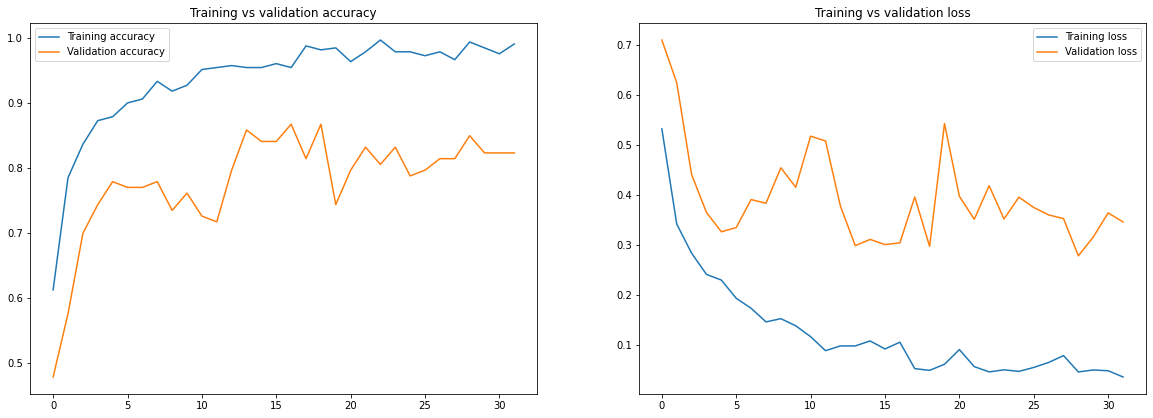

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[23  1 11]
 [ 1 36  4]
 [ 1  2 34]]
Normalized confusion matrix
[[0.66 0.03 0.31]
 [0.02 0.88 0.1 ]
 [0.03 0.05 0.92]]


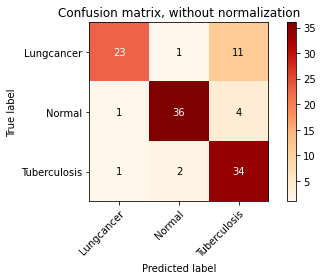

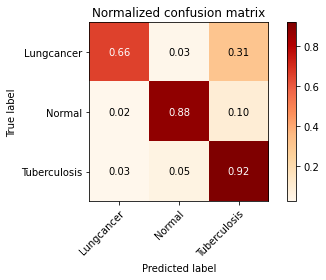

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam  
--> 0.85

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 84.61it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.5253 - accuracy: 0.6091
Epoch 1: val_accuracy improved from -inf to 0.69912, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 47s 475ms/step - loss: 0.5253 - accuracy: 0.6091 - val_loss: 0.4323 - val_accuracy: 0.6991 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3743 - accuracy: 0.7758
Epoch 2: val_accuracy did not improve from 0.69912
42/42 [==============================] - 10s 242ms/step - loss: 0.3743 - accuracy: 0.7758 - val_loss: 0.4503 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.3069 - accuracy: 0.8364
Epoch 3: val_accuracy improved from 0.69912 to 0.71681, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 12s 280ms/step - loss: 0.3069 - accuracy: 0.8364 - val_loss: 0.3634 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 4/100
42/42 [===

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

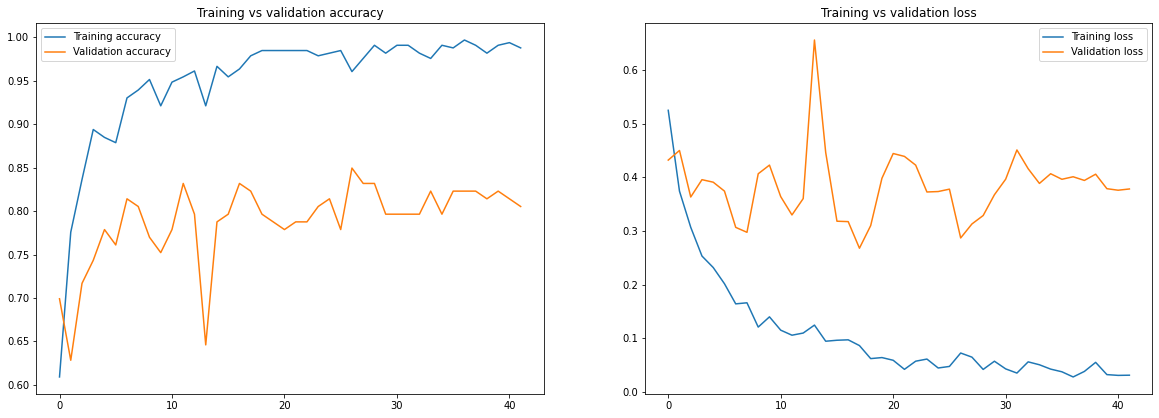

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  0 13]
 [ 0 34  7]
 [ 1  1 35]]
Normalized confusion matrix
[[0.63 0.   0.37]
 [0.   0.83 0.17]
 [0.03 0.03 0.95]]


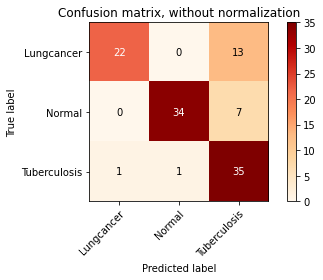

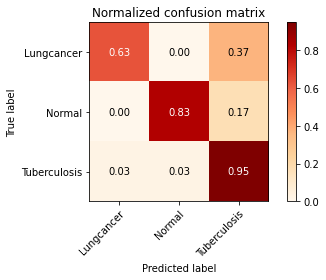

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 8 soft pre bi sgd  
--> 0.

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_sgd.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 84.61it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_sgd = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_sgd = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_sgd.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

In [ ]:
H_Dense = H8_soft_pre_bi_sgd                            ##
pred_Dense = pred_H8_soft_pre_bi_sgd                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

In [ ]:
y_pred = pred_H8_soft_pre_bi_sgd.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 8 soft pre cate 
--> 0.82

In [ ]:
BS = 8                                                             ##
filepath = "model8_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 125.76it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.7671 - accuracy: 0.6697
Epoch 1: val_accuracy improved from -inf to 0.42478, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 25s 227ms/step - loss: 0.7671 - accuracy: 0.6697 - val_loss: 1.3499 - val_accuracy: 0.4248 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.5237 - accuracy: 0.7848
Epoch 2: val_accuracy improved from 0.42478 to 0.47788, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 7s 158ms/step - loss: 0.5237 - accuracy: 0.7848 - val_loss: 1.4121 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.3887 - accuracy: 0.8758
Epoch 3: val_accuracy improved from 0.47788 to 0.66372, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 7s 157ms/step - loss: 0.3887 - accuracy: 0.8758 - val_loss: 0.7882 - val_accuracy: 0.6637 - 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

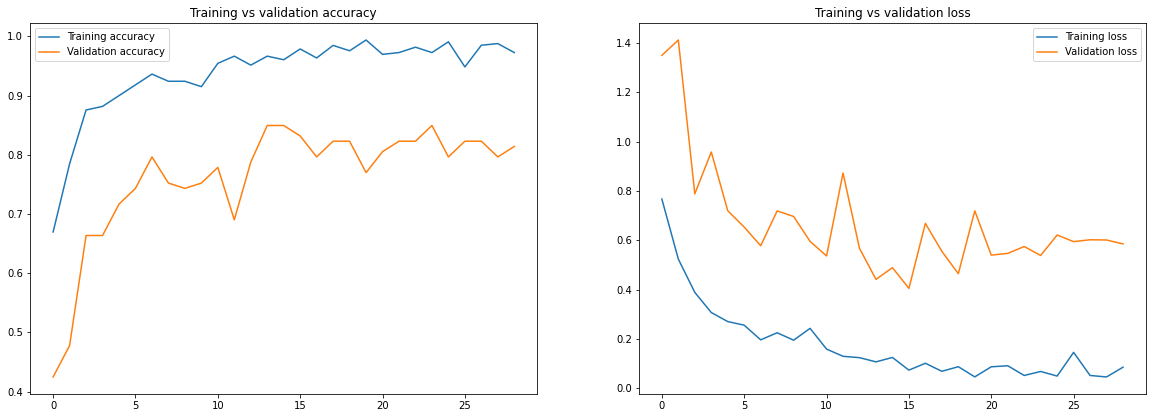

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate                            ##
pred_Dense = pred_H8_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  0 13]
 [ 0 37  4]
 [ 2  2 33]]
Normalized confusion matrix
[[0.63 0.   0.37]
 [0.   0.9  0.1 ]
 [0.05 0.05 0.89]]


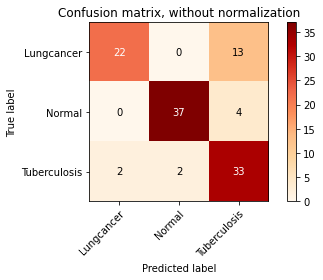

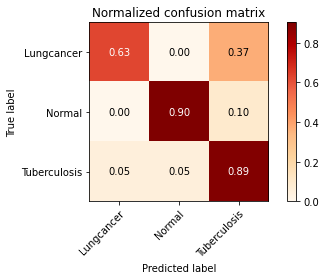

In [ ]:
y_pred = pred_H8_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate adam
--> 0.85

In [ ]:
BS = 8                                                       ##
filepath = "model8_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 120.74it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.8677 - accuracy: 0.5909
Epoch 1: val_accuracy improved from -inf to 0.51327, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 21s 220ms/step - loss: 0.8677 - accuracy: 0.5909 - val_loss: 1.2186 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.5095 - accuracy: 0.7697
Epoch 2: val_accuracy improved from 0.51327 to 0.61947, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 7s 162ms/step - loss: 0.5095 - accuracy: 0.7697 - val_loss: 0.7594 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.4098 - accuracy: 0.8424
Epoch 3: val_accuracy improved from 0.61947 to 0.66372, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 7s 163ms/step - loss: 0.4098 - accuracy: 0.8424 - val_loss: 0.8808 - val_accu

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

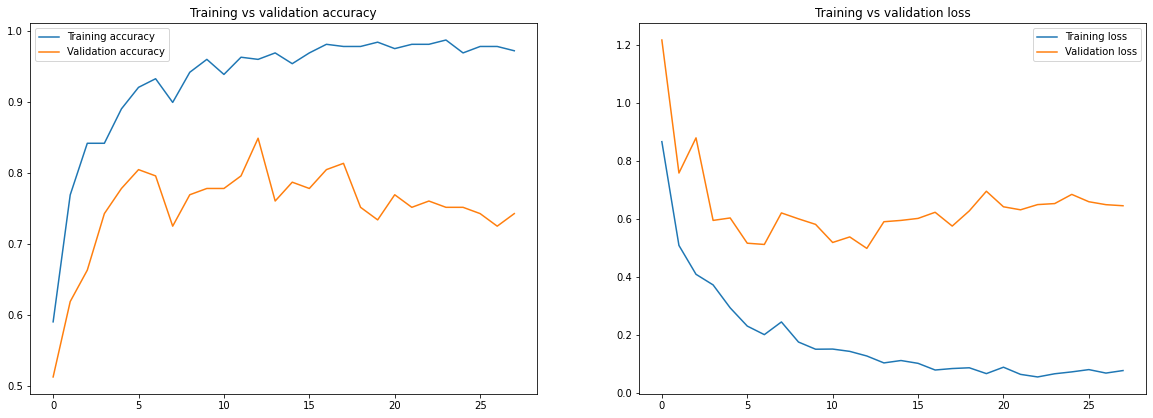

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate_adam                            ##
pred_Dense = pred_H8_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  0 15]
 [ 0 33  8]
 [ 3  3 31]]
Normalized confusion matrix
[[0.57 0.   0.43]
 [0.   0.8  0.2 ]
 [0.08 0.08 0.84]]


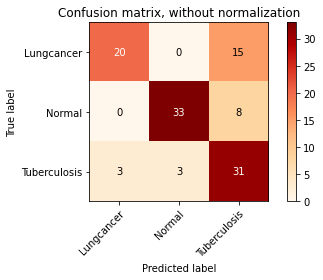

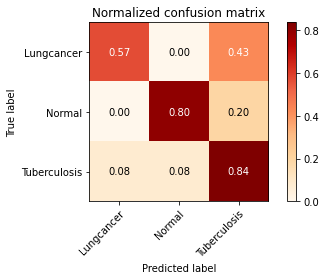

In [ ]:
y_pred = pred_H8_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate sgd  
--> 0.

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_cate_sgd.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 84.61it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate_sgd = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate_sgd = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate_sgd.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

In [ ]:
H_Dense = H8_soft_pre_cate_sgd                            ##
pred_Dense = pred_H8_soft_pre_cate_sgd                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

In [ ]:
y_pred = pred_H8_soft_pre_cate_sgd.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

### 16  


#### 16  soft pre bi
--> 0.83

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 120.04it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5054 - accuracy: 0.6211
Epoch 1: val_accuracy improved from -inf to 0.53982, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 28s 450ms/step - loss: 0.5054 - accuracy: 0.6211 - val_loss: 0.5250 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3421 - accuracy: 0.7950
Epoch 2: val_accuracy improved from 0.53982 to 0.61947, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 6s 291ms/step - loss: 0.3421 - accuracy: 0.7950 - val_loss: 0.4604 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2803 - accuracy: 0.8509
Epoch 3: val_accuracy improved from 0.61947 to 0.62832, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 6s 289ms/step - loss: 0.2803 - accuracy: 0.8509 - val_loss: 0.5077 - val_accuracy: 0.6283 - lr:

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

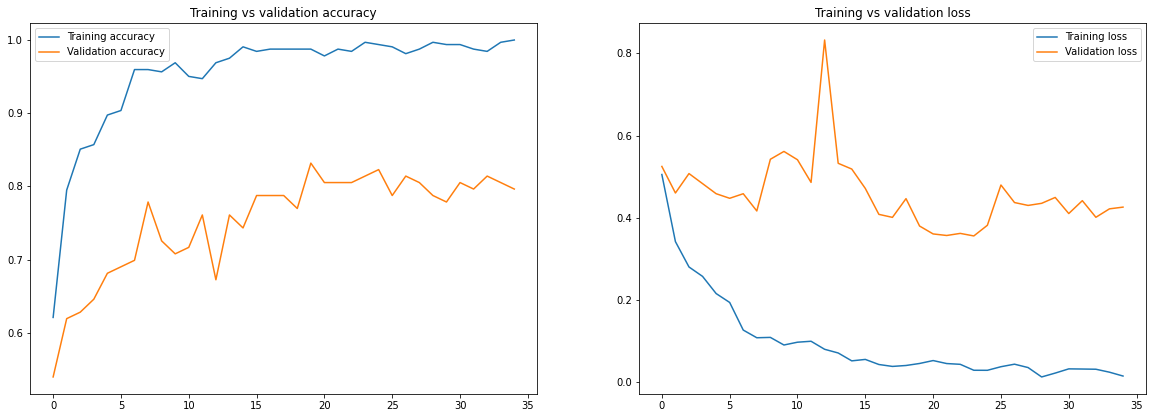

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  0 15]
 [ 0 37  4]
 [ 2  2 33]]
Normalized confusion matrix
[[0.57 0.   0.43]
 [0.   0.9  0.1 ]
 [0.05 0.05 0.89]]


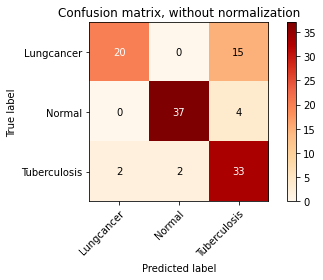

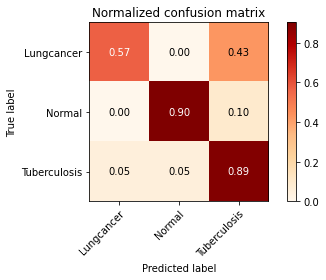

In [ ]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre bi adam
--> 0.84

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 126.36it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.5619 - accuracy: 0.5714
Epoch 1: val_accuracy improved from -inf to 0.58407, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 21s 429ms/step - loss: 0.5619 - accuracy: 0.5714 - val_loss: 0.4790 - val_accuracy: 0.5841 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3511 - accuracy: 0.7950
Epoch 2: val_accuracy improved from 0.58407 to 0.62832, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 6s 297ms/step - loss: 0.3511 - accuracy: 0.7950 - val_loss: 0.4606 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2925 - accuracy: 0.8199
Epoch 3: val_accuracy did not improve from 0.62832
21/21 [==============================] - 5s 215ms/step - loss: 0.2925 - accuracy: 0.8199 - val_loss: 0.4475 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 4/100
21/21 [===

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

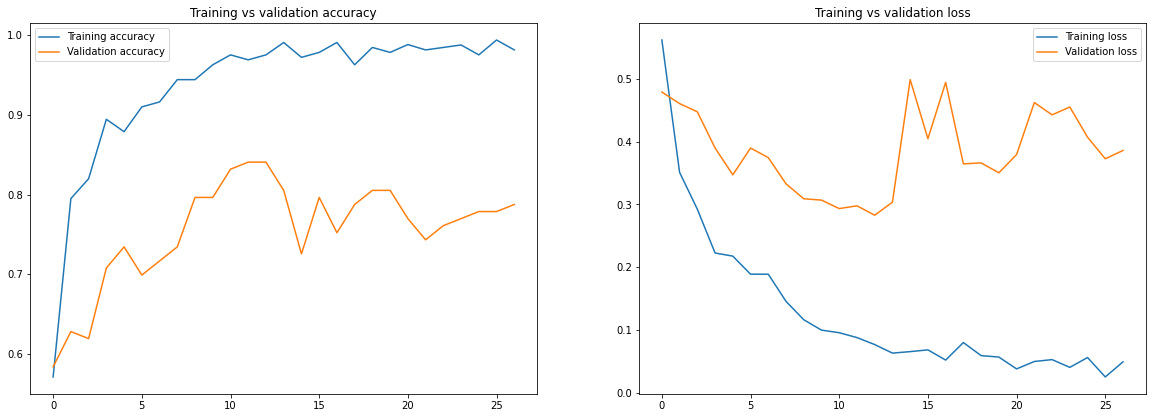

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  0 13]
 [ 0 34  7]
 [ 3  1 33]]
Normalized confusion matrix
[[0.63 0.   0.37]
 [0.   0.83 0.17]
 [0.08 0.03 0.89]]


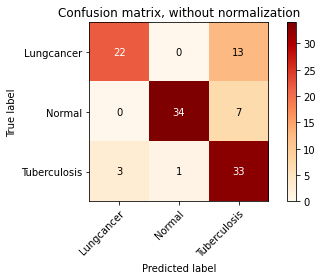

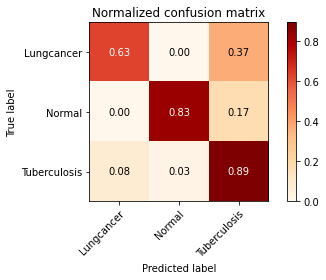

In [ ]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate 
--> 0.80

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 127.56it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8031 - accuracy: 0.6460
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 25s 455ms/step - loss: 0.8031 - accuracy: 0.6460 - val_loss: 0.7481 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4683 - accuracy: 0.8354
Epoch 2: val_accuracy did not improve from 0.64602
21/21 [==============================] - 5s 219ms/step - loss: 0.4683 - accuracy: 0.8354 - val_loss: 0.7754 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.3659 - accuracy: 0.8727
Epoch 3: val_accuracy improved from 0.64602 to 0.65487, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 6s 293ms/step - loss: 0.3659 - accuracy: 0.8727 - val_loss: 0.7387 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 4/100
21/21 [=========

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

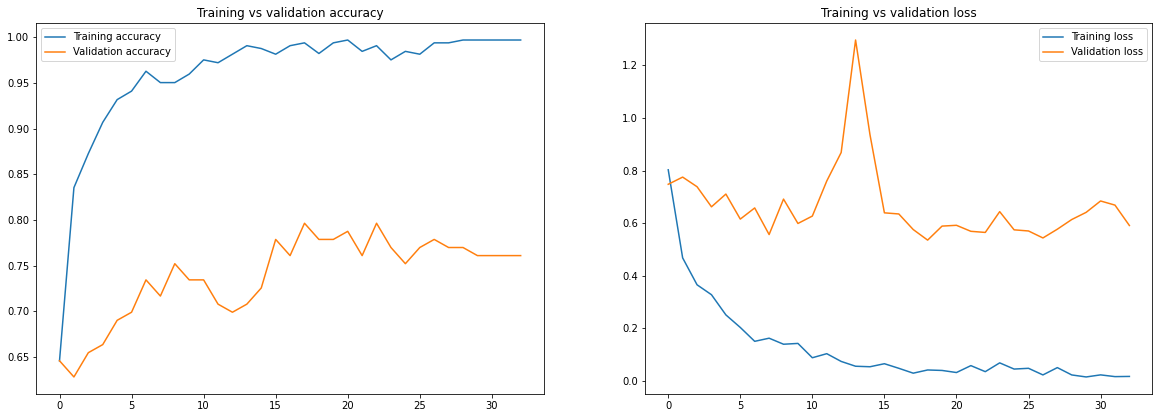

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate                            ##
pred_Dense = pred_H16_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  1 15]
 [ 0 36  5]
 [ 3  3 31]]
Normalized confusion matrix
[[0.54 0.03 0.43]
 [0.   0.88 0.12]
 [0.08 0.08 0.84]]


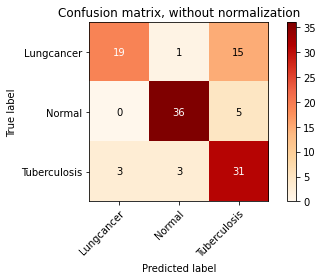

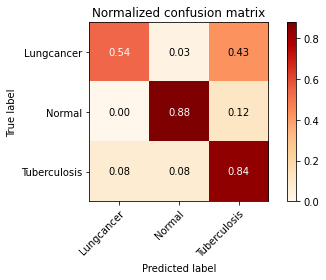

In [ ]:
y_pred = pred_H16_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate adam
--> 0.86

In [ ]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 121.99it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)     

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8492 - accuracy: 0.5901
Epoch 1: val_accuracy improved from -inf to 0.55752, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 20s 433ms/step - loss: 0.8492 - accuracy: 0.5901 - val_loss: 0.8730 - val_accuracy: 0.5575 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4829 - accuracy: 0.7888
Epoch 2: val_accuracy improved from 0.55752 to 0.67257, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 6s 291ms/step - loss: 0.4829 - accuracy: 0.7888 - val_loss: 0.7597 - val_accuracy: 0.6726 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.3831 - accuracy: 0.8230
Epoch 3: val_accuracy improved from 0.67257 to 0.69027, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 6s 293ms/step - loss: 0.3831 - accuracy: 0.8230 - val_loss: 0.7041 - val_a

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

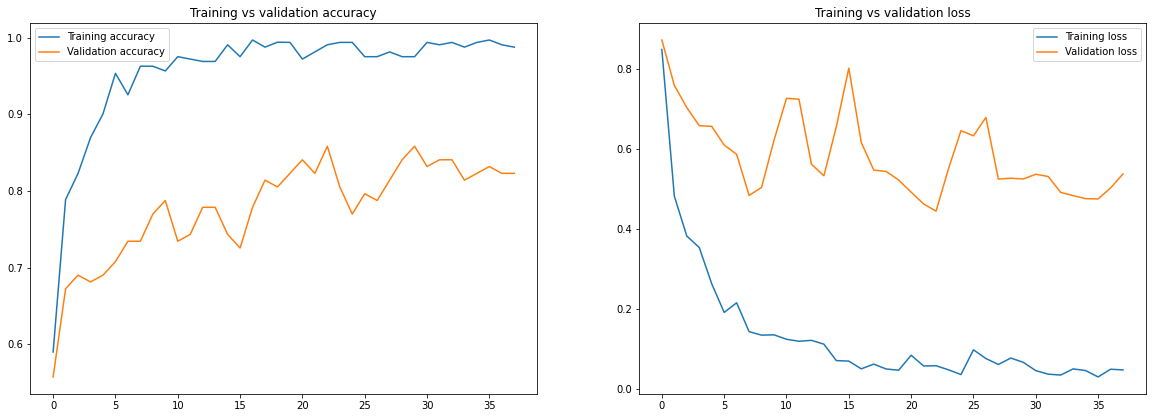

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H16_soft_pre_cate_adam                            ##
pred_Dense = pred_H16_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25  0 10]
 [ 0 34  7]
 [ 1  2 34]]
Normalized confusion matrix
[[0.71 0.   0.29]
 [0.   0.83 0.17]
 [0.03 0.05 0.92]]


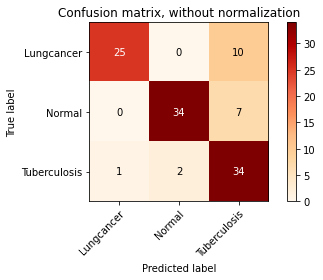

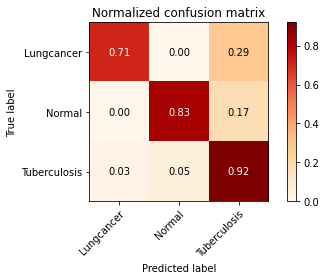

In [ ]:
y_pred = pred_H16_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 32

#### 32  soft pre bi
--> 0.84

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 126.38it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H32_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H32_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5189 - accuracy: 0.6078
Epoch 1: val_accuracy improved from -inf to 0.50442, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 26s 1s/step - loss: 0.5189 - accuracy: 0.6078 - val_loss: 0.6055 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3532 - accuracy: 0.8137
Epoch 2: val_accuracy did not improve from 0.50442
10/10 [==============================] - 4s 415ms/step - loss: 0.3532 - accuracy: 0.8137 - val_loss: 0.6567 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3058 - accuracy: 0.8595
Epoch 3: val_accuracy did not improve from 0.50442
10/10 [==============================] - 4s 414ms/step - loss: 0.3058 - accuracy: 0.8595 - val_loss: 0.6549 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2546 - a

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

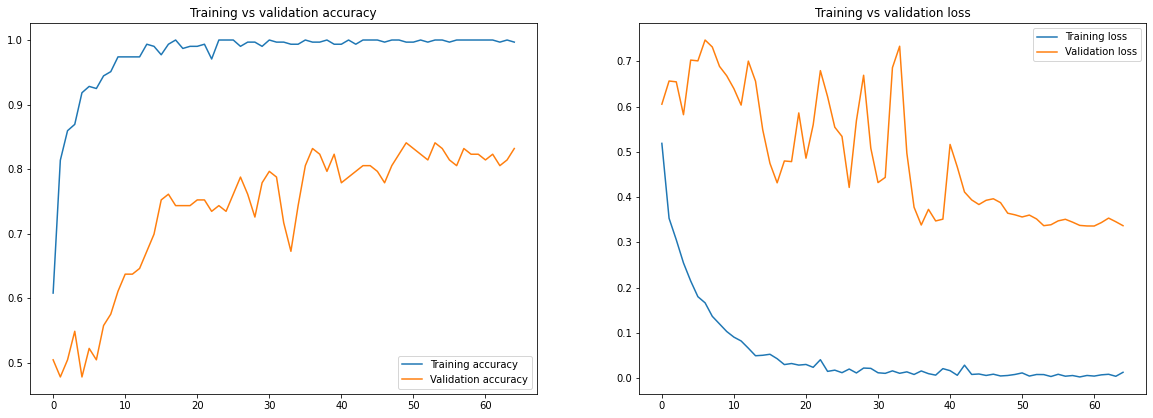

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi                            ##
pred_Dense = pred_H32_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25  0 10]
 [ 0 36  5]
 [ 3  1 33]]
Normalized confusion matrix
[[0.71 0.   0.29]
 [0.   0.88 0.12]
 [0.08 0.03 0.89]]


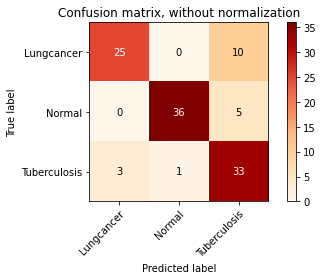

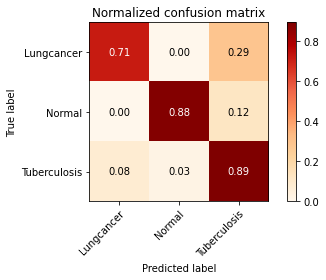

In [ ]:
y_pred = pred_H32_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi adam
--> 0.84

In [ ]:
BS = 32                                                      ##
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 127.30it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5642 - accuracy: 0.5261
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 21s 899ms/step - loss: 0.5642 - accuracy: 0.5261 - val_loss: 0.5382 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3738 - accuracy: 0.7614
Epoch 2: val_accuracy improved from 0.57522 to 0.60177, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 6s 596ms/step - loss: 0.3738 - accuracy: 0.7614 - val_loss: 0.5035 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3145 - accuracy: 0.8137
Epoch 3: val_accuracy did not improve from 0.60177
10/10 [==============================] - 4s 416ms/step - loss: 0.3145 - accuracy: 0.8137 - val_loss: 0.5112 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 4/100
10/10 [===

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

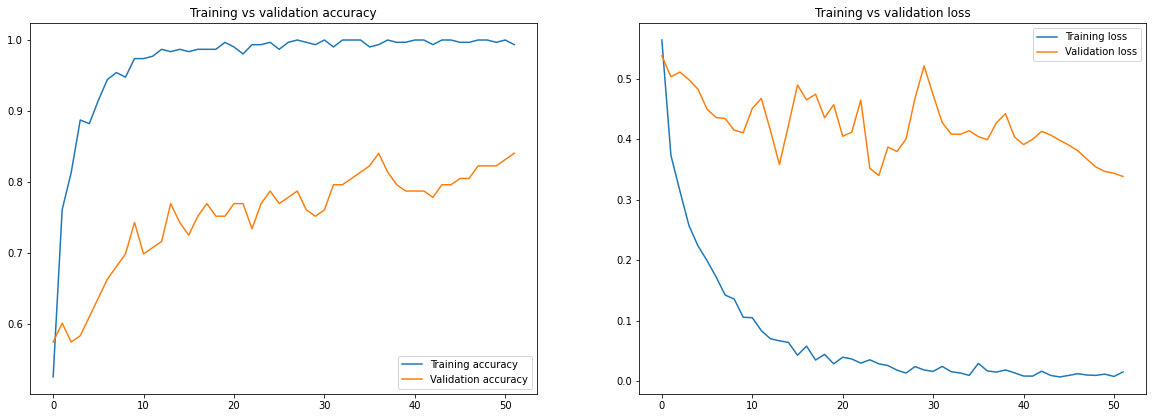

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_bi_adam                            ##
pred_Dense = pred_H32_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24  0 11]
 [ 0 35  6]
 [ 0  1 36]]
Normalized confusion matrix
[[0.69 0.   0.31]
 [0.   0.85 0.15]
 [0.   0.03 0.97]]


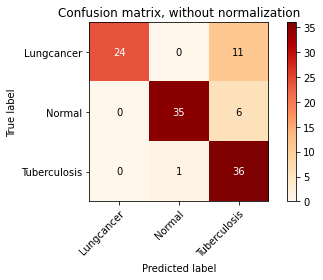

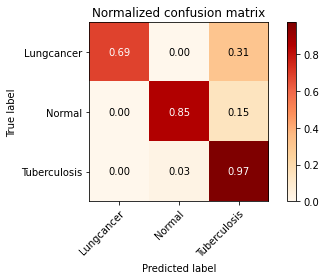

In [ ]:
y_pred = pred_H32_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate 
--> 0.82

In [ ]:
BS = 32                                                             ##
filepath = "model32_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 126.23it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7468 - accuracy: 0.6594
Epoch 1: val_accuracy improved from -inf to 0.40708, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 23s 913ms/step - loss: 0.7468 - accuracy: 0.6594 - val_loss: 1.4931 - val_accuracy: 0.4071 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.4464 - accuracy: 0.8333
Epoch 2: val_accuracy improved from 0.40708 to 0.44248, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 6s 574ms/step - loss: 0.4464 - accuracy: 0.8333 - val_loss: 1.5655 - val_accuracy: 0.4425 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3446 - accuracy: 0.8725
Epoch 3: val_accuracy improved from 0.44248 to 0.50442, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 6s 572ms/step - loss: 0.3446 - accuracy: 0.8725 - val_loss: 1.4068 - val_accuracy: 0.5044

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

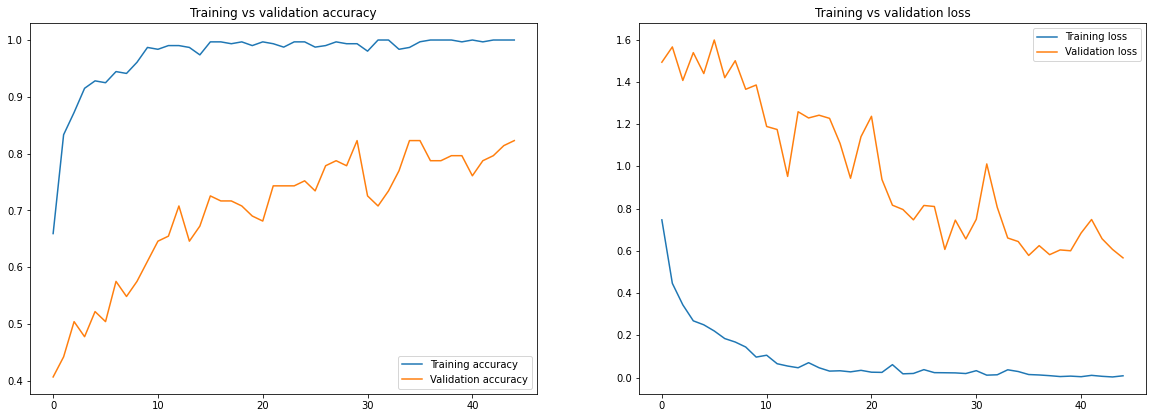

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate                            ##
pred_Dense = pred_H32_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[26  0  9]
 [ 1 39  1]
 [ 5  4 28]]
Normalized confusion matrix
[[0.74 0.   0.26]
 [0.02 0.95 0.02]
 [0.14 0.11 0.76]]


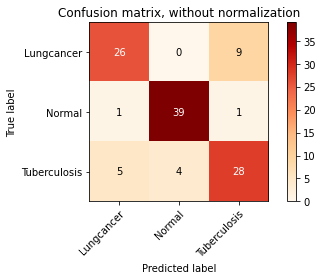

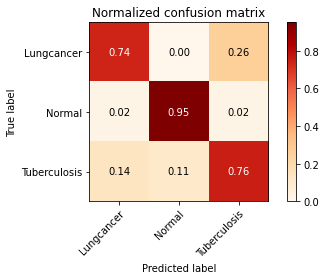

In [ ]:
y_pred = pred_H32_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate adam
--> 0.85

In [ ]:
BS = 32                                                       ##
filepath = "model32_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:03<00:00, 124.51it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense,  batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.9200 - accuracy: 0.5752
Epoch 1: val_accuracy improved from -inf to 0.54867, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 20s 944ms/step - loss: 0.9200 - accuracy: 0.5752 - val_loss: 0.9513 - val_accuracy: 0.5487 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.5082 - accuracy: 0.8072
Epoch 2: val_accuracy improved from 0.54867 to 0.56637, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 6s 586ms/step - loss: 0.5082 - accuracy: 0.8072 - val_loss: 1.0028 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.3900 - accuracy: 0.8438
Epoch 3: val_accuracy improved from 0.56637 to 0.59292, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 6s 616ms/step - loss: 0.3900 - accuracy: 0.8438 - val_loss: 0.9728 - val_a

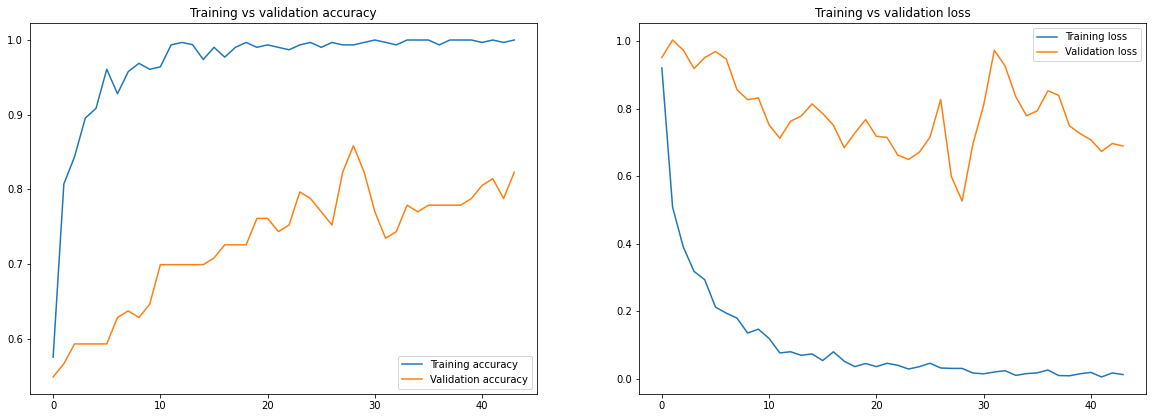

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H32_soft_pre_cate_adam                            ##
pred_Dense = pred_H32_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  0 13]
 [ 0 37  4]
 [ 1  2 34]]
Normalized confusion matrix
[[0.63 0.   0.37]
 [0.   0.9  0.1 ]
 [0.03 0.05 0.92]]


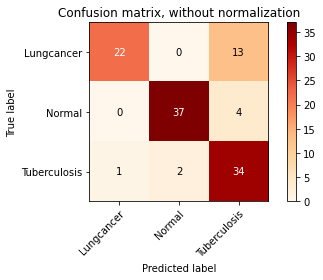

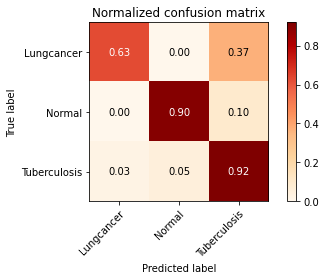

In [ ]:
y_pred = pred_H32_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1

#### 1  soft pre bi
--> 0.76

In [ ]:
BS = 1                                                      ##
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [04:38<00:00,  1.62it/s]


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H1_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H1_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6227 - accuracy: 0.4260
Epoch 1: val_accuracy improved from -inf to 0.56637, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 147s 246ms/step - loss: 0.6227 - accuracy: 0.4260 - val_loss: 0.5494 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.5389 - accuracy: 0.6331
Epoch 2: val_accuracy improved from 0.56637 to 0.63717, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 70s 208ms/step - loss: 0.5389 - accuracy: 0.6331 - val_loss: 0.4349 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4627 - accuracy: 0.6923
Epoch 3: val_accuracy improved from 0.63717 to 0.69912, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 57s 170ms/step - lo

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

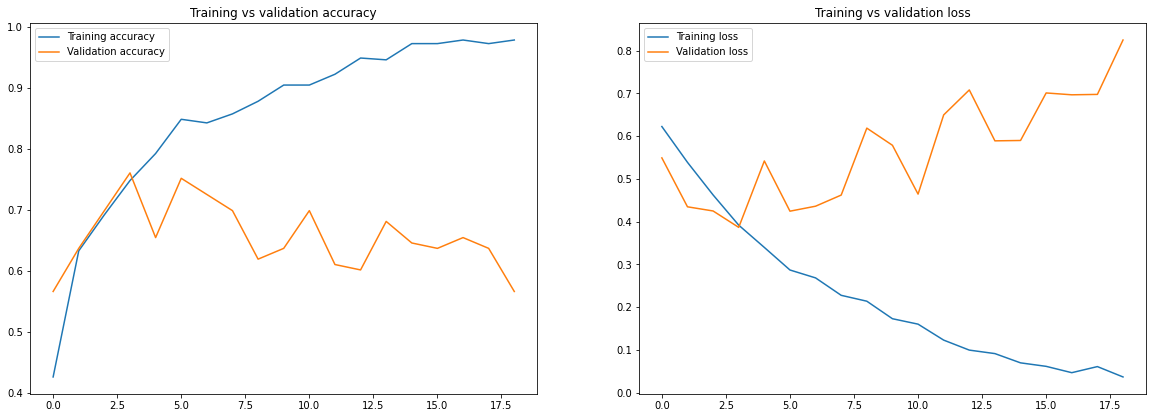

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi                            ##
pred_Dense = pred_H1_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[ 8  0 27]
 [ 2 21 18]
 [ 2  0 35]]
Normalized confusion matrix
[[0.23 0.   0.77]
 [0.05 0.51 0.44]
 [0.05 0.   0.95]]


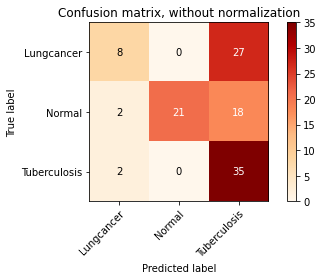

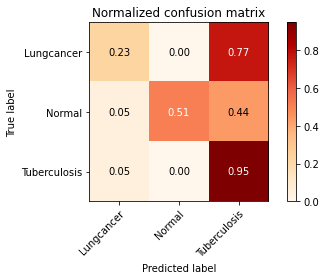

In [ ]:
y_pred = pred_H1_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam
--> 0.77

In [ ]:
BS = 1                                                            ##
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 86.43it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6256 - accuracy: 0.3964
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 52s 110ms/step - loss: 0.6256 - accuracy: 0.3964 - val_loss: 0.4941 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.6183
Epoch 2: val_accuracy did not improve from 0.62832
338/338 [==============================] - 32s 95ms/step - loss: 0.5488 - accuracy: 0.6183 - val_loss: 0.4726 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4769 - accuracy: 0.6834
Epoch 3: val_accuracy did not improve from 0.62832
338/338 [==============================] - 32s 95ms/step - loss: 0.4769 - accuracy: 0.6834 - val_loss: 0.5334 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 4/100
338/338 [==============================] - ETA: 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

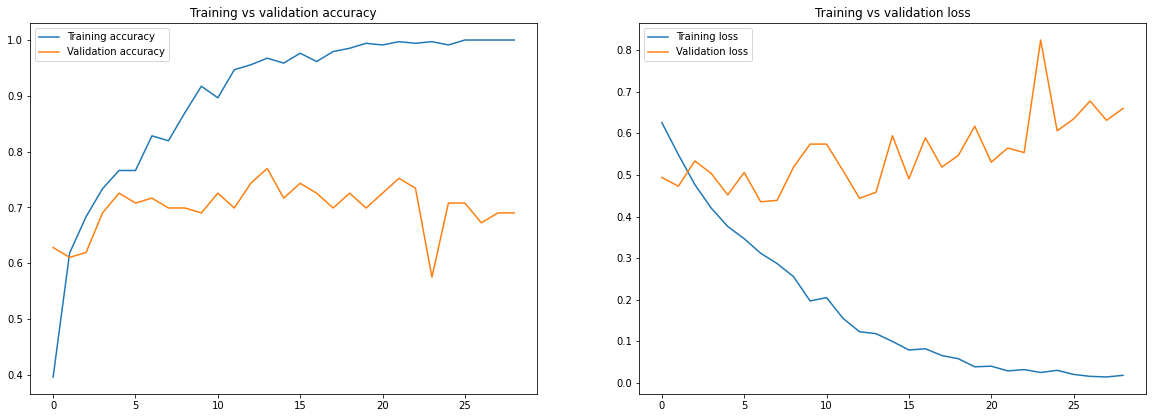

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_bi_adam                            ##
pred_Dense = pred_H1_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  0 15]
 [ 1 30 10]
 [ 9  0 28]]
Normalized confusion matrix
[[0.57 0.   0.43]
 [0.02 0.73 0.24]
 [0.24 0.   0.76]]


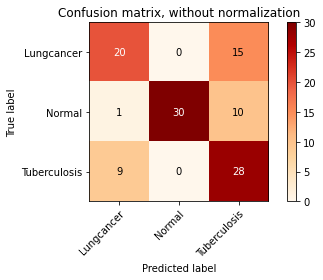

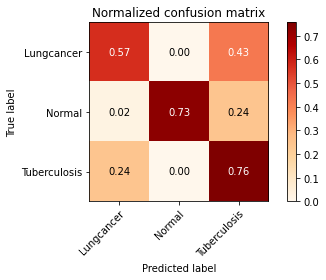

In [ ]:
y_pred = pred_H1_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate 
--> 0.78

In [ ]:
BS = 1                                                             ##
filepath = "model1_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 86.25it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.0477 - accuracy: 0.4763
Epoch 1: val_accuracy improved from -inf to 0.53982, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 61s 123ms/step - loss: 1.0477 - accuracy: 0.4763 - val_loss: 0.9435 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.8512 - accuracy: 0.6183
Epoch 2: val_accuracy improved from 0.53982 to 0.76106, saving model to mode1_soft_pre_cate.h5
338/338 [==============================] - 38s 111ms/step - loss: 0.8512 - accuracy: 0.6183 - val_loss: 0.5779 - val_accuracy: 0.7611 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.6761 - accuracy: 0.6923
Epoch 3: val_accuracy did not improve from 0.76106
338/338 [==============================] - 36s 106ms/step - loss: 0.6761 - accuracy: 0.6923 - val_loss: 0.5958 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 4/100
338/33

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

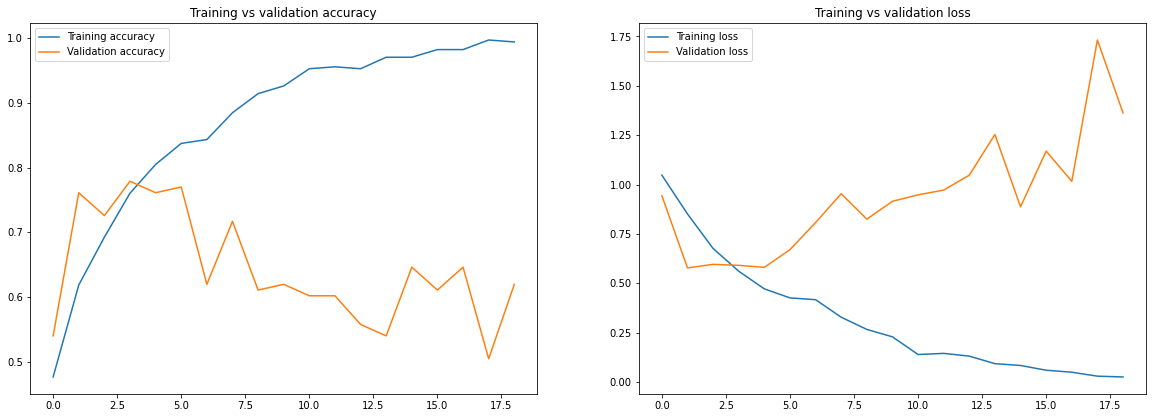

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate                            ##
pred_Dense = pred_H1_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24  0 11]
 [ 3 21 17]
 [11  1 25]]
Normalized confusion matrix
[[0.69 0.   0.31]
 [0.07 0.51 0.41]
 [0.3  0.03 0.68]]


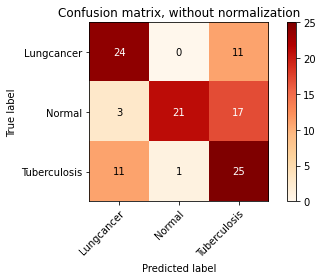

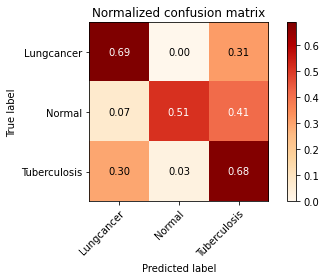

In [ ]:
y_pred = pred_H1_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate adam
--> 0.75

In [ ]:
BS = 1                                                       ##
filepath = "model1_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 88.91it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:500]:    #fix w & bias in layer 0-500
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.0640 - accuracy: 0.4231
Epoch 1: val_accuracy improved from -inf to 0.61062, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 51s 110ms/step - loss: 1.0640 - accuracy: 0.4231 - val_loss: 0.8517 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.8804 - accuracy: 0.6331
Epoch 2: val_accuracy did not improve from 0.61062
338/338 [==============================] - 31s 92ms/step - loss: 0.8804 - accuracy: 0.6331 - val_loss: 0.7098 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.7173 - accuracy: 0.6923
Epoch 3: val_accuracy improved from 0.61062 to 0.72566, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 33s 98ms/step - loss: 0.7173 - accuracy: 0.6923 - val_loss: 0.5802 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 4/

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

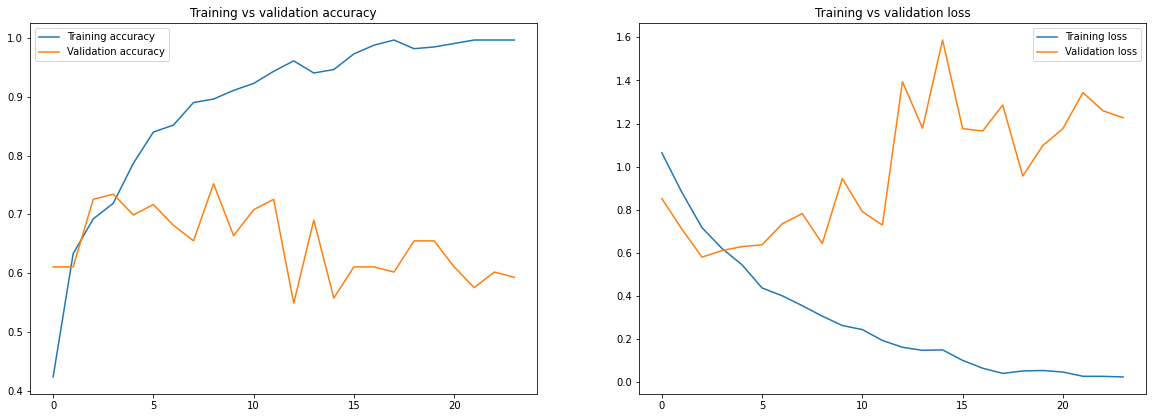

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H1_soft_pre_cate_adam                            ##
pred_Dense = pred_H1_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[23  0 12]
 [ 5 23 13]
 [14  2 21]]
Normalized confusion matrix
[[0.66 0.   0.34]
 [0.12 0.56 0.32]
 [0.38 0.05 0.57]]


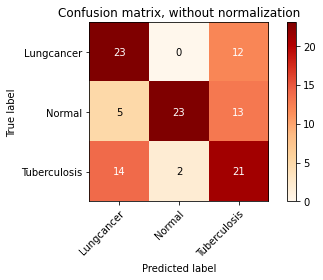

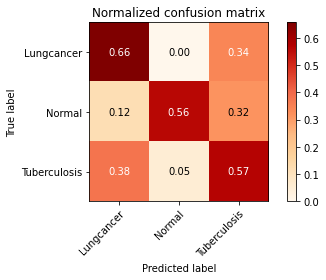

In [ ]:
y_pred = pred_H1_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Train-Test  0-400


ตรวจสอบดีแล้ว 

### 8 
- binary_crossentropy
- categorical_crossentropy
- RMSprop 
- Adam
- ModelCheckpoint():
ใช้ในการทำ Save Model ที่ดีที่สุดในทุกรอบของการ Modeling
นามสกุลก็จะเป็น .5df เฉพาะ Packages Keras เท่านั้น
- ReduceLROnPlateau(): ใช้ในการลด Learning Rate (ความเร็วในการค้นหาจุดไหนคือ Global Minima)
    - monitor= ’val_loss’: ใช้ Criteria อะไรในการลด Learning Rate
    - patience= 5: ทนรอได้กี่ epoch ก่อนที่จะทำการลดค่า learning rate
    - verbose= 2: รูปแบบการแสดงผลหากเกิด Effect
    - factor= 0.5: หากไม่สามารถลด loss ได้ใน 5 epoch ทำการลด learning rate 50%

#### 8  soft pre bi
--> 0.85

In [ ]:
BS = 8                                                      ##
filepath = "model8_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 84.65it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H8_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H8_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.6364
Epoch 1: val_accuracy improved from -inf to 0.52212, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 46s 453ms/step - loss: 0.4676 - accuracy: 0.6364 - val_loss: 0.6105 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.2853 - accuracy: 0.8455
Epoch 2: val_accuracy improved from 0.52212 to 0.66372, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 13s 311ms/step - loss: 0.2853 - accuracy: 0.8455 - val_loss: 0.4559 - val_accuracy: 0.6637 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2493 - accuracy: 0.8485
Epoch 3: val_accuracy improved from 0.66372 to 0.70796, saving model to model8_soft_pre_bi.h5
42/42 [==============================] - 12s 291ms/step - loss: 0.2493 - accuracy: 0.8485 - val_loss: 0.4622 - val_accuracy: 0.7080 - lr: 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

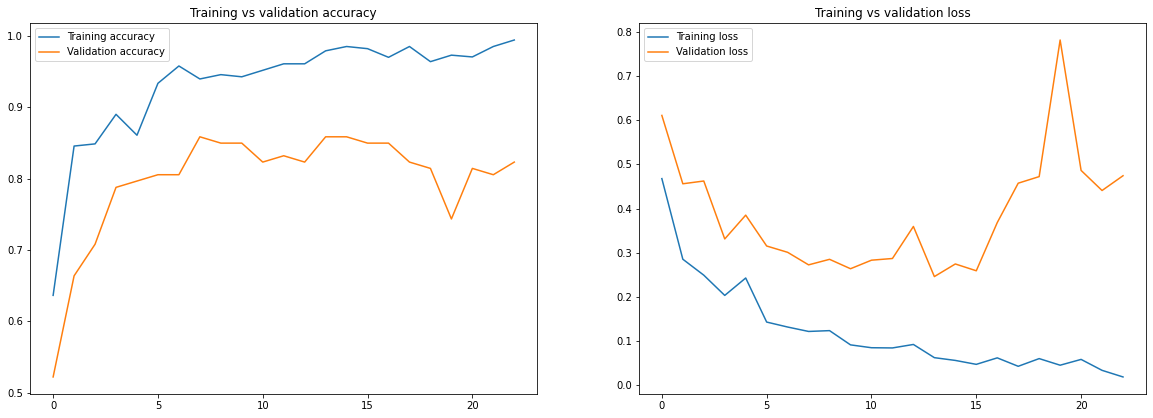

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi                            ##
pred_Dense = pred_H8_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  1 15]
 [ 0 38  3]
 [ 0  1 36]]
Normalized confusion matrix
[[0.54 0.03 0.43]
 [0.   0.93 0.07]
 [0.   0.03 0.97]]


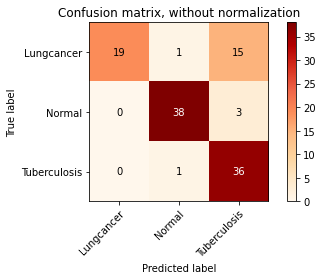

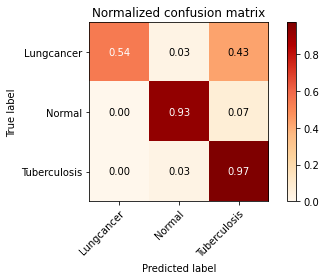

In [ ]:
y_pred = pred_H8_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre bi adam  
--> 0.83

In [ ]:
BS = 8                                                           ##
filepath = "model8_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 87.87it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.4895 - accuracy: 0.6242
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 31s 368ms/step - loss: 0.4895 - accuracy: 0.6242 - val_loss: 0.6348 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.3326 - accuracy: 0.7848
Epoch 2: val_accuracy improved from 0.57522 to 0.67257, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 12s 284ms/step - loss: 0.3326 - accuracy: 0.7848 - val_loss: 0.4808 - val_accuracy: 0.6726 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.2110 - accuracy: 0.8848
Epoch 3: val_accuracy improved from 0.67257 to 0.72566, saving model to model8_soft_pre_bi_adam.h5
42/42 [==============================] - 12s 283ms/step - loss: 0.2110 - accuracy: 0.8848 - val_loss: 0.4850 - val_accuracy

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

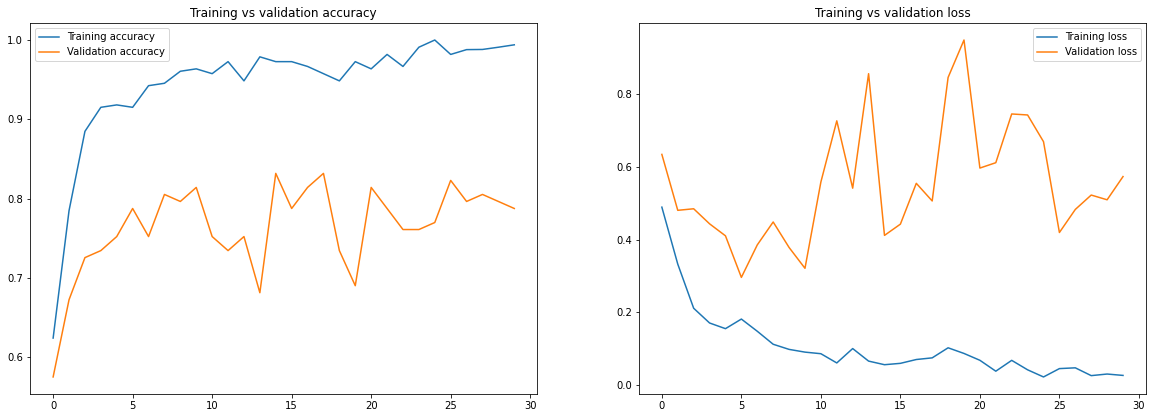

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_bi_adam                            ##
pred_Dense = pred_H8_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  0 16]
 [ 1 35  5]
 [ 0  2 35]]
Normalized confusion matrix
[[0.54 0.   0.46]
 [0.02 0.85 0.12]
 [0.   0.05 0.95]]


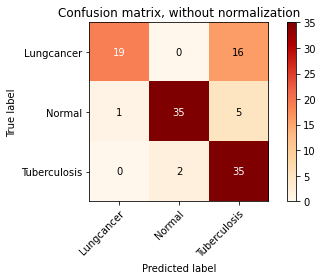

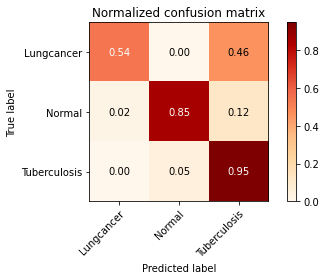

In [ ]:
y_pred = pred_H8_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')
# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')
plt.show()

#### 8 soft pre cate 
--> 0.84

In [ ]:
BS = 8                                                             ##
filepath = "model8_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 86.61it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.7040 - accuracy: 0.6788
Epoch 1: val_accuracy improved from -inf to 0.61062, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 39s 381ms/step - loss: 0.7040 - accuracy: 0.6788 - val_loss: 1.1024 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.4358 - accuracy: 0.8273
Epoch 2: val_accuracy improved from 0.61062 to 0.64602, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 12s 290ms/step - loss: 0.4358 - accuracy: 0.8273 - val_loss: 1.0928 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8780
Epoch 3: val_accuracy improved from 0.64602 to 0.71681, saving model to model8_soft_pre_cate.h5
42/42 [==============================] - 12s 294ms/step - loss: 0.3255 - accuracy: 0.8780 - val_loss: 0.9924 - val_accuracy: 0.7168 

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

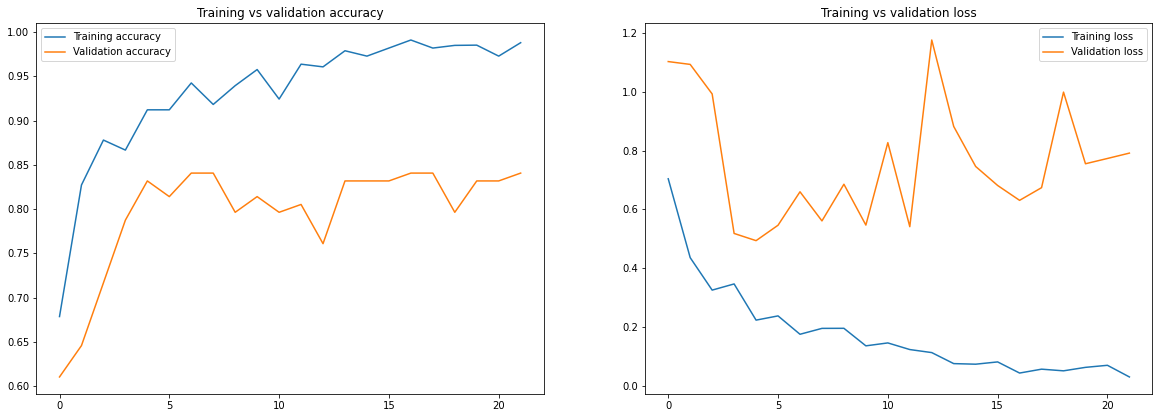

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate                            ##
pred_Dense = pred_H8_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  0 15]
 [ 0 38  3]
 [ 0  0 37]]
Normalized confusion matrix
[[0.57 0.   0.43]
 [0.   0.93 0.07]
 [0.   0.   1.  ]]


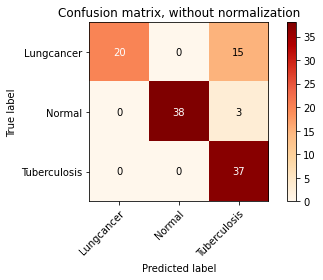

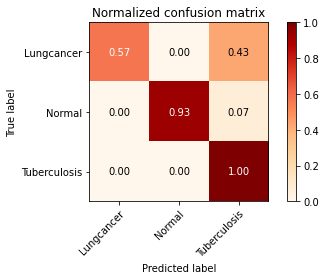

In [ ]:
y_pred = pred_H8_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 8 soft pre cate adam
--> 0.89

In [ ]:
BS = 8                                                       ##
filepath = "model8_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 88.01it/s] 


In [ ]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [ ]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H8_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H8_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H8_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
42/42 [==============================] - ETA: 0s - loss: 0.7298 - accuracy: 0.6879
Epoch 1: val_accuracy improved from -inf to 0.64602, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 31s 368ms/step - loss: 0.7298 - accuracy: 0.6879 - val_loss: 0.7766 - val_accuracy: 0.6460 - lr: 1.0000e-04
Epoch 2/100
42/42 [==============================] - ETA: 0s - loss: 0.4268 - accuracy: 0.8273
Epoch 2: val_accuracy improved from 0.64602 to 0.73451, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 12s 281ms/step - loss: 0.4268 - accuracy: 0.8273 - val_loss: 0.5769 - val_accuracy: 0.7345 - lr: 1.0000e-04
Epoch 3/100
42/42 [==============================] - ETA: 0s - loss: 0.3795 - accuracy: 0.8697
Epoch 3: val_accuracy improved from 0.73451 to 0.78761, saving model to model8_soft_pre_cate_adam.h5
42/42 [==============================] - 12s 284ms/step - loss: 0.3795 - accuracy: 0.8697 - val_loss: 0.4993 - val_ac

In [ ]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

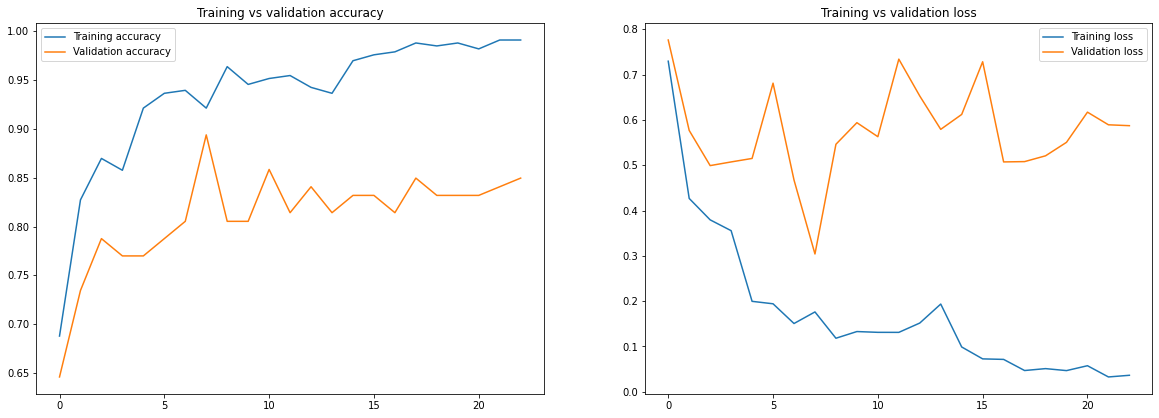

<Figure size 432x288 with 0 Axes>

In [ ]:
H_Dense = H8_soft_pre_cate_adam                            ##
pred_Dense = pred_H8_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[21  1 13]
 [ 0 39  2]
 [ 0  1 36]]
Normalized confusion matrix
[[0.6  0.03 0.37]
 [0.   0.95 0.05]
 [0.   0.03 0.97]]


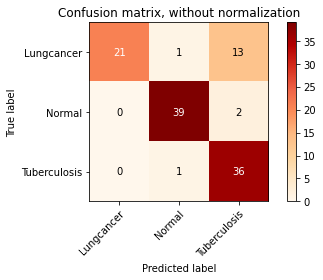

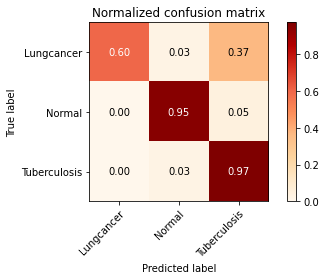

In [ ]:
y_pred = pred_H8_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 16  


#### 16  soft pre bi
--> 0.87

In [15]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [02:41<00:00,  2.79it/s]


In [16]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [17]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H16_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H16_soft_pre_bi = model_Dense.predict(x_test_Dense)
    
	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

74850304/74836368 [==============================] - 1s 0us/step
Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.4670 - accuracy: 0.7112
Epoch 1: val_accuracy improved from -inf to 0.46903, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 88s 1s/step - loss: 0.4670 - accuracy: 0.7112 - val_loss: 0.6085 - val_accuracy: 0.4690 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3040 - accuracy: 0.8106
Epoch 2: val_accuracy improved from 0.46903 to 0.47788, saving model to model16_soft_pre_bi.h5
21/21 [==============================] - 13s 607ms/step - loss: 0.3040 - accuracy: 0.8106 - val_loss: 0.7945 - val_accuracy: 0.4779 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2400 - accuracy: 0.8634
Epoch 3: val_accuracy did not improve from 0.47788
21/21 [==============================] - 10s 465ms/step - loss: 0.2400 - accuracy: 0.8634 - val_loss: 1.0439 - val_ac

In [40]:
model16 = keras.models.load_model('/content/model16_soft_pre_bi.h5')
pred16 = model16.predict(x_test_Dense)	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred16.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       1.00      0.77      0.87        35
      Normal       0.93      0.93      0.93        41
Tuberculosis       0.76      0.92      0.83        37

    accuracy                           0.88       113
   macro avg       0.89      0.87      0.88       113
weighted avg       0.89      0.88      0.88       113



In [18]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

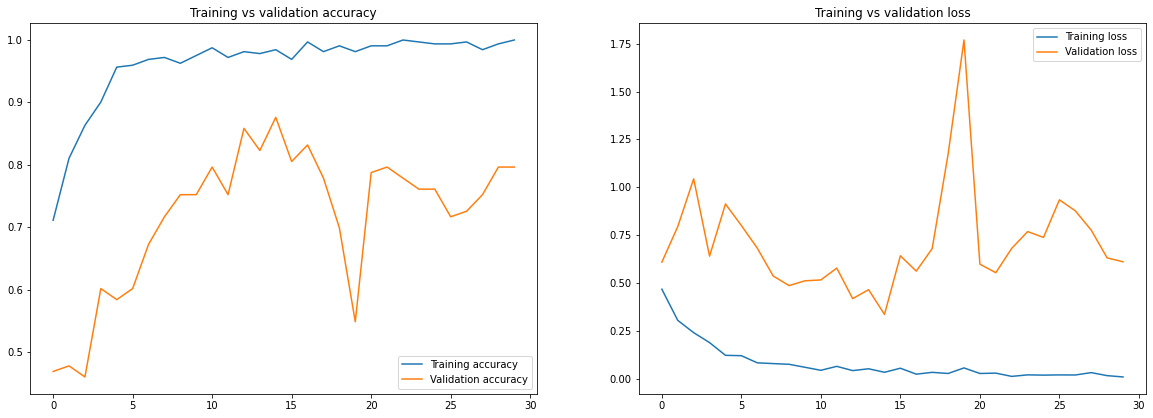

<Figure size 432x288 with 0 Axes>

In [19]:
H_Dense = H16_soft_pre_bi                            ##
pred_Dense = pred_H16_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[18  0 17]
 [ 0 35  6]
 [ 0  0 37]]
Normalized confusion matrix
[[0.51 0.   0.49]
 [0.   0.85 0.15]
 [0.   0.   1.  ]]


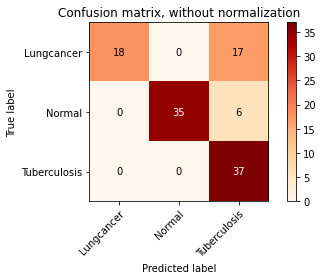

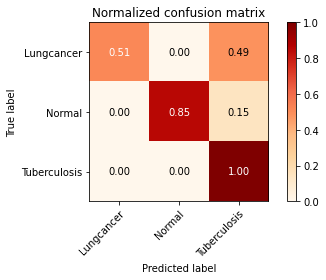

In [20]:
y_pred = pred_H16_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre bi adam (มี load_model)
--> 0.86


In [21]:
BS = 16                                                       ##
filepath = "model16_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 93.06it/s] 


In [22]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [23]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False
#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_bi_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.4822 - accuracy: 0.6304
Epoch 1: val_accuracy improved from -inf to 0.57522, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 31s 671ms/step - loss: 0.4822 - accuracy: 0.6304 - val_loss: 0.5097 - val_accuracy: 0.5752 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.3149 - accuracy: 0.8106
Epoch 2: val_accuracy improved from 0.57522 to 0.59292, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 10s 498ms/step - loss: 0.3149 - accuracy: 0.8106 - val_loss: 0.4842 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2685 - accuracy: 0.8354
Epoch 3: val_accuracy improved from 0.59292 to 0.62832, saving model to model16_soft_pre_bi_adam.h5
21/21 [==============================] - 10s 491ms/step - loss: 0.2685 - accuracy: 0.8354 - val_loss: 0.4858 - val_accur

In [43]:
model16 = load_model('model16_soft_pre_bi_adam.h5')
pred16 = model16.predict(x_test_Dense)	
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred16.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

              precision    recall  f1-score   support

  Lungcancer       0.96      0.77      0.86        35
      Normal       0.97      0.85      0.91        41
Tuberculosis       0.71      0.95      0.81        37

    accuracy                           0.86       113
   macro avg       0.88      0.86      0.86       113
weighted avg       0.89      0.86      0.86       113



In [24]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

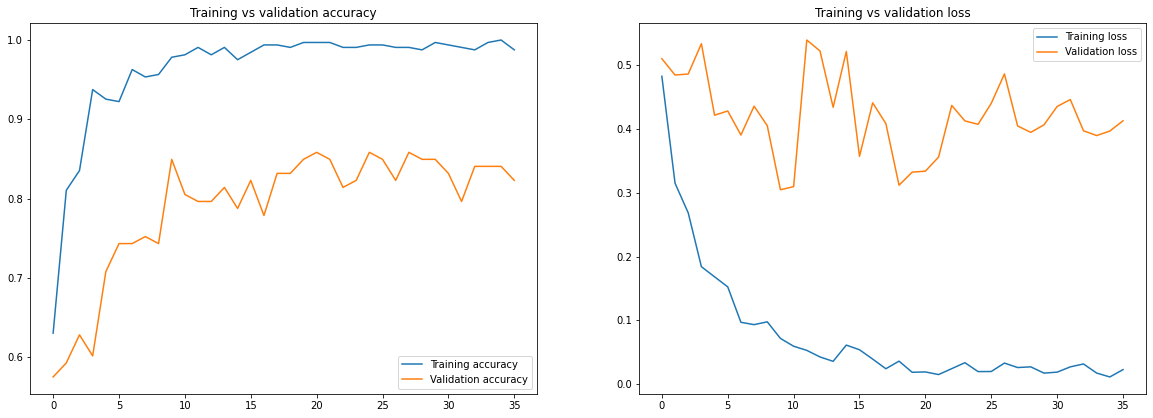

<Figure size 432x288 with 0 Axes>

In [25]:
H_Dense = H16_soft_pre_bi_adam                            ##
pred_Dense = pred_H16_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[22  0 13]
 [ 0 34  7]
 [ 0  0 37]]
Normalized confusion matrix
[[0.63 0.   0.37]
 [0.   0.83 0.17]
 [0.   0.   1.  ]]


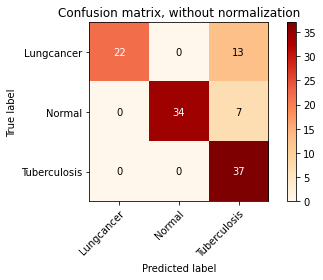

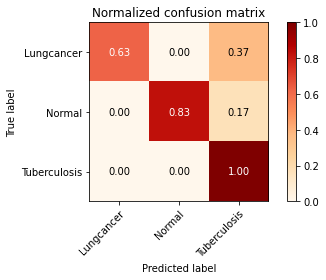

In [26]:
y_pred = pred_H16_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate 
--> 0.85

In [27]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 96.15it/s] 


In [28]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [29]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.7305 - accuracy: 0.6615
Epoch 1: val_accuracy improved from -inf to 0.41593, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 38s 669ms/step - loss: 0.7305 - accuracy: 0.6615 - val_loss: 1.4087 - val_accuracy: 0.4159 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4459 - accuracy: 0.8230
Epoch 2: val_accuracy improved from 0.41593 to 0.50442, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 10s 491ms/step - loss: 0.4459 - accuracy: 0.8230 - val_loss: 1.3630 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2816 - accuracy: 0.8882
Epoch 3: val_accuracy improved from 0.50442 to 0.52212, saving model to model16_soft_pre_cate.h5
21/21 [==============================] - 10s 491ms/step - loss: 0.2816 - accuracy: 0.8882 - val_loss: 1.4653 - val_accuracy: 0.52

In [30]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

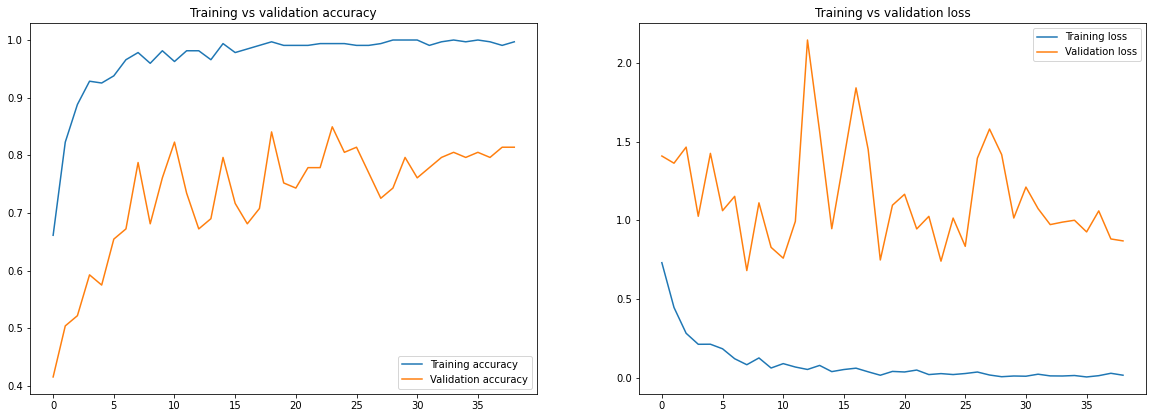

<Figure size 432x288 with 0 Axes>

In [31]:
H_Dense = H16_soft_pre_cate                            ##
pred_Dense = pred_H16_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[21  0 14]
 [ 0 34  7]
 [ 0  0 37]]
Normalized confusion matrix
[[0.6  0.   0.4 ]
 [0.   0.83 0.17]
 [0.   0.   1.  ]]


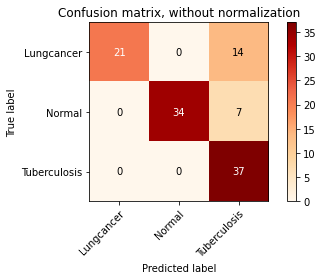

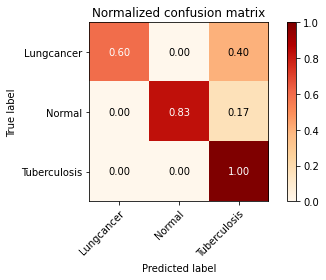

In [32]:
y_pred = pred_H16_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 16 soft pre cate adam
--> 0.81

In [33]:
BS = 16                                                       ##
filepath = "model16_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:06<00:00, 68.61it/s] 


In [34]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [35]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H16_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H16_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H16_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)     

Epoch 1/100
21/21 [==============================] - ETA: 0s - loss: 0.8161 - accuracy: 0.6242
Epoch 1: val_accuracy improved from -inf to 0.60177, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 44s 875ms/step - loss: 0.8161 - accuracy: 0.6242 - val_loss: 1.4535 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 2/100
21/21 [==============================] - ETA: 0s - loss: 0.4262 - accuracy: 0.8199
Epoch 2: val_accuracy improved from 0.60177 to 0.62832, saving model to model16_soft_pre_cate_adam.h5
21/21 [==============================] - 12s 584ms/step - loss: 0.4262 - accuracy: 0.8199 - val_loss: 1.3476 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 3/100
21/21 [==============================] - ETA: 0s - loss: 0.2534 - accuracy: 0.8913
Epoch 3: val_accuracy did not improve from 0.62832
21/21 [==============================] - 9s 430ms/step - loss: 0.2534 - accuracy: 0.8913 - val_loss: 1.2691 - val_accuracy: 0.5929 - lr: 1.0000e-04
Epoch 4/100
21/21

In [36]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

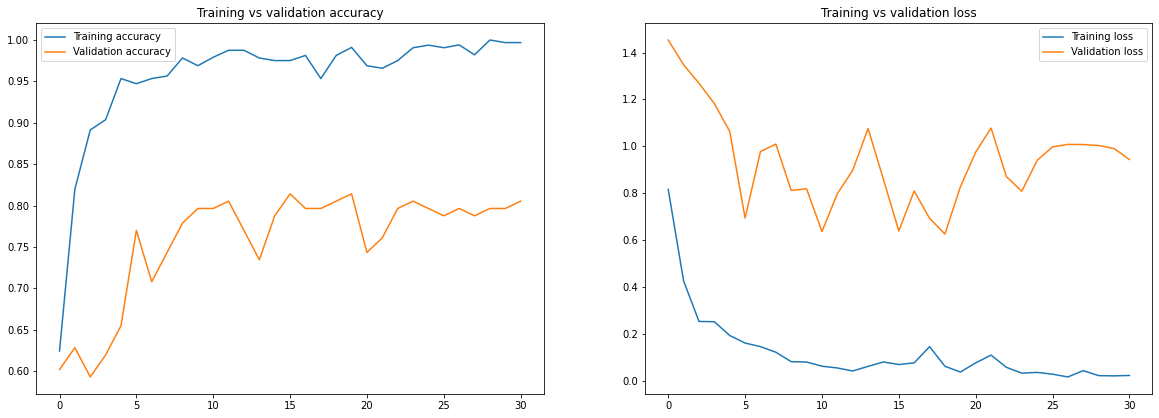

<Figure size 432x288 with 0 Axes>

In [37]:
H_Dense = H16_soft_pre_cate_adam                            ##
pred_Dense = pred_H16_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[20  1 14]
 [ 0 35  6]
 [ 0  1 36]]
Normalized confusion matrix
[[0.57 0.03 0.4 ]
 [0.   0.85 0.15]
 [0.   0.03 0.97]]


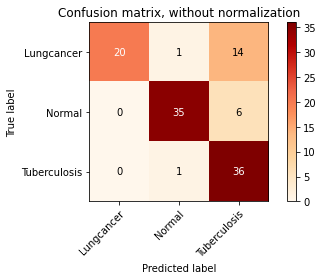

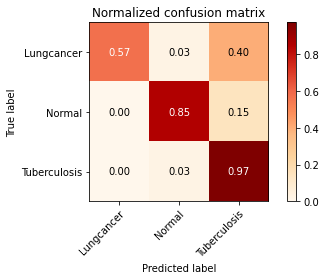

In [38]:
y_pred = pred_H16_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 32

#### 32  soft pre bi
--> 0.86

In [44]:
BS = 32                                                       ##
filepath = "model32_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:06<00:00, 71.70it/s] 


In [45]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [46]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H32_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])

pred_H32_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5022 - accuracy: 0.6471
Epoch 1: val_accuracy improved from -inf to 0.51327, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 87s 3s/step - loss: 0.5022 - accuracy: 0.6471 - val_loss: 0.6682 - val_accuracy: 0.5133 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.2892 - accuracy: 0.8758
Epoch 2: val_accuracy did not improve from 0.51327
10/10 [==============================] - 10s 948ms/step - loss: 0.2892 - accuracy: 0.8758 - val_loss: 0.6839 - val_accuracy: 0.5044 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2334 - accuracy: 0.8922
Epoch 3: val_accuracy improved from 0.51327 to 0.52212, saving model to model32_soft_pre_bi.h5
10/10 [==============================] - 15s 1s/step - loss: 0.2334 - accuracy: 0.8922 - val_loss: 0.6535 - val_accuracy: 0.5221 - lr: 1.0000e-04
Epoch 4/100
10/10 [=================

In [47]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

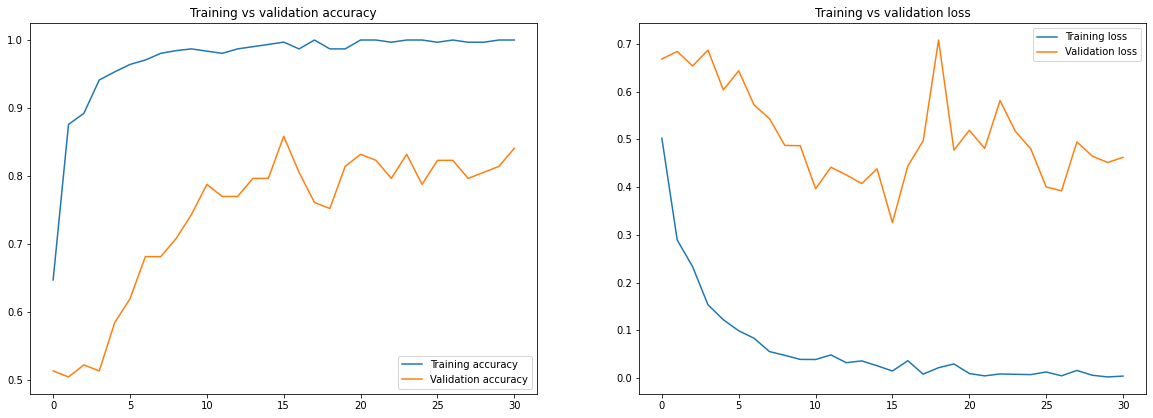

<Figure size 432x288 with 0 Axes>

In [48]:
H_Dense = H32_soft_pre_bi                            ##
pred_Dense = pred_H32_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[23  2 10]
 [ 0 39  2]
 [ 0  4 33]]
Normalized confusion matrix
[[0.66 0.06 0.29]
 [0.   0.95 0.05]
 [0.   0.11 0.89]]


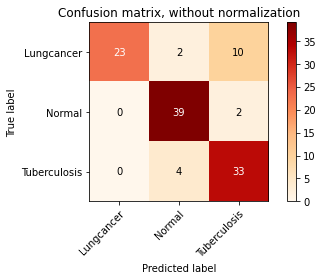

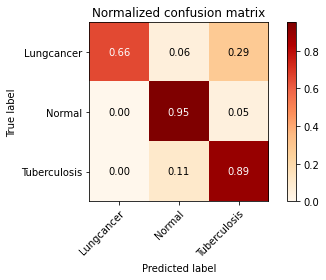

In [49]:
y_pred = pred_H32_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre bi adam
--> 0.81

In [50]:
BS = 32                                                      ##
filepath = "model32_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:06<00:00, 67.50it/s] 


In [51]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [52]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.5334 - accuracy: 0.6078
Epoch 1: val_accuracy improved from -inf to 0.65487, saving model to model32_soft_pre_bi_adam.h5
10/10 [==============================] - 43s 2s/step - loss: 0.5334 - accuracy: 0.6078 - val_loss: 0.5016 - val_accuracy: 0.6549 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3312 - accuracy: 0.7876
Epoch 2: val_accuracy did not improve from 0.65487
10/10 [==============================] - 9s 820ms/step - loss: 0.3312 - accuracy: 0.7876 - val_loss: 0.4743 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2548 - accuracy: 0.8627
Epoch 3: val_accuracy did not improve from 0.65487
10/10 [==============================] - 8s 858ms/step - loss: 0.2548 - accuracy: 0.8627 - val_loss: 0.5155 - val_accuracy: 0.6195 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.199

In [53]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

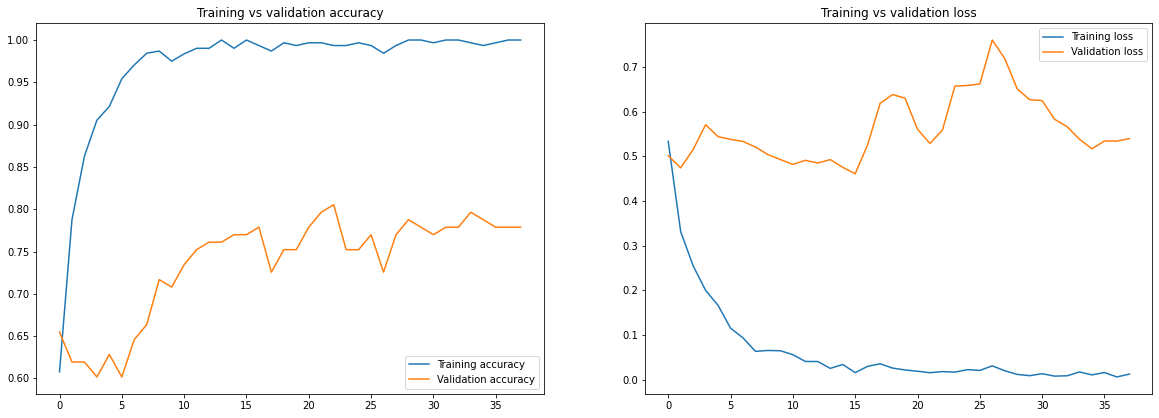

<Figure size 432x288 with 0 Axes>

In [54]:
H_Dense = H32_soft_pre_bi_adam                            ##
pred_Dense = pred_H32_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[17  0 18]
 [ 0 35  6]
 [ 0  1 36]]
Normalized confusion matrix
[[0.49 0.   0.51]
 [0.   0.85 0.15]
 [0.   0.03 0.97]]


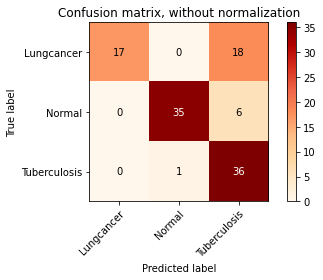

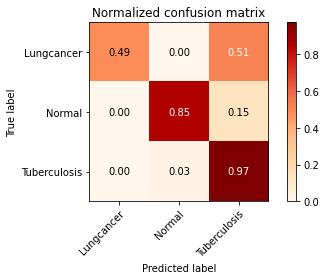

In [55]:
y_pred = pred_H32_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate 
--> 0.89

In [56]:
BS = 32                                                             ##
filepath = "model32_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.34it/s] 


In [57]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [58]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

#download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.7656 - accuracy: 0.6667
Epoch 1: val_accuracy improved from -inf to 0.60177, saving model to model32_soft_pre_cate.h5
10/10 [==============================] - 38s 1s/step - loss: 0.7656 - accuracy: 0.6667 - val_loss: 0.9998 - val_accuracy: 0.6018 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.3979 - accuracy: 0.8431
Epoch 2: val_accuracy did not improve from 0.60177
10/10 [==============================] - 8s 747ms/step - loss: 0.3979 - accuracy: 0.8431 - val_loss: 1.1213 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2793 - accuracy: 0.9020
Epoch 3: val_accuracy did not improve from 0.60177
10/10 [==============================] - 8s 747ms/step - loss: 0.2793 - accuracy: 0.9020 - val_loss: 1.1854 - val_accuracy: 0.5310 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2354 -

In [59]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

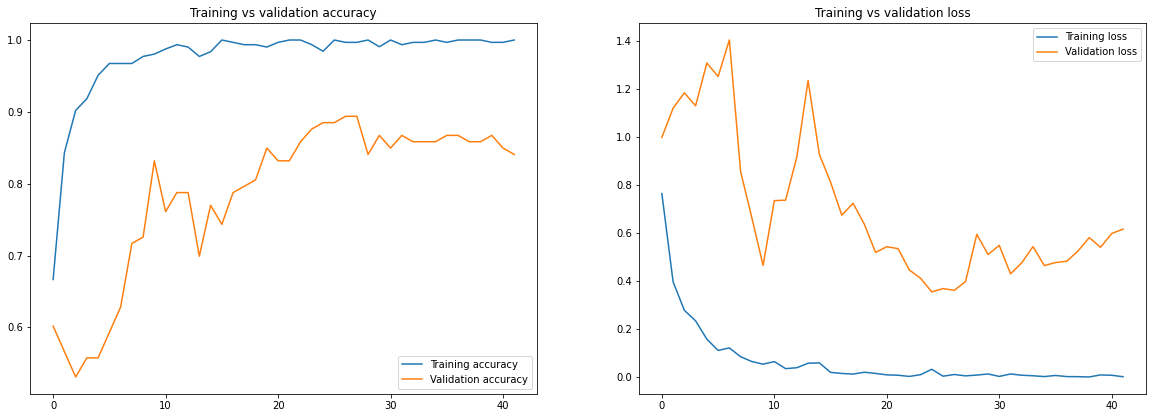

<Figure size 432x288 with 0 Axes>

In [60]:
H_Dense = H32_soft_pre_cate                            ##
pred_Dense = pred_H32_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[24  1 10]
 [ 0 37  4]
 [ 0  3 34]]
Normalized confusion matrix
[[0.69 0.03 0.29]
 [0.   0.9  0.1 ]
 [0.   0.08 0.92]]


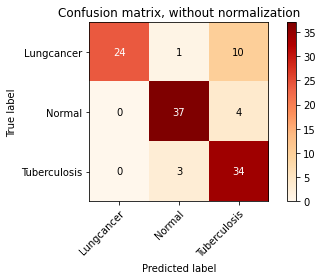

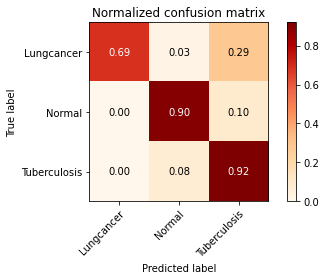

In [61]:
y_pred = pred_H32_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 32 soft pre cate adam
--> 0.81

In [62]:
BS = 32                                                       ##
filepath = "model32_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 94.61it/s] 


In [63]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [64]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H32_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense,  batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H32_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H32_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 0.8055 - accuracy: 0.6078
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model32_soft_pre_cate_adam.h5
10/10 [==============================] - 31s 1s/step - loss: 0.8055 - accuracy: 0.6078 - val_loss: 1.0330 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 0.4532 - accuracy: 0.8105
Epoch 2: val_accuracy did not improve from 0.62832
10/10 [==============================] - 7s 712ms/step - loss: 0.4532 - accuracy: 0.8105 - val_loss: 0.9876 - val_accuracy: 0.5664 - lr: 1.0000e-04
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 0.2782 - accuracy: 0.8987
Epoch 3: val_accuracy did not improve from 0.62832
10/10 [==============================] - 7s 722ms/step - loss: 0.2782 - accuracy: 0.8987 - val_loss: 1.1946 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 0.2

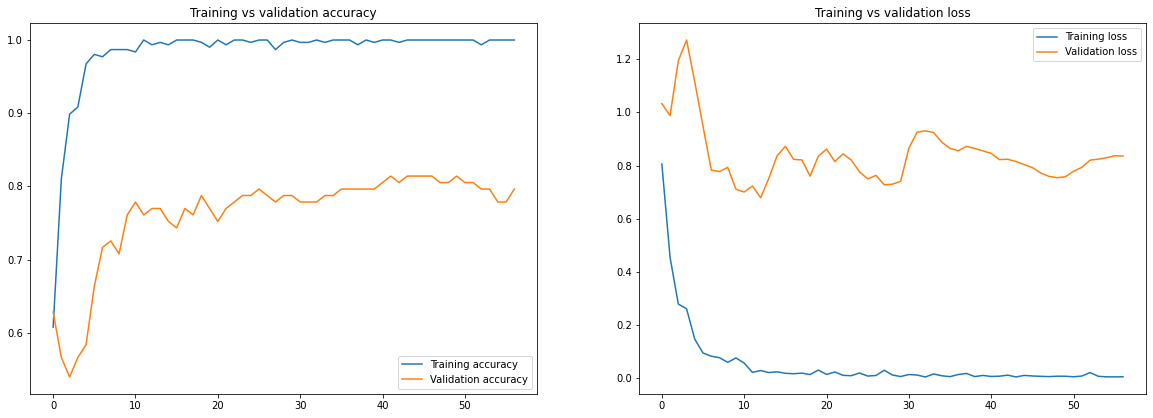

<Figure size 432x288 with 0 Axes>

In [65]:
H_Dense = H32_soft_pre_cate_adam                            ##
pred_Dense = pred_H32_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[19  0 16]
 [ 0 34  7]
 [ 0  0 37]]
Normalized confusion matrix
[[0.54 0.   0.46]
 [0.   0.83 0.17]
 [0.   0.   1.  ]]


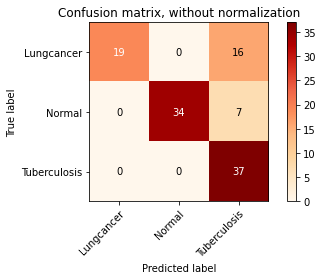

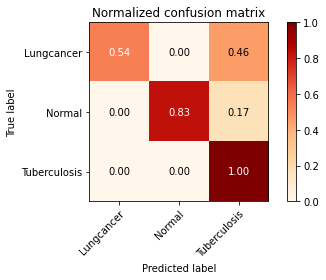

In [66]:
y_pred = pred_H32_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

### 1

#### 1  soft pre bi
--> 0.80

In [67]:
BS = 1                                                      ##
filepath = "model1_soft_pre_bi.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 95.33it/s] 


In [68]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [69]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

##
H1_soft_pre_bi = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
##
pred_H1_soft_pre_bi = model_Dense.predict(x_test_Dense)
    

print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)       

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.6056 - accuracy: 0.4645
Epoch 1: val_accuracy improved from -inf to 0.62832, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 77s 149ms/step - loss: 0.6056 - accuracy: 0.4645 - val_loss: 0.5126 - val_accuracy: 0.6283 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.4676 - accuracy: 0.6686
Epoch 2: val_accuracy improved from 0.62832 to 0.63717, saving model to model1_soft_pre_bi.h5
338/338 [==============================] - 45s 133ms/step - loss: 0.4676 - accuracy: 0.6686 - val_loss: 0.4692 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4142 - accuracy: 0.6302
Epoch 3: val_accuracy did not improve from 0.63717
338/338 [==============================] - 43s 128ms/step - loss: 0.4142 - accuracy: 0.6302 - val_loss: 0.4926 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 4/100
338/338 

In [70]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

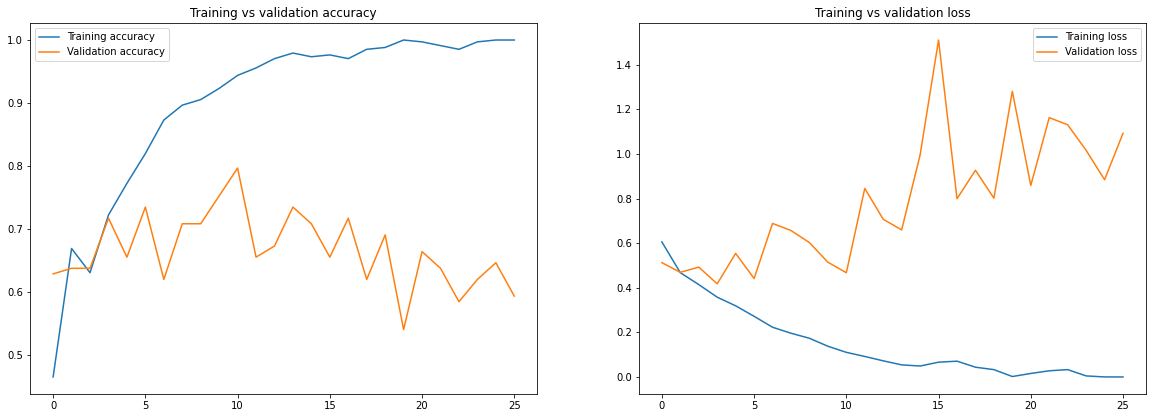

<Figure size 432x288 with 0 Axes>

In [71]:
H_Dense = H1_soft_pre_bi                            ##
pred_Dense = pred_H1_soft_pre_bi                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[16  0 19]
 [ 1 17 23]
 [ 3  0 34]]
Normalized confusion matrix
[[0.46 0.   0.54]
 [0.02 0.41 0.56]
 [0.08 0.   0.92]]


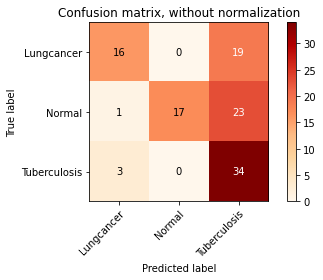

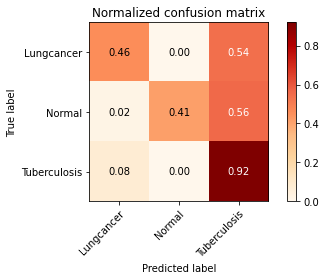

In [72]:
y_pred = pred_H1_soft_pre_bi.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre bi adam
--> 0.71

In [73]:
BS = 1                                                            ##
filepath = "model1_soft_pre_bi_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:05<00:00, 90.02it/s] 


In [74]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [75]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="binary_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_bi_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_bi_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_bi_adam.argmax(axis=1),               ####
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.5903 - accuracy: 0.5325
Epoch 1: val_accuracy improved from -inf to 0.63717, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 62s 135ms/step - loss: 0.5903 - accuracy: 0.5325 - val_loss: 0.4734 - val_accuracy: 0.6372 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.4691 - accuracy: 0.6065
Epoch 2: val_accuracy improved from 0.63717 to 0.69912, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 41s 121ms/step - loss: 0.4691 - accuracy: 0.6065 - val_loss: 0.4546 - val_accuracy: 0.6991 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.4160 - accuracy: 0.6953
Epoch 3: val_accuracy improved from 0.69912 to 0.70796, saving model to model1_soft_pre_bi_adam.h5
338/338 [==============================] - 41s 122ms/step - loss: 0.4160 - accuracy: 0.6953 - val_loss: 0.4944 - 

In [76]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

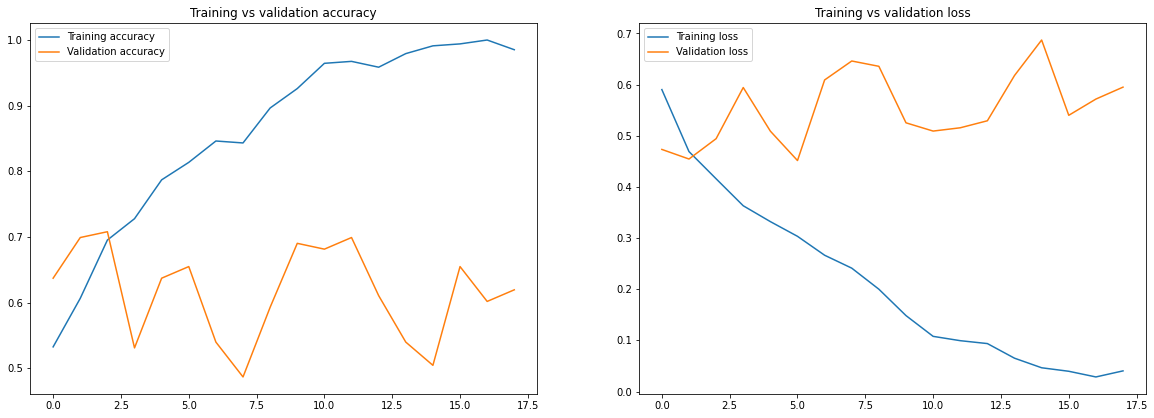

<Figure size 432x288 with 0 Axes>

In [77]:
H_Dense = H1_soft_pre_bi_adam                            ##
pred_Dense = pred_H1_soft_pre_bi_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[23  1 11]
 [ 0 12 29]
 [ 2  0 35]]
Normalized confusion matrix
[[0.66 0.03 0.31]
 [0.   0.29 0.71]
 [0.05 0.   0.95]]


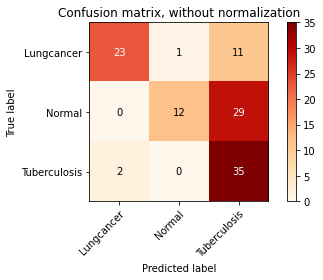

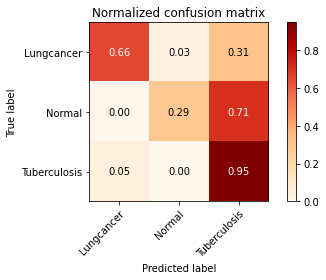

In [78]:
y_pred = pred_H1_soft_pre_bi_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate 
--> 0.79

In [79]:
BS = 1                                                             ##
filepath = "model1_soft_pre_cate.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 91.09it/s] 


In [80]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [81]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 0.9937 - accuracy: 0.4793
Epoch 1: val_accuracy improved from -inf to 0.70796, saving model to model1_soft_pre_cate.h5
338/338 [==============================] - 76s 151ms/step - loss: 0.9937 - accuracy: 0.4793 - val_loss: 0.7217 - val_accuracy: 0.7080 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.7283 - accuracy: 0.6509
Epoch 2: val_accuracy improved from 0.70796 to 0.71681, saving model to model1_soft_pre_cate.h5
338/338 [==============================] - 47s 138ms/step - loss: 0.7283 - accuracy: 0.6509 - val_loss: 0.5943 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.5747 - accuracy: 0.7219
Epoch 3: val_accuracy did not improve from 0.71681
338/338 [==============================] - 45s 132ms/step - loss: 0.5747 - accuracy: 0.7219 - val_loss: 0.6393 - val_accuracy: 0.7168 - lr: 1.0000e-04
Epoch 4/100
338/

In [82]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

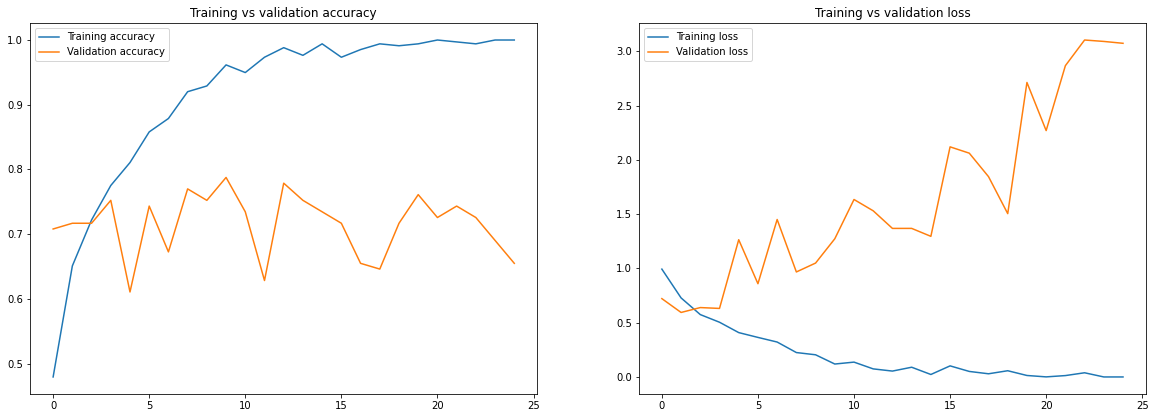

<Figure size 432x288 with 0 Axes>

In [83]:
H_Dense = H1_soft_pre_cate                            ##
pred_Dense = pred_H1_soft_pre_cate                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[23  0 12]
 [ 6 20 15]
 [ 5  1 31]]
Normalized confusion matrix
[[0.66 0.   0.34]
 [0.15 0.49 0.37]
 [0.14 0.03 0.84]]


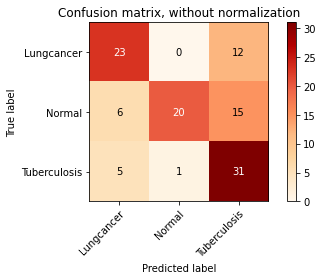

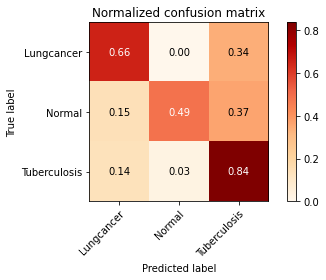

In [84]:
y_pred = pred_H1_soft_pre_cate.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

#### 1 soft pre cate adam
--> 0.81

In [85]:
BS = 1                                                       ##
filepath = "model1_soft_pre_cate_adam.h5"                  ##

train_img_Dense = []
for ImageName in tqdm(data_train3['ImageName']):              
    image_path = All_3class_dir +'/' + ImageName                  
    img = cv2.imread(image_path)                                          
    img = cv2.resize(img, (224, 224))                                      
    train_img_Dense.append(img)
data_Dense = np.array(train_img_Dense, dtype="float32") / 255.0

labels_Dense = np.array(data_train3[['NameType']] )        
labels_Dense.shape = (len(labels_Dense),) 
le_Dense = LabelEncoder()                                                                     
labels_Dense = le_Dense.fit_transform(labels_Dense)                                         
labels_Dense = to_categorical(labels_Dense, num_classes=3)                   

aug2 = ImageDataGenerator(
		rotation_range=15,						
		width_shift_range=0.1,
		height_shift_range=0.1,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

callback = tf.keras.callbacks.EarlyStopping(
                monitor="val_accuracy",
                patience=15,
                mode="max" )

checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, 
                    save_best_only=True, mode='max')

reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=6, 
                                   verbose=1, mode='max', min_lr=0.00001)

100%|██████████| 451/451 [00:04<00:00, 90.51it/s] 


In [86]:
(x_train_Dense2, x_test_Dense2, y_train_Dense2, y_test_Dense2 ) = train_test_split(data_Dense, labels_Dense,
	                                                                                                test_size=0.25, random_state=40)

x_train_Dense = x_train_Dense2
x_test_Dense = x_test_Dense2
y_train_Dense = y_train_Dense2
y_test_Dense = y_test_Dense2

In [87]:
base_model_Dense = tf.keras.applications.DenseNet201(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
base_model_Dense.trainable = True
for layer in base_model_Dense.layers[:400]:    #fix w & bias in layer 0-400
    layer.trainable = False

#Add custom head
average_pooling_layer = tf.keras.layers.GlobalAveragePooling2D()(base_model_Dense.output)
prediction_layer = tf.keras.layers.Dense(units=3, activation="softmax")(average_pooling_layer)   
model_Dense = tf.keras.models.Model(inputs=base_model_Dense.input, outputs=prediction_layer)

model_Dense.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

####
H1_soft_pre_cate_adam = model_Dense.fit( x=aug2.flow(x_train_Dense, y_train_Dense, 
                                               batch_size=BS),
	                                            validation_data=(x_test_Dense, y_test_Dense),
	                                            steps_per_epoch=len(x_train_Dense) // BS,
	                                            epochs=100,  callbacks = [callback, checkpoint, reduce_lr])
####
pred_H1_soft_pre_cate_adam = model_Dense.predict(x_test_Dense)
    
print(classification_report(y_test_Dense.argmax(axis=1),	                
                                        pred_H1_soft_pre_cate_adam.argmax(axis=1),  
                                        target_names=le_Dense.classes_))

# #download ไฟล์ลงเครื่อง
# from google.colab import files
# files.download( filepath)        

Epoch 1/100
338/338 [==============================] - ETA: 0s - loss: 1.0184 - accuracy: 0.5000
Epoch 1: val_accuracy improved from -inf to 0.61062, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 62s 129ms/step - loss: 1.0184 - accuracy: 0.5000 - val_loss: 0.8152 - val_accuracy: 0.6106 - lr: 1.0000e-04
Epoch 2/100
338/338 [==============================] - ETA: 0s - loss: 0.7538 - accuracy: 0.6302
Epoch 2: val_accuracy improved from 0.61062 to 0.69027, saving model to model1_soft_pre_cate_adam.h5
338/338 [==============================] - 40s 119ms/step - loss: 0.7538 - accuracy: 0.6302 - val_loss: 0.6564 - val_accuracy: 0.6903 - lr: 1.0000e-04
Epoch 3/100
338/338 [==============================] - ETA: 0s - loss: 0.6001 - accuracy: 0.7101
Epoch 3: val_accuracy did not improve from 0.69027
338/338 [==============================] - 38s 112ms/step - loss: 0.6001 - accuracy: 0.7101 - val_loss: 1.0029 - val_accuracy: 0.5398 - lr: 1.0000e-04
Epoch 

In [88]:
from plotly import __version__
%matplotlib inline

import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot

import cufflinks as cf
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 


cf.go_offline()

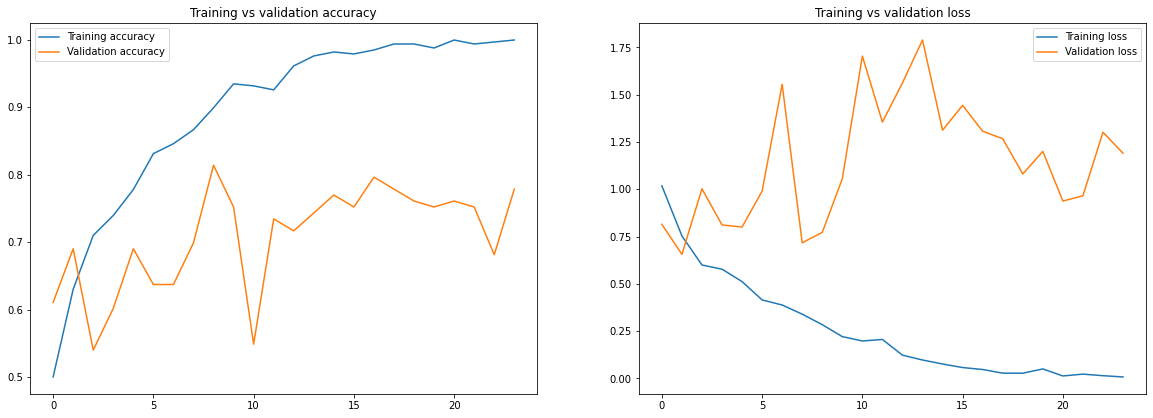

<Figure size 432x288 with 0 Axes>

In [89]:
H_Dense = H1_soft_pre_cate_adam                            ##
pred_Dense = pred_H1_soft_pre_cate_adam                 ##

accuracy = H_Dense.history['accuracy']
val_accuracy  = H_Dense.history['val_accuracy']

loss = H_Dense.history['loss']
val_loss = H_Dense.history['val_loss']
plt.figure(figsize=(20,15))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training accuracy")
plt.plot(val_accuracy, label="Validation accuracy")
plt.legend()
plt.title("Training vs validation accuracy")

plt.subplot(2,2,2)
plt.plot(loss, label = "Training loss")
plt.plot(val_loss, label="Validation loss")
plt.legend()
plt.title("Training vs validation loss")

plt.figure()
plt.show()

Confusion matrix, without normalization
[[25  0 10]
 [ 3 30  8]
 [ 3  1 33]]
Normalized confusion matrix
[[0.71 0.   0.29]
 [0.07 0.73 0.2 ]
 [0.08 0.03 0.89]]


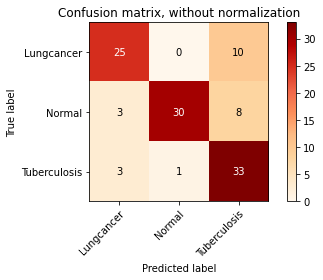

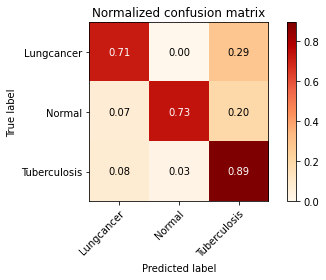

In [90]:
y_pred = pred_H1_soft_pre_cate_adam.argmax(axis=1)            ##
y_true  = y_test_Dense.argmax(axis=1)
y_test = y_test_Dense.argmax(axis=1)

class_names = le_Dense.classes_


def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.OrRd):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test, y_pred, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()